## BDS HW 3

In [58]:
!pip install requests
!pip install bs4
!pip install csv
!pip install PyPDF2
!pip install tika
!pip install tqdm
!pip install pandas
!pip install numpy

ERROR: Could not find a version that satisfies the requirement csv (from versions: none)
ERROR: No matching distribution found for csv


In [1]:
# imports
import requests 
from bs4 import BeautifulSoup
import csv
import os
import PyPDF2
from tika import parser
from tqdm import tqdm
import numpy as np
from math import log, e
import pandas as pd

In [2]:
%config Completer.use_jedi = False

In [3]:
from IPython.core.debugger import set_trace

In [62]:
# URL from which pdfs to be downloaded
url = "http://proceedings.mlr.press/v70/"
  
# Requests URL and get response object
response = requests.get(url)
  
# Parse text obtained
soup = BeautifulSoup(response.text, 'html.parser')
  
# Find all hyperlinks present on webpage
links = soup.find_all('a')
  
i = 0
  
# From all links check for pdf link and
# if present download file
# check if links already exists
directory = os.getcwd()
for link in tqdm(links):
    if ('.pdf' in link.get('href', [])):
        i += 1
  
        # Get response object for link
        response = requests.get(link.get('href'))
  
        # Write content in pdf file
        # check if pdf exists already
        if not os.path.exists(directory + "/pdf"+str(i)+".pdf"):
            pdf = open("pdf"+str(i)+".pdf", 'wb')
            pdf.write(response.content)
            pdf.close()
  
print("All PDF files downloaded")

  5%|███▋                                                                        | 57/1190 [00:05<01:44, 10.83it/s]


KeyboardInterrupt: 

In [ ]:
directory = os.getcwd()
allwords = []
for filename in tqdm(os.listdir(directory)):
    if filename.endswith(".pdf"):
        rawText = parser.from_file(filename)
        try:
            pdf_words = rawText['content'].split()
            allwords.extend([x.strip().lower() for x in pdf_words if x.strip().isalpha()])
        except AttributeError:
            print(f'There was an error with file: {filename}')

In [ ]:
# clean words in allwords
with open('words_dictionary.json') as json_file:
    eng_dict = json.load(json_file)
    allwords_clean = []
    for word in allwords:
        if word.lower() in eng_dict:
            allwords_clean.append(word)

# save all words clean
text_file = open('all _words_clean.txt', 'w')
for elem in allwords_clean:
    text_file.write(elem+'\n')
text_file.close()

In [ ]:
print(f'The reduced word list after cleaning is: {len(allwords_clean)}\nFrom the original: {len(allwords)}')

1. What are the top 10 common words in the ICML papers?

In [ ]:
# find the top 10 words
from collections import Counter

def getTop10(lst):
    counted = Counter(lst)
    return counted.most_common(10)

most_common = getTop10(allwords_clean)

In [ ]:
print(f'The most common words used are:\n {most_common}')

2. Let Z be a randomly selected word in a randomly selected ICML paper. Estimate the entropy of Z.

In [ ]:
def entropy(items, base=None):
    n_items = len(items)
    
    if n_items <= 1:
        return 0
    
    value, counts = np.unique(items, return_counts=True)
    probs = counts / n_items
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0

    ent = 0.

    # Compute entropy
    base = e if base is None else base
    for i in probs:
        ent -= i * log(i, base)

    return ent

In [ ]:
print(entropy(allwords_clean))

3. Synthesize a random paragraph using the marginal distribution over words.

In [ ]:
# create a DF with marginal distrabution probabilities and words
counted_words = Counter(allwords_clean)
marginal_dist_words = {}
n_words = len(allwords_clean)
for key, value in counted_words.items():
    marginal_dist_words[key] = value/n_words

In [ ]:
marginal_dist_words_df = pd.DataFrame(marginal_dist_words.items(), columns=['word', 'distrabution'])

In [ ]:
sampled_words = (marginal_dist_words_df.sample(n=10, weights='distrabution')['word']).to_list()

In [ ]:
sentence = ''
for word in sampled_words:
    sentence += word+' '
sentence

Problem 3: More on Kaggle Advanced Regression.

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [5]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [6]:
null_values = train_raw.isnull().sum()
null_values[null_values > 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [7]:
train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [8]:
# data pipeline
# 1. label encode categorical values
# 2. one-hot encode label encoded values
# 3. use PCA for dim reduction
# 4. XGBoost with RandomizedSearchCV to find best hyperperameters

In [11]:
# impute for categorical values and numeric values
def get_categorical_cols(df):
    cols = df.columns
    num_cols = df._get_numeric_data().columns
    return list(set(cols) - set(num_cols))

def get_numeric_cols(df):
    num_cols = df._get_numeric_data().columns
    return num_cols

def impute_data(df):
    # impute categorical data
    cat_cols = get_categorical_cols(df)
    for col in cat_cols:
        df[col] = np.where(df[col].isnull(), "Unknown", df[col])
        
    # impute numeric data with interpolation
    num_cols = get_numeric_cols(df)
    for col in num_cols:
        df[col].interpolate(method='linear', direction = 'forward', inplace=True) 
        
    return df

In [12]:
imputed_df_test = impute_data(test)
imputed_df_train = impute_data(train)

In [13]:
imputed_df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Dropping columns:
1. PoolQC
2. Fence
3. MiscFeature
4. Alley
5. ID

In [14]:
def drop_cols(df):
    cols = ['PoolQC', 'Fence', 'MiscFeature', 'Alley', 'Id']
    res = df.drop(columns=cols, axis=1)
    return res

In [15]:
dropped_df_train = drop_cols(imputed_df_train)
dropped_df_test = drop_cols(imputed_df_test)

In [16]:
dropped_df_test.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF'

In [17]:
dropped_df_train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF'

One-hot encoding categorical values

In [18]:
cat_cols_train = get_categorical_cols(dropped_df_train)
cat_cols_test = get_categorical_cols(dropped_df_test)
dum_df_train = pd.get_dummies(dropped_df_train, cat_cols_train)
dum_df_test = pd.get_dummies(dropped_df_test, cat_cols_test)

In [19]:
y_train = dum_df_train['SalePrice']
dum_df_train.drop(columns=['SalePrice'], axis=1, inplace=True)

In [20]:
aligned_train_X, aligned_test_X = dum_df_train.align(dum_df_test, join='right', axis=1)

In [21]:
len(aligned_train_X.columns)

277

In [22]:
len(aligned_test_X.columns)

277

Feature Normalization

In [205]:
# replace null values in one-hot encoded alignment with 0
test2 = pd.Series(np.isfinite(aligned_train_X).all())
null_categories = list(test2[test2 == False].index)

for col in null_categories:
    aligned_train_X[col] = np.where(aligned_train_X[col].isnull(), 0, aligned_train_X[col])

In [206]:
test3 = pd.Series(np.isfinite(aligned_train_X).all())
list(test3[test3 == False].index)

[]

In [207]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(aligned_train_X)
X_test = scaler.transform(aligned_test_X)

PCA Feature Extraction

In [191]:
from sklearn.decomposition import PCA
pca = PCA(n_components=15)
pca.fit(X_train)
print(pca.explained_variance_ratio_)

[0.07030503 0.03153142 0.02716277 0.02477773 0.02162831 0.0192392
 0.01675633 0.0164129  0.01279725 0.01263748 0.01220948 0.01124468
 0.01066514 0.01031176 0.01010164]


The explained variance for each PC is very small, this is not a good representation of the data

#### XGBoost Ensemble method

In [58]:
import xgboost as xgb
from sklearn.metrics import f1_score

In [192]:
xgb_clf = xgb.XGBClassifier(objective="reg:logistic")
xgb_clf.fit(X_train, y_train)

C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [193]:
y_train_preds = xgb_clf.predict(X_train)
y_test_preds = xgb_clf.predict(X_test)
print("Training F1 Micro Average: ", f1_score(y_train, y_train_preds, average = "micro"))

Training F1 Micro Average:  0.934931506849315


In [194]:
len(y_test_preds)

1459

In [195]:
len(test)

1459

In [88]:
ids = test['Id']
data = {'Id': ids, 'SalePrice': y_test_preds}

In [92]:
# export predictions
export_series = pd.DataFrame(data=data)
export_series.to_csv('hw3_XGBoost1.csv', columns=['Id', 'SalePrice'], index=False)

More feature engineering
1. Remove highly correlated features
2. preform XGBoost again

In [211]:
test2 = pd.Series(np.isfinite(aligned_train_X).all())
null_categories = list(test2[test2 == False].index)

for col in null_categories:
    aligned_train_X[col] = np.where(aligned_train_X[col].isnull(), 0, aligned_train_X[col])

In [212]:
# find highly correltated features
threshold = 0.9
X_train_df = pd.DataFrame(aligned_train_X, columns=aligned_train_X.columns)
corr_matrix = X_train_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

In [213]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 19 columns to remove.


In [214]:
X_train = aligned_train_X.drop(columns=to_drop)
X_test = aligned_test_X.drop(columns=to_drop)

In [215]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [216]:
xgb_clf = xgb.XGBClassifier(objective="reg:logistic")
xgb_clf.fit(X_train_std, y_train)

C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [217]:
feat_importances  = pd.Series(xgb_clf.feature_importances_, index=X_train.columns)

In [218]:
important_features_20 = feat_importances.nlargest(20)

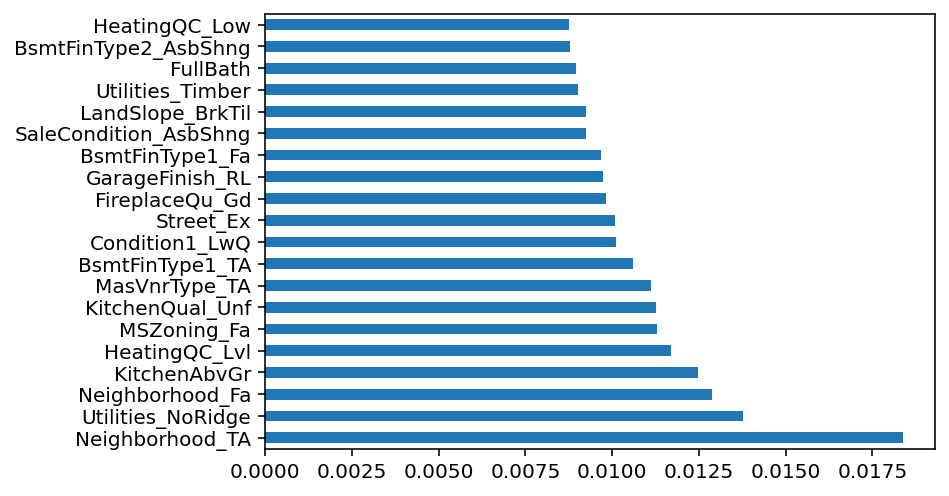

In [219]:
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [220]:
y_train_preds = xgb_clf.predict(X_train_std)
y_test_preds = xgb_clf.predict(X_test_std)
print("Training F1 Micro Average: ", f1_score(y_train, y_train_preds, average = "micro"))

Training F1 Micro Average:  0.9315068493150684


In [203]:
ids = test['Id']
data = {'Id': ids, 'SalePrice': y_test_preds}

In [204]:
export_series = pd.DataFrame(data=data)
export_series.to_csv('hw3_XGBoost2.csv', columns=['Id', 'SalePrice'], index=False)

Using RandomizeCV with XGBoost to tune hyperperameters

In [221]:
from sklearn.model_selection import RandomizedSearchCV

xgb_clf = xgb.XGBClassifier(tree_method = "auto", predictor = "gpu_predictor", objective = "reg:logistic")

# Create parameter grid
parameters = {"learning_rate": [0.1, 0.01, 0.001],
               "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
               "max_depth": [2, 4, 7, 10],
               "min_child_weight": [1, 3, 5, 7],
               "n_estimators": [100, 250, 500]}

# Create RandomizedSearchCV Object
# xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = parameters, scoring = "f1_micro",
#                              cv = 7, verbose = 3, random_state = 40)

In [222]:
# model_xgboost = xgb_rscv.fit(X_train_std, y_train)

Fitting 7 folds for each of 10 candidates, totalling 70 fits


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/7] END gamma=0.3, learning_rate=0.1, max_depth=10, min_child_weight=1, n_estimators=500;, score=0.010 total time= 1.6min


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/7] END gamma=0.3, learning_rate=0.1, max_depth=10, min_child_weight=1, n_estimators=500;, score=0.014 total time= 1.6min


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/7] END gamma=0.3, learning_rate=0.1, max_depth=10, min_child_weight=1, n_estimators=500;, score=0.019 total time= 1.6min


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/7] END gamma=0.3, learning_rate=0.1, max_depth=10, min_child_weight=1, n_estimators=500;, score=0.010 total time= 1.6min


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/7] END gamma=0.3, learning_rate=0.1, max_depth=10, min_child_weight=1, n_estimators=500;, score=0.019 total time= 1.6min


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 6/7] END gamma=0.3, learning_rate=0.1, max_depth=10, min_child_weight=1, n_estimators=500;, score=0.010 total time= 1.6min


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 7/7] END gamma=0.3, learning_rate=0.1, max_depth=10, min_child_weight=1, n_estimators=500;, score=0.019 total time= 1.6min


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/7] END gamma=0.1, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=100;, score=0.024 total time=  11.5s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/7] END gamma=0.1, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=100;, score=0.005 total time=  11.4s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/7] END gamma=0.1, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=100;, score=0.024 total time=  11.3s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/7] END gamma=0.1, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=100;, score=0.014 total time=  11.5s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/7] END gamma=0.1, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=100;, score=0.019 total time=  11.5s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 6/7] END gamma=0.1, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=100;, score=0.005 total time=  11.3s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 7/7] END gamma=0.1, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=100;, score=0.014 total time=  11.3s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/7] END gamma=0.01, learning_rate=0.1, max_depth=2, min_child_weight=5, n_estimators=250;, score=0.000 total time=  27.9s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/7] END gamma=0.01, learning_rate=0.1, max_depth=2, min_child_weight=5, n_estimators=250;, score=0.000 total time=  28.0s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/7] END gamma=0.01, learning_rate=0.1, max_depth=2, min_child_weight=5, n_estimators=250;, score=0.000 total time=  28.0s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/7] END gamma=0.01, learning_rate=0.1, max_depth=2, min_child_weight=5, n_estimators=250;, score=0.000 total time=  28.6s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/7] END gamma=0.01, learning_rate=0.1, max_depth=2, min_child_weight=5, n_estimators=250;, score=0.000 total time=  28.8s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 6/7] END gamma=0.01, learning_rate=0.1, max_depth=2, min_child_weight=5, n_estimators=250;, score=0.000 total time=  28.2s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 7/7] END gamma=0.01, learning_rate=0.1, max_depth=2, min_child_weight=5, n_estimators=250;, score=0.000 total time=  27.8s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/7] END gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=100;, score=0.000 total time=  11.1s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/7] END gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=100;, score=0.000 total time=  11.0s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/7] END gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=100;, score=0.000 total time=  11.0s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/7] END gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=100;, score=0.000 total time=  11.2s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/7] END gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=100;, score=0.000 total time=  11.1s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 6/7] END gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=100;, score=0.000 total time=  10.9s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 7/7] END gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=100;, score=0.000 total time=  11.1s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/7] END gamma=0.5, learning_rate=0.1, max_depth=2, min_child_weight=5, n_estimators=500;, score=0.000 total time=  57.1s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/7] END gamma=0.5, learning_rate=0.1, max_depth=2, min_child_weight=5, n_estimators=500;, score=0.000 total time=  57.1s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/7] END gamma=0.5, learning_rate=0.1, max_depth=2, min_child_weight=5, n_estimators=500;, score=0.000 total time=  56.5s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/7] END gamma=0.5, learning_rate=0.1, max_depth=2, min_child_weight=5, n_estimators=500;, score=0.000 total time=  57.4s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/7] END gamma=0.5, learning_rate=0.1, max_depth=2, min_child_weight=5, n_estimators=500;, score=0.000 total time=  57.8s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 6/7] END gamma=0.5, learning_rate=0.1, max_depth=2, min_child_weight=5, n_estimators=500;, score=0.000 total time=  55.9s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 7/7] END gamma=0.5, learning_rate=0.1, max_depth=2, min_child_weight=5, n_estimators=500;, score=0.000 total time=  56.6s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/7] END gamma=0.3, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=100;, score=0.000 total time=  11.1s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/7] END gamma=0.3, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=100;, score=0.000 total time=  11.1s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/7] END gamma=0.3, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=100;, score=0.000 total time=  11.4s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/7] END gamma=0.3, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=100;, score=0.000 total time=  11.3s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/7] END gamma=0.3, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=100;, score=0.000 total time=  11.2s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 6/7] END gamma=0.3, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=100;, score=0.000 total time=  10.9s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 7/7] END gamma=0.3, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=100;, score=0.000 total time=  11.0s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/7] END gamma=1, learning_rate=0.001, max_depth=7, min_child_weight=7, n_estimators=100;, score=0.000 total time=  11.0s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/7] END gamma=1, learning_rate=0.001, max_depth=7, min_child_weight=7, n_estimators=100;, score=0.000 total time=  10.9s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/7] END gamma=1, learning_rate=0.001, max_depth=7, min_child_weight=7, n_estimators=100;, score=0.000 total time=  11.0s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/7] END gamma=1, learning_rate=0.001, max_depth=7, min_child_weight=7, n_estimators=100;, score=0.000 total time=  11.2s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/7] END gamma=1, learning_rate=0.001, max_depth=7, min_child_weight=7, n_estimators=100;, score=0.000 total time=  11.1s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 6/7] END gamma=1, learning_rate=0.001, max_depth=7, min_child_weight=7, n_estimators=100;, score=0.000 total time=  10.9s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 7/7] END gamma=1, learning_rate=0.001, max_depth=7, min_child_weight=7, n_estimators=100;, score=0.000 total time=  11.1s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/7] END gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=250;, score=0.010 total time=  27.9s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/7] END gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=250;, score=0.005 total time=  28.1s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/7] END gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=250;, score=0.014 total time=  28.3s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/7] END gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=250;, score=0.005 total time=  28.9s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/7] END gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=250;, score=0.010 total time=  28.3s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 6/7] END gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=250;, score=0.010 total time=  28.0s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 7/7] END gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=250;, score=0.014 total time=  28.6s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/7] END gamma=1.5, learning_rate=0.001, max_depth=4, min_child_weight=7, n_estimators=500;, score=0.000 total time=  58.1s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/7] END gamma=1.5, learning_rate=0.001, max_depth=4, min_child_weight=7, n_estimators=500;, score=0.000 total time=  56.7s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/7] END gamma=1.5, learning_rate=0.001, max_depth=4, min_child_weight=7, n_estimators=500;, score=0.000 total time=  56.3s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/7] END gamma=1.5, learning_rate=0.001, max_depth=4, min_child_weight=7, n_estimators=500;, score=0.000 total time=  57.3s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/7] END gamma=1.5, learning_rate=0.001, max_depth=4, min_child_weight=7, n_estimators=500;, score=0.000 total time=  57.3s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 6/7] END gamma=1.5, learning_rate=0.001, max_depth=4, min_child_weight=7, n_estimators=500;, score=0.000 total time=  56.3s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 7/7] END gamma=1.5, learning_rate=0.001, max_depth=4, min_child_weight=7, n_estimators=500;, score=0.000 total time=  56.3s


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/7] END gamma=1, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=500;, score=0.000 total time= 1.7min


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/7] END gamma=1, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=500;, score=0.014 total time= 1.7min


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/7] END gamma=1, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=500;, score=0.010 total time= 1.7min


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/7] END gamma=1, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=500;, score=0.014 total time= 1.7min


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/7] END gamma=1, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=500;, score=0.019 total time= 1.7min


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 6/7] END gamma=1, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=500;, score=0.010 total time= 1.6min


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 7/7] END gamma=1, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=500;, score=0.010 total time= 1.7min


C:\Users\jloes\anaconda3\envs\BDS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [223]:
#  model_xgboost.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=7,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1,
              objective='multi:softprob', predictor='gpu_predictor',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='auto', validate_parameters=1,
              verbosity=None)

In [225]:
# y_pred_XGBoostCV = model_xgboost.predict(X_test_std)

In [229]:
# ids = test['Id']
# data = {'Id': ids, 'SalePrice': y_pred_XGBoostCV}

In [230]:
# export_series = pd.DataFrame(data=data)
# export_series.to_csv('hw3_XGBoost3.csv', columns=['Id', 'SalePrice'], index=False)

Using MLP Regressor (Did not work)

In [231]:
from sklearn.neural_network import MLPRegressor

In [235]:
# regr = MLPRegressor(random_state=1, max_iter=1000000, verbose=True).fit(X_train_std, y_train)

Iteration 1, loss = 19519663747.48116302
Iteration 2, loss = 19519431626.90792084
Iteration 3, loss = 19519196296.18221664
Iteration 4, loss = 19518918656.65343094
Iteration 5, loss = 19518595232.37926483
Iteration 6, loss = 19518220987.53108597
Iteration 7, loss = 19517778838.80447769
Iteration 8, loss = 19517282788.57790756
Iteration 9, loss = 19516699527.75088882
Iteration 10, loss = 19516053699.39102554
Iteration 11, loss = 19515318586.54511642
Iteration 12, loss = 19514516702.40663910
Iteration 13, loss = 19513623718.97277832
Iteration 14, loss = 19512643057.43444061
Iteration 15, loss = 19511606906.15297699
Iteration 16, loss = 19510471102.75933456
Iteration 17, loss = 19509249359.45742798
Iteration 18, loss = 19507948252.19283676
Iteration 19, loss = 19506500170.38846207
Iteration 20, loss = 19504985549.83645630
Iteration 21, loss = 19503348168.39963531
Iteration 22, loss = 19501588958.00413513
Iteration 23, loss = 19499732003.44633102
Iteration 24, loss = 19497745682.77165222
I

Iteration 202, loss = 17562447045.13634872
Iteration 203, loss = 17544938951.68251038
Iteration 204, loss = 17527491140.53971481
Iteration 205, loss = 17509992896.38591003
Iteration 206, loss = 17492691649.39073944
Iteration 207, loss = 17474986255.70851517
Iteration 208, loss = 17457620347.21726608
Iteration 209, loss = 17439829670.55352020
Iteration 210, loss = 17422480774.34310913
Iteration 211, loss = 17404690918.86808014
Iteration 212, loss = 17386700138.81083679
Iteration 213, loss = 17368658566.79291534
Iteration 214, loss = 17350870850.17441940
Iteration 215, loss = 17332787345.82042694
Iteration 216, loss = 17314685046.16012192
Iteration 217, loss = 17296867901.64482117
Iteration 218, loss = 17278178725.41091537
Iteration 219, loss = 17260469030.35860062
Iteration 220, loss = 17242404520.89183044
Iteration 221, loss = 17223952873.13341522
Iteration 222, loss = 17205778860.75926208
Iteration 223, loss = 17187746303.50371552
Iteration 224, loss = 17169183546.95589447
Iteration 2

Iteration 585, loss = 9284597639.77405357
Iteration 586, loss = 9263538557.89690781
Iteration 587, loss = 9241504062.64151764
Iteration 588, loss = 9220782480.49341202
Iteration 589, loss = 9199547348.87683678
Iteration 590, loss = 9178456857.96733475
Iteration 591, loss = 9157637836.32211113
Iteration 592, loss = 9136669651.01322746
Iteration 593, loss = 9115706813.76771927
Iteration 594, loss = 9094497086.02277184
Iteration 595, loss = 9073513369.67328453
Iteration 596, loss = 9052385322.14636803
Iteration 597, loss = 9030709299.70872879
Iteration 598, loss = 9009578160.01164055
Iteration 599, loss = 8988265088.76613808
Iteration 600, loss = 8966946237.16287804
Iteration 601, loss = 8945773122.35422707
Iteration 602, loss = 8925091553.80838776
Iteration 603, loss = 8903755395.03949165
Iteration 604, loss = 8883315372.07901001
Iteration 605, loss = 8862219670.23801231
Iteration 606, loss = 8841160635.72805595
Iteration 607, loss = 8820436307.37784958
Iteration 608, loss = 8799212642.7

Iteration 788, loss = 5500876299.79119587
Iteration 789, loss = 5485840886.71389008
Iteration 790, loss = 5470394564.59359169
Iteration 791, loss = 5455276775.06506824
Iteration 792, loss = 5440248205.46442795
Iteration 793, loss = 5424677570.86012650
Iteration 794, loss = 5410014325.68343544
Iteration 795, loss = 5394677988.69614029
Iteration 796, loss = 5379843408.18848324
Iteration 797, loss = 5364630947.60781193
Iteration 798, loss = 5349587359.24518967
Iteration 799, loss = 5334515905.49759102
Iteration 800, loss = 5319692399.20091724
Iteration 801, loss = 5304852249.15572929
Iteration 802, loss = 5289790959.97335529
Iteration 803, loss = 5274884341.89920521
Iteration 804, loss = 5259795887.02418327
Iteration 805, loss = 5244807044.57718563
Iteration 806, loss = 5230108835.23686886
Iteration 807, loss = 5215315127.36275291
Iteration 808, loss = 5200363476.08363152
Iteration 809, loss = 5185754466.50682735
Iteration 810, loss = 5171091555.38629055
Iteration 811, loss = 5156533686.1

Iteration 984, loss = 3189792055.73073339
Iteration 985, loss = 3181589981.34655142
Iteration 986, loss = 3173345261.26430655
Iteration 987, loss = 3165034997.85064602
Iteration 988, loss = 3156820886.57809067
Iteration 989, loss = 3148526092.93269014
Iteration 990, loss = 3140489029.85543394
Iteration 991, loss = 3132220576.57193136
Iteration 992, loss = 3124236460.19431639
Iteration 993, loss = 3116277186.02694702
Iteration 994, loss = 3108361812.83951187
Iteration 995, loss = 3100425492.37929296
Iteration 996, loss = 3092513941.25736380
Iteration 997, loss = 3084624069.94090843
Iteration 998, loss = 3076825877.92921877
Iteration 999, loss = 3068848631.93532467
Iteration 1000, loss = 3060862705.72854853
Iteration 1001, loss = 3053058998.59686613
Iteration 1002, loss = 3045194097.68683100
Iteration 1003, loss = 3037445089.29453135
Iteration 1004, loss = 3029740342.39765167
Iteration 1005, loss = 3022162086.73361921
Iteration 1006, loss = 3014507013.07588625
Iteration 1007, loss = 3006

Iteration 1176, loss = 2080055695.30590796
Iteration 1177, loss = 2076136033.94595027
Iteration 1178, loss = 2072269102.79296279
Iteration 1179, loss = 2068402305.37270379
Iteration 1180, loss = 2064692701.35792446
Iteration 1181, loss = 2060805798.91650796
Iteration 1182, loss = 2057080677.88002920
Iteration 1183, loss = 2053187139.92673540
Iteration 1184, loss = 2049377354.83434200
Iteration 1185, loss = 2045633968.80312490
Iteration 1186, loss = 2041805593.47297120
Iteration 1187, loss = 2038135929.80913877
Iteration 1188, loss = 2034253210.55692649
Iteration 1189, loss = 2030504130.83478475
Iteration 1190, loss = 2026868045.95063639
Iteration 1191, loss = 2023193846.63678622
Iteration 1192, loss = 2019573983.22626042
Iteration 1193, loss = 2015836799.52056909
Iteration 1194, loss = 2012226011.14278626
Iteration 1195, loss = 2008573903.23431706
Iteration 1196, loss = 2004880663.55632162
Iteration 1197, loss = 2001450337.92240500
Iteration 1198, loss = 1997716700.06623363
Iteration 1

Iteration 1369, loss = 1531540632.15066814
Iteration 1370, loss = 1529440984.56858945
Iteration 1371, loss = 1527383889.05155492
Iteration 1372, loss = 1525384567.86912084
Iteration 1373, loss = 1523350093.29801178
Iteration 1374, loss = 1521349932.92045808
Iteration 1375, loss = 1519365902.20738363
Iteration 1376, loss = 1517328893.11080885
Iteration 1377, loss = 1515320054.66399956
Iteration 1378, loss = 1513336233.37322736
Iteration 1379, loss = 1511305051.39270949
Iteration 1380, loss = 1509269272.68737435
Iteration 1381, loss = 1507355937.97577357
Iteration 1382, loss = 1505310647.72846913
Iteration 1383, loss = 1503306381.36744142
Iteration 1384, loss = 1501260775.59224010
Iteration 1385, loss = 1499353333.84789896
Iteration 1386, loss = 1497423853.91127825
Iteration 1387, loss = 1495469114.85302019
Iteration 1388, loss = 1493559485.37303782
Iteration 1389, loss = 1491671811.20608592
Iteration 1390, loss = 1489739077.44263124
Iteration 1391, loss = 1487882628.48127699
Iteration 1

Iteration 1565, loss = 1227125263.38884068
Iteration 1566, loss = 1225949451.71621609
Iteration 1567, loss = 1224795758.43931913
Iteration 1568, loss = 1223706353.22416902
Iteration 1569, loss = 1222516050.91030312
Iteration 1570, loss = 1221405397.32788396
Iteration 1571, loss = 1220278186.57710457
Iteration 1572, loss = 1219146045.33822083
Iteration 1573, loss = 1218007928.86764145
Iteration 1574, loss = 1216918487.87422180
Iteration 1575, loss = 1215760455.00922275
Iteration 1576, loss = 1214662563.39834046
Iteration 1577, loss = 1213514592.07563591
Iteration 1578, loss = 1212366545.38185334
Iteration 1579, loss = 1211333567.80932188
Iteration 1580, loss = 1210121837.75455284
Iteration 1581, loss = 1209037445.68380356
Iteration 1582, loss = 1207903198.66338730
Iteration 1583, loss = 1206812752.73148584
Iteration 1584, loss = 1205673484.97661376
Iteration 1585, loss = 1204578634.79618311
Iteration 1586, loss = 1203477915.19991279
Iteration 1587, loss = 1202382802.59745717
Iteration 1

Iteration 1757, loss = 1046046504.18369782
Iteration 1758, loss = 1045317647.15166366
Iteration 1759, loss = 1044448915.43161690
Iteration 1760, loss = 1043624384.19232428
Iteration 1761, loss = 1042858557.80602562
Iteration 1762, loss = 1042099100.18635452
Iteration 1763, loss = 1041280391.43224347
Iteration 1764, loss = 1040543461.36778903
Iteration 1765, loss = 1039737107.87017906
Iteration 1766, loss = 1038961167.44444275
Iteration 1767, loss = 1038162582.43614984
Iteration 1768, loss = 1037377667.31634843
Iteration 1769, loss = 1036601641.86508238
Iteration 1770, loss = 1035822159.76463687
Iteration 1771, loss = 1035042798.09527218
Iteration 1772, loss = 1034282741.95132089
Iteration 1773, loss = 1033494459.40563416
Iteration 1774, loss = 1032731773.34670365
Iteration 1775, loss = 1031942653.78672278
Iteration 1776, loss = 1031150629.57193553
Iteration 1777, loss = 1030312746.42581654
Iteration 1778, loss = 1029596762.26329947
Iteration 1779, loss = 1028762610.47629297
Iteration 1

Iteration 1951, loss = 910079670.25606787
Iteration 1952, loss = 909473964.94180036
Iteration 1953, loss = 908870979.86722624
Iteration 1954, loss = 908218485.18096411
Iteration 1955, loss = 907591108.74986470
Iteration 1956, loss = 906974658.85536289
Iteration 1957, loss = 906364797.65138865
Iteration 1958, loss = 905753752.03804183
Iteration 1959, loss = 905142839.68730223
Iteration 1960, loss = 904556953.11875808
Iteration 1961, loss = 903922573.23399746
Iteration 1962, loss = 903297960.62555254
Iteration 1963, loss = 902684249.21563601
Iteration 1964, loss = 902082833.59379280
Iteration 1965, loss = 901505510.81213701
Iteration 1966, loss = 900869296.20952237
Iteration 1967, loss = 900212235.25470805
Iteration 1968, loss = 899608512.55224860
Iteration 1969, loss = 898979076.14009559
Iteration 1970, loss = 898385272.15245950
Iteration 1971, loss = 897746596.16977608
Iteration 1972, loss = 897136926.96920788
Iteration 1973, loss = 896505891.17046452
Iteration 1974, loss = 895919446.5

Iteration 2152, loss = 797942501.64776647
Iteration 2153, loss = 797443807.76941550
Iteration 2154, loss = 796881994.88288069
Iteration 2155, loss = 796424083.46631646
Iteration 2156, loss = 795907924.71213067
Iteration 2157, loss = 795395416.47843754
Iteration 2158, loss = 794909394.09842396
Iteration 2159, loss = 794408071.60086370
Iteration 2160, loss = 793895798.15739763
Iteration 2161, loss = 793427424.30736065
Iteration 2162, loss = 792899748.23861766
Iteration 2163, loss = 792414170.17710149
Iteration 2164, loss = 791905393.93514466
Iteration 2165, loss = 791413124.00379300
Iteration 2166, loss = 790915314.41288924
Iteration 2167, loss = 790421039.30182302
Iteration 2168, loss = 789913385.13714778
Iteration 2169, loss = 789453660.49415028
Iteration 2170, loss = 788920998.44825077
Iteration 2171, loss = 788468073.19202375
Iteration 2172, loss = 787985668.03611946
Iteration 2173, loss = 787477509.94865561
Iteration 2174, loss = 786991612.09285152
Iteration 2175, loss = 786490788.5

Iteration 2550, loss = 637148916.85229337
Iteration 2551, loss = 636842748.81107616
Iteration 2552, loss = 636473860.95738161
Iteration 2553, loss = 636182984.50939608
Iteration 2554, loss = 635845387.48760712
Iteration 2555, loss = 635502256.69121480
Iteration 2556, loss = 635184234.69270897
Iteration 2557, loss = 634869358.17180526
Iteration 2558, loss = 634575973.21941221
Iteration 2559, loss = 634242829.78503811
Iteration 2560, loss = 633923943.36519003
Iteration 2561, loss = 633639672.32922506
Iteration 2562, loss = 633310374.14917397
Iteration 2563, loss = 632977204.18807209
Iteration 2564, loss = 632672732.32612360
Iteration 2565, loss = 632376017.66172075
Iteration 2566, loss = 632068666.55458093
Iteration 2567, loss = 631746879.77345467
Iteration 2568, loss = 631427579.59837735
Iteration 2569, loss = 631111420.21230423
Iteration 2570, loss = 630785366.29665649
Iteration 2571, loss = 630482722.88725531
Iteration 2572, loss = 630179047.25870025
Iteration 2573, loss = 629856213.7

Iteration 2746, loss = 580524223.53334570
Iteration 2747, loss = 580273593.12902093
Iteration 2748, loss = 580036370.68120229
Iteration 2749, loss = 579751486.08870208
Iteration 2750, loss = 579480240.62195396
Iteration 2751, loss = 579230682.37492597
Iteration 2752, loss = 578951358.31467927
Iteration 2753, loss = 578699906.72972131
Iteration 2754, loss = 578459893.09930778
Iteration 2755, loss = 578204018.09079468
Iteration 2756, loss = 577952222.12681007
Iteration 2757, loss = 577694998.47758305
Iteration 2758, loss = 577425559.66310143
Iteration 2759, loss = 577196639.07541442
Iteration 2760, loss = 576904319.38150263
Iteration 2761, loss = 576651613.62030792
Iteration 2762, loss = 576405935.73426366
Iteration 2763, loss = 576145841.89792442
Iteration 2764, loss = 575891983.99861896
Iteration 2765, loss = 575694425.24454868
Iteration 2766, loss = 575454551.76607144
Iteration 2767, loss = 575136918.07301331
Iteration 2768, loss = 574892259.07741570
Iteration 2769, loss = 574618174.0

Iteration 2948, loss = 532831575.97706699
Iteration 2949, loss = 532608387.63378429
Iteration 2950, loss = 532412968.46945155
Iteration 2951, loss = 532188761.31677419
Iteration 2952, loss = 531994179.46524072
Iteration 2953, loss = 531781554.50304097
Iteration 2954, loss = 531561523.96057624
Iteration 2955, loss = 531368746.89281332
Iteration 2956, loss = 531148021.61303544
Iteration 2957, loss = 530955415.95991385
Iteration 2958, loss = 530721909.16577977
Iteration 2959, loss = 530508137.04301322
Iteration 2960, loss = 530301010.66033208
Iteration 2961, loss = 530125031.57145852
Iteration 2962, loss = 529894617.15629607
Iteration 2963, loss = 529677658.95090592
Iteration 2964, loss = 529502302.04197556
Iteration 2965, loss = 529287056.61311191
Iteration 2966, loss = 529077358.47670865
Iteration 2967, loss = 528865364.31441367
Iteration 2968, loss = 528675272.57524407
Iteration 2969, loss = 528453084.47188336
Iteration 2970, loss = 528231445.88236463
Iteration 2971, loss = 528010999.6

Iteration 3147, loss = 493868880.41483998
Iteration 3148, loss = 493690466.73236394
Iteration 3149, loss = 493510807.38970661
Iteration 3150, loss = 493327507.91358340
Iteration 3151, loss = 493158094.18923867
Iteration 3152, loss = 492971272.00929028
Iteration 3153, loss = 492792510.69075418
Iteration 3154, loss = 492608944.28093469
Iteration 3155, loss = 492436541.06358635
Iteration 3156, loss = 492243517.00306034
Iteration 3157, loss = 492065530.15834409
Iteration 3158, loss = 491888710.68577230
Iteration 3159, loss = 491698536.50487125
Iteration 3160, loss = 491539953.08834845
Iteration 3161, loss = 491352080.40452421
Iteration 3162, loss = 491190425.46557415
Iteration 3163, loss = 490997606.18576366
Iteration 3164, loss = 490812820.26030660
Iteration 3165, loss = 490633364.11749947
Iteration 3166, loss = 490463517.30891806
Iteration 3167, loss = 490290509.23239380
Iteration 3168, loss = 490105154.81919956
Iteration 3169, loss = 489947350.08394331
Iteration 3170, loss = 489752520.1

Iteration 3537, loss = 433658834.04996169
Iteration 3538, loss = 433549084.70413721
Iteration 3539, loss = 433397059.35744840
Iteration 3540, loss = 433273107.20951188
Iteration 3541, loss = 433139611.37628800
Iteration 3542, loss = 432999276.33037484
Iteration 3543, loss = 432865565.50445414
Iteration 3544, loss = 432732390.23769146
Iteration 3545, loss = 432604808.21373558
Iteration 3546, loss = 432502134.45059842
Iteration 3547, loss = 432328121.89633536
Iteration 3548, loss = 432200824.85684758
Iteration 3549, loss = 432070193.36657077
Iteration 3550, loss = 431946588.97953677
Iteration 3551, loss = 431805890.08569402
Iteration 3552, loss = 431676538.74842954
Iteration 3553, loss = 431548370.18330514
Iteration 3554, loss = 431412119.49983335
Iteration 3555, loss = 431273582.95462203
Iteration 3556, loss = 431172581.92684835
Iteration 3557, loss = 431051493.26729763
Iteration 3558, loss = 430891491.79698151
Iteration 3559, loss = 430762242.71951103
Iteration 3560, loss = 430623833.4

Iteration 3927, loss = 387841885.66478556
Iteration 3928, loss = 387744778.28465319
Iteration 3929, loss = 387624813.31287724
Iteration 3930, loss = 387527916.93342614
Iteration 3931, loss = 387429595.02992439
Iteration 3932, loss = 387320396.50150281
Iteration 3933, loss = 387207968.72656769
Iteration 3934, loss = 387108252.75802481
Iteration 3935, loss = 387003104.10088897
Iteration 3936, loss = 386905233.66893882
Iteration 3937, loss = 386792429.08286482
Iteration 3938, loss = 386685931.09100240
Iteration 3939, loss = 386589422.09199286
Iteration 3940, loss = 386488078.57147276
Iteration 3941, loss = 386373914.96793807
Iteration 3942, loss = 386269772.94959009
Iteration 3943, loss = 386179703.64235169
Iteration 3944, loss = 386070400.04351807
Iteration 3945, loss = 385976570.99424005
Iteration 3946, loss = 385865486.52168053
Iteration 3947, loss = 385810323.62221992
Iteration 3948, loss = 385663517.58183879
Iteration 3949, loss = 385561503.99985135
Iteration 3950, loss = 385449117.2

Iteration 4321, loss = 349197386.31329995
Iteration 4322, loss = 349087528.92213756
Iteration 4323, loss = 349009463.66725397
Iteration 4324, loss = 348926340.73810691
Iteration 4325, loss = 348837223.73907900
Iteration 4326, loss = 348729789.54341710
Iteration 4327, loss = 348644794.60922831
Iteration 4328, loss = 348547935.23074752
Iteration 4329, loss = 348471492.60360777
Iteration 4330, loss = 348365392.32312524
Iteration 4331, loss = 348275591.72010928
Iteration 4332, loss = 348196377.12501204
Iteration 4333, loss = 348099923.52312654
Iteration 4334, loss = 348017433.29816747
Iteration 4335, loss = 347921236.15790892
Iteration 4336, loss = 347828454.11988252
Iteration 4337, loss = 347739755.69080156
Iteration 4338, loss = 347634466.59093815
Iteration 4339, loss = 347579321.91228676
Iteration 4340, loss = 347472769.54803282
Iteration 4341, loss = 347389085.79002732
Iteration 4342, loss = 347292095.35915160
Iteration 4343, loss = 347192811.80825871
Iteration 4344, loss = 347100720.7

Iteration 4522, loss = 331147309.13244343
Iteration 4523, loss = 331059401.57959670
Iteration 4524, loss = 330982192.71247387
Iteration 4525, loss = 330885231.16433316
Iteration 4526, loss = 330811351.96147484
Iteration 4527, loss = 330706499.24732029
Iteration 4528, loss = 330619964.10051841
Iteration 4529, loss = 330556227.61760098
Iteration 4530, loss = 330454360.72654730
Iteration 4531, loss = 330371830.98662996
Iteration 4532, loss = 330298797.67514890
Iteration 4533, loss = 330187755.38660038
Iteration 4534, loss = 330105735.32029241
Iteration 4535, loss = 330010761.18688327
Iteration 4536, loss = 329917377.62839705
Iteration 4537, loss = 329846802.35970360
Iteration 4538, loss = 329757265.81033391
Iteration 4539, loss = 329667740.84215617
Iteration 4540, loss = 329589224.07753640
Iteration 4541, loss = 329493035.72373146
Iteration 4542, loss = 329411996.25970191
Iteration 4543, loss = 329330847.86629260
Iteration 4544, loss = 329251477.65424925
Iteration 4545, loss = 329152940.2

Iteration 4722, loss = 314174252.65091276
Iteration 4723, loss = 314088152.92015773
Iteration 4724, loss = 314011376.18280315
Iteration 4725, loss = 313957770.55131161
Iteration 4726, loss = 313841646.04941463
Iteration 4727, loss = 313764609.00014955
Iteration 4728, loss = 313705558.70119911
Iteration 4729, loss = 313614433.54817587
Iteration 4730, loss = 313506405.33375049
Iteration 4731, loss = 313431625.12843663
Iteration 4732, loss = 313344754.44884449
Iteration 4733, loss = 313276137.31284809
Iteration 4734, loss = 313191512.23663694
Iteration 4735, loss = 313091525.01877296
Iteration 4736, loss = 312984442.59063619
Iteration 4737, loss = 312935966.75006592
Iteration 4738, loss = 312847944.91111284
Iteration 4739, loss = 312783052.75490916
Iteration 4740, loss = 312686777.36376107
Iteration 4741, loss = 312606864.03697270
Iteration 4742, loss = 312550223.52023977
Iteration 4743, loss = 312450512.84501052
Iteration 4744, loss = 312365890.25815833
Iteration 4745, loss = 312277430.3

Iteration 4924, loss = 298042676.25826418
Iteration 4925, loss = 297966677.78521383
Iteration 4926, loss = 297886312.76057440
Iteration 4927, loss = 297816513.90809596
Iteration 4928, loss = 297732624.23156875
Iteration 4929, loss = 297657973.21484953
Iteration 4930, loss = 297572773.21736360
Iteration 4931, loss = 297518557.80248904
Iteration 4932, loss = 297444922.27631050
Iteration 4933, loss = 297348654.31160289
Iteration 4934, loss = 297289388.98932576
Iteration 4935, loss = 297203267.56593901
Iteration 4936, loss = 297111944.57145149
Iteration 4937, loss = 297044742.06874865
Iteration 4938, loss = 296969470.23664600
Iteration 4939, loss = 296894457.65310550
Iteration 4940, loss = 296813894.14078969
Iteration 4941, loss = 296744040.13490242
Iteration 4942, loss = 296668486.29864109
Iteration 4943, loss = 296586271.95318401
Iteration 4944, loss = 296537600.96187240
Iteration 4945, loss = 296436229.47635567
Iteration 4946, loss = 296360054.75567496
Iteration 4947, loss = 296286893.7

Iteration 5319, loss = 268481531.15940458
Iteration 5320, loss = 268407537.52426863
Iteration 5321, loss = 268330581.00842842
Iteration 5322, loss = 268267648.16849220
Iteration 5323, loss = 268192789.83507687
Iteration 5324, loss = 268124500.68857515
Iteration 5325, loss = 268038600.40069997
Iteration 5326, loss = 267961839.86665696
Iteration 5327, loss = 267896747.45498073
Iteration 5328, loss = 267825588.05102447
Iteration 5329, loss = 267766105.76088804
Iteration 5330, loss = 267694907.38644105
Iteration 5331, loss = 267611089.28218514
Iteration 5332, loss = 267531712.48765707
Iteration 5333, loss = 267465657.34618104
Iteration 5334, loss = 267401016.88320923
Iteration 5335, loss = 267318686.22091383
Iteration 5336, loss = 267245624.57519543
Iteration 5337, loss = 267172900.19641286
Iteration 5338, loss = 267102819.43787459
Iteration 5339, loss = 267028680.17343360
Iteration 5340, loss = 266977259.88731366
Iteration 5341, loss = 266883882.09850168
Iteration 5342, loss = 266808714.7

Iteration 5519, loss = 254294947.90178800
Iteration 5520, loss = 254219167.69199023
Iteration 5521, loss = 254138808.59342170
Iteration 5522, loss = 254066551.75370467
Iteration 5523, loss = 254006557.55317095
Iteration 5524, loss = 253928960.79432401
Iteration 5525, loss = 253864548.57144770
Iteration 5526, loss = 253804082.08408442
Iteration 5527, loss = 253744313.01786521
Iteration 5528, loss = 253667892.84674332
Iteration 5529, loss = 253609910.15531829
Iteration 5530, loss = 253527173.36546773
Iteration 5531, loss = 253452507.14397851
Iteration 5532, loss = 253363824.64241174
Iteration 5533, loss = 253320496.27278855
Iteration 5534, loss = 253241134.22525367
Iteration 5535, loss = 253165823.78801247
Iteration 5536, loss = 253097815.37101510
Iteration 5537, loss = 253034646.48330572
Iteration 5538, loss = 252992186.21702120
Iteration 5539, loss = 252899009.23323050
Iteration 5540, loss = 252829318.08958256
Iteration 5541, loss = 252755783.19691911
Iteration 5542, loss = 252699757.3

Iteration 5720, loss = 240549407.16410631
Iteration 5721, loss = 240493071.92624006
Iteration 5722, loss = 240429370.51736784
Iteration 5723, loss = 240358383.60263807
Iteration 5724, loss = 240298314.73603591
Iteration 5725, loss = 240234121.32545421
Iteration 5726, loss = 240167378.58612737
Iteration 5727, loss = 240103577.93410397
Iteration 5728, loss = 240033683.17054912
Iteration 5729, loss = 239968938.60343042
Iteration 5730, loss = 239894810.54357827
Iteration 5731, loss = 239841417.21638471
Iteration 5732, loss = 239789834.04243582
Iteration 5733, loss = 239725005.25231093
Iteration 5734, loss = 239658609.54657513
Iteration 5735, loss = 239589885.27042937
Iteration 5736, loss = 239526988.28973740
Iteration 5737, loss = 239454529.33691469
Iteration 5738, loss = 239391800.12953714
Iteration 5739, loss = 239334368.33067185
Iteration 5740, loss = 239236205.69487974
Iteration 5741, loss = 239186465.49926859
Iteration 5742, loss = 239132485.25505573
Iteration 5743, loss = 239058973.9

Iteration 5920, loss = 227769178.86331221
Iteration 5921, loss = 227710628.18289518
Iteration 5922, loss = 227649219.03938144
Iteration 5923, loss = 227588611.09208369
Iteration 5924, loss = 227526532.85697255
Iteration 5925, loss = 227460336.25664505
Iteration 5926, loss = 227392125.69784889
Iteration 5927, loss = 227343500.93936715
Iteration 5928, loss = 227281910.93458876
Iteration 5929, loss = 227221780.02769685
Iteration 5930, loss = 227168582.88857743
Iteration 5931, loss = 227128723.74119768
Iteration 5932, loss = 227048805.20329618
Iteration 5933, loss = 226974069.64640206
Iteration 5934, loss = 226915509.75148299
Iteration 5935, loss = 226857127.05911547
Iteration 5936, loss = 226804367.47617978
Iteration 5937, loss = 226733172.98167744
Iteration 5938, loss = 226681306.01172239
Iteration 5939, loss = 226602897.81244612
Iteration 5940, loss = 226537472.37799984
Iteration 5941, loss = 226486267.52496698
Iteration 5942, loss = 226415408.86422011
Iteration 5943, loss = 226355911.4

Iteration 6121, loss = 215734167.99815297
Iteration 6122, loss = 215677363.59015566
Iteration 6123, loss = 215611557.21307716
Iteration 6124, loss = 215544003.82212001
Iteration 6125, loss = 215497601.46841359
Iteration 6126, loss = 215439341.54812145
Iteration 6127, loss = 215372267.99901211
Iteration 6128, loss = 215311934.05083212
Iteration 6129, loss = 215257528.91418329
Iteration 6130, loss = 215213926.02453890
Iteration 6131, loss = 215138653.29190654
Iteration 6132, loss = 215093083.21123621
Iteration 6133, loss = 215032159.43036243
Iteration 6134, loss = 214955950.54878980
Iteration 6135, loss = 214916908.38039610
Iteration 6136, loss = 214858069.07535878
Iteration 6137, loss = 214774851.52832696
Iteration 6138, loss = 214727086.48189247
Iteration 6139, loss = 214672265.74981707
Iteration 6140, loss = 214614573.28450322
Iteration 6141, loss = 214587723.34846768
Iteration 6142, loss = 214520648.01097557
Iteration 6143, loss = 214448309.91881508
Iteration 6144, loss = 214389002.1

Iteration 6321, loss = 204415681.79849294
Iteration 6322, loss = 204360927.08540425
Iteration 6323, loss = 204300444.64337176
Iteration 6324, loss = 204234278.50077552
Iteration 6325, loss = 204189814.08459133
Iteration 6326, loss = 204141418.82324147
Iteration 6327, loss = 204091228.53269532
Iteration 6328, loss = 204043601.04273954
Iteration 6329, loss = 203971251.27886415
Iteration 6330, loss = 203933551.40378803
Iteration 6331, loss = 203878245.28795481
Iteration 6332, loss = 203812215.68716410
Iteration 6333, loss = 203734238.11502036
Iteration 6334, loss = 203695282.09320638
Iteration 6335, loss = 203692309.75934240
Iteration 6336, loss = 203578315.55944309
Iteration 6337, loss = 203537143.15827358
Iteration 6338, loss = 203469803.89774299
Iteration 6339, loss = 203427102.25450644
Iteration 6340, loss = 203385287.25692481
Iteration 6341, loss = 203318660.27705237
Iteration 6342, loss = 203262537.99040678
Iteration 6343, loss = 203209199.40456510
Iteration 6344, loss = 203152768.2

Iteration 6521, loss = 193757171.22427180
Iteration 6522, loss = 193706795.14490494
Iteration 6523, loss = 193665001.20704338
Iteration 6524, loss = 193616844.26090446
Iteration 6525, loss = 193550045.90809935
Iteration 6526, loss = 193496954.24607936
Iteration 6527, loss = 193442457.04341707
Iteration 6528, loss = 193403663.36252889
Iteration 6529, loss = 193343210.04787919
Iteration 6530, loss = 193305266.90762755
Iteration 6531, loss = 193250158.21535832
Iteration 6532, loss = 193184232.47410253
Iteration 6533, loss = 193131090.46028677
Iteration 6534, loss = 193084568.19872394
Iteration 6535, loss = 193026757.88998464
Iteration 6536, loss = 192971211.80905256
Iteration 6537, loss = 192925557.21527424
Iteration 6538, loss = 192862536.15729597
Iteration 6539, loss = 192811592.80784285
Iteration 6540, loss = 192767762.37682137
Iteration 6541, loss = 192713097.88463968
Iteration 6542, loss = 192664449.32599407
Iteration 6543, loss = 192623097.24579218
Iteration 6544, loss = 192571005.9

Iteration 6722, loss = 183639314.58285695
Iteration 6723, loss = 183596080.39168245
Iteration 6724, loss = 183539304.78046280
Iteration 6725, loss = 183492182.47365481
Iteration 6726, loss = 183439207.85489297
Iteration 6727, loss = 183405071.77145255
Iteration 6728, loss = 183342574.62972993
Iteration 6729, loss = 183293018.78949201
Iteration 6730, loss = 183243443.49754310
Iteration 6731, loss = 183198563.39171010
Iteration 6732, loss = 183140835.03253528
Iteration 6733, loss = 183090322.49848080
Iteration 6734, loss = 183058658.20214647
Iteration 6735, loss = 183032693.17336780
Iteration 6736, loss = 182947100.27420190
Iteration 6737, loss = 182891547.90005013
Iteration 6738, loss = 182852313.21837574
Iteration 6739, loss = 182796530.56953537
Iteration 6740, loss = 182757345.94589972
Iteration 6741, loss = 182701986.45840359
Iteration 6742, loss = 182650774.79025975
Iteration 6743, loss = 182585081.60084975
Iteration 6744, loss = 182556378.87734658
Iteration 6745, loss = 182504128.0

Iteration 6923, loss = 174174171.31615892
Iteration 6924, loss = 174123801.60080886
Iteration 6925, loss = 174080841.92082632
Iteration 6926, loss = 174035790.97764456
Iteration 6927, loss = 174001662.96933347
Iteration 6928, loss = 173937729.28479382
Iteration 6929, loss = 173899026.91566247
Iteration 6930, loss = 173855505.95496318
Iteration 6931, loss = 173802718.05782533
Iteration 6932, loss = 173763186.54832062
Iteration 6933, loss = 173713218.05286351
Iteration 6934, loss = 173669748.84239569
Iteration 6935, loss = 173628816.38024789
Iteration 6936, loss = 173580007.96298593
Iteration 6937, loss = 173537927.55612701
Iteration 6938, loss = 173497949.91093168
Iteration 6939, loss = 173444558.41031033
Iteration 6940, loss = 173404609.33692747
Iteration 6941, loss = 173359114.21251428
Iteration 6942, loss = 173314337.64025831
Iteration 6943, loss = 173265600.53849158
Iteration 6944, loss = 173223576.74620178
Iteration 6945, loss = 173182417.87431735
Iteration 6946, loss = 173134950.2

Iteration 7123, loss = 165367969.33080891
Iteration 7124, loss = 165326177.42775145
Iteration 7125, loss = 165286587.02647364
Iteration 7126, loss = 165244136.13726377
Iteration 7127, loss = 165194901.60616440
Iteration 7128, loss = 165144602.02431637
Iteration 7129, loss = 165104297.48066455
Iteration 7130, loss = 165078155.48049960
Iteration 7131, loss = 165031712.16935006
Iteration 7132, loss = 164963767.34340411
Iteration 7133, loss = 164929232.38257134
Iteration 7134, loss = 164895431.87879887
Iteration 7135, loss = 164830212.35260227
Iteration 7136, loss = 164798059.40255269
Iteration 7137, loss = 164756986.19136617
Iteration 7138, loss = 164718952.17424625
Iteration 7139, loss = 164685502.48324218
Iteration 7140, loss = 164636487.64996818
Iteration 7141, loss = 164591778.83406723
Iteration 7142, loss = 164589026.86873651
Iteration 7143, loss = 164497600.15998891
Iteration 7144, loss = 164458783.34838194
Iteration 7145, loss = 164421480.80119082
Iteration 7146, loss = 164368830.5

Iteration 7325, loss = 156885567.85597458
Iteration 7326, loss = 156832218.46731237
Iteration 7327, loss = 156807280.13111156
Iteration 7328, loss = 156763884.22633609
Iteration 7329, loss = 156702224.06973675
Iteration 7330, loss = 156682871.28465372
Iteration 7331, loss = 156660281.95251265
Iteration 7332, loss = 156591143.43717334
Iteration 7333, loss = 156544989.20440146
Iteration 7334, loss = 156508756.07643041
Iteration 7335, loss = 156476260.58726540
Iteration 7336, loss = 156427758.26723745
Iteration 7337, loss = 156376535.36266339
Iteration 7338, loss = 156338272.84209070
Iteration 7339, loss = 156319838.86977214
Iteration 7340, loss = 156281450.28457695
Iteration 7341, loss = 156220168.79634178
Iteration 7342, loss = 156188642.30958250
Iteration 7343, loss = 156136444.01907972
Iteration 7344, loss = 156110995.26118600
Iteration 7345, loss = 156044556.34824380
Iteration 7346, loss = 156074712.22681025
Iteration 7347, loss = 155979132.65762860
Iteration 7348, loss = 155936003.3

Iteration 7524, loss = 148950901.94702134
Iteration 7525, loss = 148914473.82125613
Iteration 7526, loss = 148874778.55302548
Iteration 7527, loss = 148836546.32789215
Iteration 7528, loss = 148799711.53914589
Iteration 7529, loss = 148761918.05795339
Iteration 7530, loss = 148722445.87158912
Iteration 7531, loss = 148681876.58384609
Iteration 7532, loss = 148644825.34327495
Iteration 7533, loss = 148605000.11120725
Iteration 7534, loss = 148559853.36952877
Iteration 7535, loss = 148525642.87482518
Iteration 7536, loss = 148519898.19249395
Iteration 7537, loss = 148441550.78901812
Iteration 7538, loss = 148384976.47500035
Iteration 7539, loss = 148360994.07633036
Iteration 7540, loss = 148345998.09686139
Iteration 7541, loss = 148283232.26257372
Iteration 7542, loss = 148256014.43147141
Iteration 7543, loss = 148204978.69149595
Iteration 7544, loss = 148167682.59535646
Iteration 7545, loss = 148133713.97921097
Iteration 7546, loss = 148092748.64289838
Iteration 7547, loss = 148056398.4

Iteration 7721, loss = 141496740.24844617
Iteration 7722, loss = 141460779.69167912
Iteration 7723, loss = 141432043.28423116
Iteration 7724, loss = 141399923.18922251
Iteration 7725, loss = 141363015.29170677
Iteration 7726, loss = 141313907.19544560
Iteration 7727, loss = 141283170.13161510
Iteration 7728, loss = 141241875.87946483
Iteration 7729, loss = 141203820.60147426
Iteration 7730, loss = 141170567.87182677
Iteration 7731, loss = 141122197.62882790
Iteration 7732, loss = 141093641.93719625
Iteration 7733, loss = 141053721.00386843
Iteration 7734, loss = 141025875.02194059
Iteration 7735, loss = 140984650.08240107
Iteration 7736, loss = 140957922.54350761
Iteration 7737, loss = 140915756.19058728
Iteration 7738, loss = 140878488.31995112
Iteration 7739, loss = 140841216.00834253
Iteration 7740, loss = 140810752.44982341
Iteration 7741, loss = 140769848.72445184
Iteration 7742, loss = 140752788.56737188
Iteration 7743, loss = 140713012.59153900
Iteration 7744, loss = 140662599.1

Iteration 7922, loss = 134460512.75630477
Iteration 7923, loss = 134405458.15391922
Iteration 7924, loss = 134390747.52853581
Iteration 7925, loss = 134349959.37314230
Iteration 7926, loss = 134327331.53221902
Iteration 7927, loss = 134287459.36989263
Iteration 7928, loss = 134253405.26018956
Iteration 7929, loss = 134226016.23465687
Iteration 7930, loss = 134216669.72786799
Iteration 7931, loss = 134150192.83259934
Iteration 7932, loss = 134115906.38636930
Iteration 7933, loss = 134072571.81028225
Iteration 7934, loss = 134041634.10483359
Iteration 7935, loss = 134011913.41244736
Iteration 7936, loss = 133977065.32559475
Iteration 7937, loss = 133938206.52146247
Iteration 7938, loss = 133911787.07689063
Iteration 7939, loss = 133870885.27145708
Iteration 7940, loss = 133837117.01925969
Iteration 7941, loss = 133807496.89942794
Iteration 7942, loss = 133771112.08193527
Iteration 7943, loss = 133734183.54672456
Iteration 7944, loss = 133703409.98338681
Iteration 7945, loss = 133669474.1

Iteration 8122, loss = 127875144.37156035
Iteration 8123, loss = 127830852.62129804
Iteration 8124, loss = 127809279.50559324
Iteration 8125, loss = 127764947.55364294
Iteration 8126, loss = 127729614.57098380
Iteration 8127, loss = 127705765.64484432
Iteration 8128, loss = 127671357.58899236
Iteration 8129, loss = 127643695.60984595
Iteration 8130, loss = 127613841.16995691
Iteration 8131, loss = 127578925.55433883
Iteration 8132, loss = 127547163.87336306
Iteration 8133, loss = 127506731.55381742
Iteration 8134, loss = 127493592.86208124
Iteration 8135, loss = 127448846.63516012
Iteration 8136, loss = 127425471.30219196
Iteration 8137, loss = 127393544.22928327
Iteration 8138, loss = 127359424.12869510
Iteration 8139, loss = 127331863.39557078
Iteration 8140, loss = 127291941.57706377
Iteration 8141, loss = 127259120.74243814
Iteration 8142, loss = 127233098.18295288
Iteration 8143, loss = 127188873.79470378
Iteration 8144, loss = 127163453.03685422
Iteration 8145, loss = 127138961.0

Iteration 8323, loss = 121665715.43335983
Iteration 8324, loss = 121628805.99080954
Iteration 8325, loss = 121596992.29701963
Iteration 8326, loss = 121567381.72994825
Iteration 8327, loss = 121550747.13180885
Iteration 8328, loss = 121512325.92657849
Iteration 8329, loss = 121476752.07496773
Iteration 8330, loss = 121447423.59101717
Iteration 8331, loss = 121420851.92719582
Iteration 8332, loss = 121385585.15403363
Iteration 8333, loss = 121360165.05356389
Iteration 8334, loss = 121323268.31179021
Iteration 8335, loss = 121319788.15285818
Iteration 8336, loss = 121268894.11394449
Iteration 8337, loss = 121239651.88139251
Iteration 8338, loss = 121210000.36395159
Iteration 8339, loss = 121180500.46131980
Iteration 8340, loss = 121142457.31770611
Iteration 8341, loss = 121112414.79326299
Iteration 8342, loss = 121093484.05074999
Iteration 8343, loss = 121059832.53734149
Iteration 8344, loss = 121041979.96001843
Iteration 8345, loss = 121014469.84469563
Iteration 8346, loss = 120987057.8

Iteration 8523, loss = 115843062.66194484
Iteration 8524, loss = 115803829.26173666
Iteration 8525, loss = 115779682.06224495
Iteration 8526, loss = 115745582.25127505
Iteration 8527, loss = 115716791.42704597
Iteration 8528, loss = 115692448.19895212
Iteration 8529, loss = 115662059.70933767
Iteration 8530, loss = 115629167.01277514
Iteration 8531, loss = 115623914.48498420
Iteration 8532, loss = 115581858.24550848
Iteration 8533, loss = 115576975.16779175
Iteration 8534, loss = 115522324.91705240
Iteration 8535, loss = 115494647.75795664
Iteration 8536, loss = 115476568.65195799
Iteration 8537, loss = 115459952.31889674
Iteration 8538, loss = 115417117.32568198
Iteration 8539, loss = 115382569.98514333
Iteration 8540, loss = 115360997.51762354
Iteration 8541, loss = 115322561.34814210
Iteration 8542, loss = 115310515.47479591
Iteration 8543, loss = 115273251.72471288
Iteration 8544, loss = 115248107.86246492
Iteration 8545, loss = 115218383.94265550
Iteration 8546, loss = 115190207.6

Iteration 8723, loss = 110368824.77143575
Iteration 8724, loss = 110329687.72692373
Iteration 8725, loss = 110308019.24649242
Iteration 8726, loss = 110284362.67189875
Iteration 8727, loss = 110264360.18388915
Iteration 8728, loss = 110228062.08598290
Iteration 8729, loss = 110200783.29109763
Iteration 8730, loss = 110180319.10536724
Iteration 8731, loss = 110157670.32178476
Iteration 8732, loss = 110128925.90943208
Iteration 8733, loss = 110109250.84557907
Iteration 8734, loss = 110075037.89720103
Iteration 8735, loss = 110043026.49917266
Iteration 8736, loss = 110012639.29875863
Iteration 8737, loss = 109990359.93689987
Iteration 8738, loss = 109957211.99853724
Iteration 8739, loss = 109931012.78348245
Iteration 8740, loss = 109920251.64946258
Iteration 8741, loss = 109880219.10917896
Iteration 8742, loss = 109845359.64118101
Iteration 8743, loss = 109838356.81128454
Iteration 8744, loss = 109799004.55476959
Iteration 8745, loss = 109773937.87898792
Iteration 8746, loss = 109750695.3

Iteration 8925, loss = 105185375.89709891
Iteration 8926, loss = 105147290.00736684
Iteration 8927, loss = 105124727.70837948
Iteration 8928, loss = 105109290.59827356
Iteration 8929, loss = 105072827.71000768
Iteration 8930, loss = 105040956.03839268
Iteration 8931, loss = 105012132.57701299
Iteration 8932, loss = 104988663.25566071
Iteration 8933, loss = 104978469.47623998
Iteration 8934, loss = 104950625.86628655
Iteration 8935, loss = 104917215.94383889
Iteration 8936, loss = 104891979.58123431
Iteration 8937, loss = 104865413.44746888
Iteration 8938, loss = 104840862.80429821
Iteration 8939, loss = 104827806.96040179
Iteration 8940, loss = 104796923.72020100
Iteration 8941, loss = 104772883.50767949
Iteration 8942, loss = 104758018.02574131
Iteration 8943, loss = 104719193.44470626
Iteration 8944, loss = 104687387.63164669
Iteration 8945, loss = 104669541.00104231
Iteration 8946, loss = 104640912.51367147
Iteration 8947, loss = 104616213.67002900
Iteration 8948, loss = 104606866.4

Iteration 9128, loss = 100296544.34620708
Iteration 9129, loss = 100266658.86573562
Iteration 9130, loss = 100241931.21185657
Iteration 9131, loss = 100209272.61085795
Iteration 9132, loss = 100194305.29775535
Iteration 9133, loss = 100168637.75041987
Iteration 9134, loss = 100154054.77986845
Iteration 9135, loss = 100125441.61795172
Iteration 9136, loss = 100096157.02231625
Iteration 9137, loss = 100086624.11181426
Iteration 9138, loss = 100064105.07086211
Iteration 9139, loss = 100023851.20561515
Iteration 9140, loss = 100009346.51616316
Iteration 9141, loss = 99988134.49008650
Iteration 9142, loss = 99974211.87880412
Iteration 9143, loss = 99940226.06600404
Iteration 9144, loss = 99923283.37236203
Iteration 9145, loss = 99900192.13061789
Iteration 9146, loss = 99871331.40091354
Iteration 9147, loss = 99838974.33337596
Iteration 9148, loss = 99821935.74222304
Iteration 9149, loss = 99799877.79617792
Iteration 9150, loss = 99773231.23201537
Iteration 9151, loss = 99746400.38598204
Ite

Iteration 9328, loss = 95726917.13974354
Iteration 9329, loss = 95701925.86036885
Iteration 9330, loss = 95694526.41028558
Iteration 9331, loss = 95672365.50697391
Iteration 9332, loss = 95641262.08597189
Iteration 9333, loss = 95621063.87543343
Iteration 9334, loss = 95604208.77468477
Iteration 9335, loss = 95582414.53981277
Iteration 9336, loss = 95550143.03774422
Iteration 9337, loss = 95544455.37151279
Iteration 9338, loss = 95528134.24309763
Iteration 9339, loss = 95507514.26456754
Iteration 9340, loss = 95487123.96048576
Iteration 9341, loss = 95456347.87424329
Iteration 9342, loss = 95419338.69974732
Iteration 9343, loss = 95409000.85272487
Iteration 9344, loss = 95376556.94393954
Iteration 9345, loss = 95353014.98243639
Iteration 9346, loss = 95325091.51262510
Iteration 9347, loss = 95339502.10194874
Iteration 9348, loss = 95288844.22292727
Iteration 9349, loss = 95279409.05928962
Iteration 9350, loss = 95250333.42157747
Iteration 9351, loss = 95218355.82985945
Iteration 9352, 

Iteration 9530, loss = 91431583.49265747
Iteration 9531, loss = 91427147.01368096
Iteration 9532, loss = 91403845.04558432
Iteration 9533, loss = 91380631.97940075
Iteration 9534, loss = 91357712.31547552
Iteration 9535, loss = 91339289.39984873
Iteration 9536, loss = 91325878.55166662
Iteration 9537, loss = 91290004.49558343
Iteration 9538, loss = 91271577.39351681
Iteration 9539, loss = 91256355.98893210
Iteration 9540, loss = 91234032.27830698
Iteration 9541, loss = 91217955.93969387
Iteration 9542, loss = 91193714.41897945
Iteration 9543, loss = 91169711.15394998
Iteration 9544, loss = 91162193.40430579
Iteration 9545, loss = 91135627.03708406
Iteration 9546, loss = 91108930.66934268
Iteration 9547, loss = 91103536.03587003
Iteration 9548, loss = 91066495.10907090
Iteration 9549, loss = 91060198.95451613
Iteration 9550, loss = 91027135.18904343
Iteration 9551, loss = 91015621.17725238
Iteration 9552, loss = 91007646.63968903
Iteration 9553, loss = 90957956.57260628
Iteration 9554, 

Iteration 9731, loss = 87419460.34712289
Iteration 9732, loss = 87402107.82301910
Iteration 9733, loss = 87385447.81575666
Iteration 9734, loss = 87363380.41390958
Iteration 9735, loss = 87342421.71671294
Iteration 9736, loss = 87324395.17128588
Iteration 9737, loss = 87302130.09944974
Iteration 9738, loss = 87285139.30356103
Iteration 9739, loss = 87263210.71458891
Iteration 9740, loss = 87242848.96369156
Iteration 9741, loss = 87223030.41770324
Iteration 9742, loss = 87234819.39920220
Iteration 9743, loss = 87189095.10253313
Iteration 9744, loss = 87172656.88695587
Iteration 9745, loss = 87146901.29850851
Iteration 9746, loss = 87122927.60705256
Iteration 9747, loss = 87105949.77664928
Iteration 9748, loss = 87093973.83457230
Iteration 9749, loss = 87075325.26201524
Iteration 9750, loss = 87052973.51148330
Iteration 9751, loss = 87034172.98614886
Iteration 9752, loss = 87014968.89599437
Iteration 9753, loss = 86999149.99597548
Iteration 9754, loss = 86988913.90022206
Iteration 9755, 

Iteration 9936, loss = 83541410.06186973
Iteration 9937, loss = 83520036.99261741
Iteration 9938, loss = 83502500.19881265
Iteration 9939, loss = 83491115.82087660
Iteration 9940, loss = 83476516.56851606
Iteration 9941, loss = 83452140.52329548
Iteration 9942, loss = 83441059.55656092
Iteration 9943, loss = 83415292.30227488
Iteration 9944, loss = 83407389.83864343
Iteration 9945, loss = 83377392.44335347
Iteration 9946, loss = 83360905.71669309
Iteration 9947, loss = 83347222.52649456
Iteration 9948, loss = 83325503.32382427
Iteration 9949, loss = 83306903.09592390
Iteration 9950, loss = 83295182.95405346
Iteration 9951, loss = 83281333.09299468
Iteration 9952, loss = 83270092.32028124
Iteration 9953, loss = 83233770.03363879
Iteration 9954, loss = 83228470.32533883
Iteration 9955, loss = 83197328.83946270
Iteration 9956, loss = 83177568.11590721
Iteration 9957, loss = 83162907.29182965
Iteration 9958, loss = 83131047.12003174
Iteration 9959, loss = 83124645.98307329
Iteration 9960, 

Iteration 10136, loss = 80002328.03558826
Iteration 10137, loss = 79987211.11663836
Iteration 10138, loss = 79973845.12192182
Iteration 10139, loss = 79956592.89570840
Iteration 10140, loss = 79939299.71390875
Iteration 10141, loss = 79918928.31508344
Iteration 10142, loss = 79898695.86858709
Iteration 10143, loss = 79869171.94535989
Iteration 10144, loss = 79861973.94901024
Iteration 10145, loss = 79842079.53164248
Iteration 10146, loss = 79831495.44205050
Iteration 10147, loss = 79813727.90702751
Iteration 10148, loss = 79812526.98813555
Iteration 10149, loss = 79808544.24225253
Iteration 10150, loss = 79764591.82255740
Iteration 10151, loss = 79745418.92711781
Iteration 10152, loss = 79731708.94401658
Iteration 10153, loss = 79705729.44568659
Iteration 10154, loss = 79691345.98607422
Iteration 10155, loss = 79687232.90117243
Iteration 10156, loss = 79658716.63972244
Iteration 10157, loss = 79647010.47648886
Iteration 10158, loss = 79622714.14573196
Iteration 10159, loss = 79609038.8

Iteration 10336, loss = 76730918.70068891
Iteration 10337, loss = 76713066.45722169
Iteration 10338, loss = 76697116.63040985
Iteration 10339, loss = 76677677.43478920
Iteration 10340, loss = 76657136.28140980
Iteration 10341, loss = 76631923.43558797
Iteration 10342, loss = 76620712.75307928
Iteration 10343, loss = 76604408.64769149
Iteration 10344, loss = 76588826.94611651
Iteration 10345, loss = 76585193.34281918
Iteration 10346, loss = 76562164.02701369
Iteration 10347, loss = 76554669.92744024
Iteration 10348, loss = 76531683.41628332
Iteration 10349, loss = 76516354.96711549
Iteration 10350, loss = 76499027.10173135
Iteration 10351, loss = 76481111.25457968
Iteration 10352, loss = 76472464.50148466
Iteration 10353, loss = 76465153.15448284
Iteration 10354, loss = 76433965.65862598
Iteration 10355, loss = 76414409.73597759
Iteration 10356, loss = 76399646.96979593
Iteration 10357, loss = 76387960.21788967
Iteration 10358, loss = 76372898.22889453
Iteration 10359, loss = 76360258.6

Iteration 10537, loss = 73636852.12671708
Iteration 10538, loss = 73612742.28937508
Iteration 10539, loss = 73597835.70850475
Iteration 10540, loss = 73584279.51504107
Iteration 10541, loss = 73578938.46427630
Iteration 10542, loss = 73557534.81402576
Iteration 10543, loss = 73543410.37430701
Iteration 10544, loss = 73534198.81334062
Iteration 10545, loss = 73497358.28393804
Iteration 10546, loss = 73493410.03693330
Iteration 10547, loss = 73488177.35210165
Iteration 10548, loss = 73471976.51654886
Iteration 10549, loss = 73456965.31161101
Iteration 10550, loss = 73442931.02631776
Iteration 10551, loss = 73420873.07601123
Iteration 10552, loss = 73406652.47013611
Iteration 10553, loss = 73399019.72596155
Iteration 10554, loss = 73375779.51662579
Iteration 10555, loss = 73371082.36779678
Iteration 10556, loss = 73362814.76822966
Iteration 10557, loss = 73336595.53395115
Iteration 10558, loss = 73319765.86023141
Iteration 10559, loss = 73308342.84527475
Iteration 10560, loss = 73289148.4

Iteration 10739, loss = 70736788.39891076
Iteration 10740, loss = 70716367.07691967
Iteration 10741, loss = 70704077.65990046
Iteration 10742, loss = 70688779.56022103
Iteration 10743, loss = 70687773.61962993
Iteration 10744, loss = 70661301.61719763
Iteration 10745, loss = 70650890.76526234
Iteration 10746, loss = 70635894.44984059
Iteration 10747, loss = 70634030.43789878
Iteration 10748, loss = 70600928.49380499
Iteration 10749, loss = 70596062.79548280
Iteration 10750, loss = 70577658.30072178
Iteration 10751, loss = 70569902.05890091
Iteration 10752, loss = 70550851.23422962
Iteration 10753, loss = 70534452.98244250
Iteration 10754, loss = 70537459.61602022
Iteration 10755, loss = 70532920.54363851
Iteration 10756, loss = 70499810.58595407
Iteration 10757, loss = 70492939.28901438
Iteration 10758, loss = 70468473.12654056
Iteration 10759, loss = 70451583.87638101
Iteration 10760, loss = 70439415.09118134
Iteration 10761, loss = 70419802.34252067
Iteration 10762, loss = 70419112.9

Iteration 10937, loss = 68085967.09953886
Iteration 10938, loss = 68078964.85811491
Iteration 10939, loss = 68064096.80913688
Iteration 10940, loss = 68046501.67961784
Iteration 10941, loss = 68038266.68941259
Iteration 10942, loss = 68023999.58726491
Iteration 10943, loss = 68021616.93535858
Iteration 10944, loss = 67997657.81215911
Iteration 10945, loss = 67988735.13752520
Iteration 10946, loss = 67981807.75337480
Iteration 10947, loss = 67966169.06124130
Iteration 10948, loss = 67954022.34961349
Iteration 10949, loss = 67935221.92702049
Iteration 10950, loss = 67927800.70138797
Iteration 10951, loss = 67931434.66177015
Iteration 10952, loss = 67900784.82086362
Iteration 10953, loss = 67886835.06223477
Iteration 10954, loss = 67880937.50760742
Iteration 10955, loss = 67867140.09190074
Iteration 10956, loss = 67853119.88711339
Iteration 10957, loss = 67838851.88205805
Iteration 10958, loss = 67830744.72875386
Iteration 10959, loss = 67810219.86723085
Iteration 10960, loss = 67794545.4

Iteration 11135, loss = 65617304.26173643
Iteration 11136, loss = 65611761.18935016
Iteration 11137, loss = 65606469.03122716
Iteration 11138, loss = 65593636.95924732
Iteration 11139, loss = 65575260.78147484
Iteration 11140, loss = 65566871.36845479
Iteration 11141, loss = 65545189.54699922
Iteration 11142, loss = 65534226.55898274
Iteration 11143, loss = 65532447.22241458
Iteration 11144, loss = 65513691.24158014
Iteration 11145, loss = 65495817.04381053
Iteration 11146, loss = 65485093.07484668
Iteration 11147, loss = 65478469.41084962
Iteration 11148, loss = 65482941.84318504
Iteration 11149, loss = 65453658.51986674
Iteration 11150, loss = 65446193.48311054
Iteration 11151, loss = 65430204.23332880
Iteration 11152, loss = 65411866.86367948
Iteration 11153, loss = 65403662.86548430
Iteration 11154, loss = 65389528.14116175
Iteration 11155, loss = 65392572.75173691
Iteration 11156, loss = 65364694.03378644
Iteration 11157, loss = 65350976.89486915
Iteration 11158, loss = 65356739.8

Iteration 11334, loss = 63289579.50446003
Iteration 11335, loss = 63296326.73918489
Iteration 11336, loss = 63271668.44355281
Iteration 11337, loss = 63259674.55615127
Iteration 11338, loss = 63251581.96964747
Iteration 11339, loss = 63260853.07029039
Iteration 11340, loss = 63237694.62755377
Iteration 11341, loss = 63208039.02084795
Iteration 11342, loss = 63201547.73859283
Iteration 11343, loss = 63188795.78058001
Iteration 11344, loss = 63185896.10878900
Iteration 11345, loss = 63166230.41608074
Iteration 11346, loss = 63145813.99681540
Iteration 11347, loss = 63135189.88467591
Iteration 11348, loss = 63129136.41269770
Iteration 11349, loss = 63119118.08700222
Iteration 11350, loss = 63104109.81356241
Iteration 11351, loss = 63095099.10566305
Iteration 11352, loss = 63081207.11191683
Iteration 11353, loss = 63074596.27183039
Iteration 11354, loss = 63059967.71600005
Iteration 11355, loss = 63051410.59181897
Iteration 11356, loss = 63033427.74474648
Iteration 11357, loss = 63030634.4

Iteration 11533, loss = 61081472.69859795
Iteration 11534, loss = 61081175.86126397
Iteration 11535, loss = 61076624.01628061
Iteration 11536, loss = 61062362.79680896
Iteration 11537, loss = 61055885.37821221
Iteration 11538, loss = 61033706.22885375
Iteration 11539, loss = 61033806.34618223
Iteration 11540, loss = 61018792.86905803
Iteration 11541, loss = 61000222.27162620
Iteration 11542, loss = 60990179.46859092
Iteration 11543, loss = 60984586.16910850
Iteration 11544, loss = 60976702.96849706
Iteration 11545, loss = 60964035.77476348
Iteration 11546, loss = 60949693.22757680
Iteration 11547, loss = 60938655.90967132
Iteration 11548, loss = 60933679.32920063
Iteration 11549, loss = 60915913.78452717
Iteration 11550, loss = 60906225.13879833
Iteration 11551, loss = 60902723.01831914
Iteration 11552, loss = 60898876.41548564
Iteration 11553, loss = 60877411.79824643
Iteration 11554, loss = 60885306.16890486
Iteration 11555, loss = 60861981.53711384
Iteration 11556, loss = 60850979.2

Iteration 11732, loss = 59023175.02782996
Iteration 11733, loss = 59008319.36647876
Iteration 11734, loss = 59009165.61583082
Iteration 11735, loss = 58988343.49444646
Iteration 11736, loss = 58981984.20558412
Iteration 11737, loss = 58982377.10703013
Iteration 11738, loss = 58969858.96023749
Iteration 11739, loss = 58965382.74723268
Iteration 11740, loss = 58949481.21270266
Iteration 11741, loss = 58957300.46322190
Iteration 11742, loss = 58927233.64323153
Iteration 11743, loss = 58918143.07350712
Iteration 11744, loss = 58908486.70474682
Iteration 11745, loss = 58900026.05611401
Iteration 11746, loss = 58889421.96176345
Iteration 11747, loss = 58882785.60302026
Iteration 11748, loss = 58870498.13440590
Iteration 11749, loss = 58860514.42978900
Iteration 11750, loss = 58844761.95333557
Iteration 11751, loss = 58839850.64766202
Iteration 11752, loss = 58823650.75338513
Iteration 11753, loss = 58813874.52205780
Iteration 11754, loss = 58796062.76873051
Iteration 11755, loss = 58797821.5

Iteration 11932, loss = 57046796.98630130
Iteration 11933, loss = 57038361.20130228
Iteration 11934, loss = 57029272.32869329
Iteration 11935, loss = 57025120.25957209
Iteration 11936, loss = 57003236.94726667
Iteration 11937, loss = 56984751.91344836
Iteration 11938, loss = 57026106.98049784
Iteration 11939, loss = 56976022.31177209
Iteration 11940, loss = 56968695.52847832
Iteration 11941, loss = 56963186.25391095
Iteration 11942, loss = 56944248.18675011
Iteration 11943, loss = 56940097.93420312
Iteration 11944, loss = 56928628.64937661
Iteration 11945, loss = 56914855.07407732
Iteration 11946, loss = 56903340.43194824
Iteration 11947, loss = 56898173.37178788
Iteration 11948, loss = 56899444.00624782
Iteration 11949, loss = 56877737.89025076
Iteration 11950, loss = 56875530.47613148
Iteration 11951, loss = 56868290.38968983
Iteration 11952, loss = 56851297.98124900
Iteration 11953, loss = 56838576.99380881
Iteration 11954, loss = 56828728.24838186
Iteration 11955, loss = 56818955.1

Iteration 12131, loss = 55166977.72181405
Iteration 12132, loss = 55159442.27076817
Iteration 12133, loss = 55145007.82694556
Iteration 12134, loss = 55144255.90716556
Iteration 12135, loss = 55132524.51561472
Iteration 12136, loss = 55123626.09959359
Iteration 12137, loss = 55119769.00386481
Iteration 12138, loss = 55117189.16353407
Iteration 12139, loss = 55096234.31952225
Iteration 12140, loss = 55080848.54189958
Iteration 12141, loss = 55099676.09277312
Iteration 12142, loss = 55070096.99537285
Iteration 12143, loss = 55063600.22066900
Iteration 12144, loss = 55046847.96878544
Iteration 12145, loss = 55039105.86336873
Iteration 12146, loss = 55029562.43177388
Iteration 12147, loss = 55022351.65589367
Iteration 12148, loss = 55012426.77709813
Iteration 12149, loss = 55011035.15997416
Iteration 12150, loss = 55009678.85226312
Iteration 12151, loss = 54995116.63556964
Iteration 12152, loss = 54985321.81910086
Iteration 12153, loss = 54979110.24594335
Iteration 12154, loss = 54967561.6

Iteration 12332, loss = 53359310.75474294
Iteration 12333, loss = 53351564.95482251
Iteration 12334, loss = 53342525.23545523
Iteration 12335, loss = 53334418.18815833
Iteration 12336, loss = 53325870.93780211
Iteration 12337, loss = 53322770.08360823
Iteration 12338, loss = 53311872.62685267
Iteration 12339, loss = 53300705.92806137
Iteration 12340, loss = 53293414.10042746
Iteration 12341, loss = 53281953.81446724
Iteration 12342, loss = 53275294.41620883
Iteration 12343, loss = 53265853.18241825
Iteration 12344, loss = 53268488.84844207
Iteration 12345, loss = 53246388.77829963
Iteration 12346, loss = 53242516.28233971
Iteration 12347, loss = 53244898.37348645
Iteration 12348, loss = 53235540.05261714
Iteration 12349, loss = 53221699.40589088
Iteration 12350, loss = 53215413.55239417
Iteration 12351, loss = 53193457.45371975
Iteration 12352, loss = 53182505.39646017
Iteration 12353, loss = 53180596.81715035
Iteration 12354, loss = 53168718.40812768
Iteration 12355, loss = 53162868.9

Iteration 12530, loss = 51689102.89674485
Iteration 12531, loss = 51686127.75448676
Iteration 12532, loss = 51685866.67473804
Iteration 12533, loss = 51671329.92707309
Iteration 12534, loss = 51666584.87552855
Iteration 12535, loss = 51656434.17908482
Iteration 12536, loss = 51672232.80480152
Iteration 12537, loss = 51631104.34381911
Iteration 12538, loss = 51630032.57113419
Iteration 12539, loss = 51614726.66906508
Iteration 12540, loss = 51619394.83393102
Iteration 12541, loss = 51622806.50745208
Iteration 12542, loss = 51586403.39246769
Iteration 12543, loss = 51595103.41350635
Iteration 12544, loss = 51583945.68384747
Iteration 12545, loss = 51568673.13417282
Iteration 12546, loss = 51564022.90470997
Iteration 12547, loss = 51548626.96088339
Iteration 12548, loss = 51543287.08936302
Iteration 12549, loss = 51543375.23903082
Iteration 12550, loss = 51536082.84567180
Iteration 12551, loss = 51519138.89552580
Iteration 12552, loss = 51502612.93468385
Iteration 12553, loss = 51509809.2

Iteration 12731, loss = 50075575.02435454
Iteration 12732, loss = 50063542.74102466
Iteration 12733, loss = 50061860.65956996
Iteration 12734, loss = 50061025.21705119
Iteration 12735, loss = 50043533.11339276
Iteration 12736, loss = 50043071.21507350
Iteration 12737, loss = 50027105.20727430
Iteration 12738, loss = 50018590.82920532
Iteration 12739, loss = 50012167.73892517
Iteration 12740, loss = 49999284.21862147
Iteration 12741, loss = 49999618.56666657
Iteration 12742, loss = 49987481.14725532
Iteration 12743, loss = 49974480.88506893
Iteration 12744, loss = 49986686.47585115
Iteration 12745, loss = 49964298.94784514
Iteration 12746, loss = 49968203.18179950
Iteration 12747, loss = 49954308.76118986
Iteration 12748, loss = 49946905.14107997
Iteration 12749, loss = 49950092.74688347
Iteration 12750, loss = 49932385.35988257
Iteration 12751, loss = 49922714.52432497
Iteration 12752, loss = 49918635.08899745
Iteration 12753, loss = 49906112.81813347
Iteration 12754, loss = 49915477.4

Iteration 12931, loss = 48559504.78910360
Iteration 12932, loss = 48547581.43448139
Iteration 12933, loss = 48541407.56779642
Iteration 12934, loss = 48538176.68292665
Iteration 12935, loss = 48534495.01547413
Iteration 12936, loss = 48518083.89369274
Iteration 12937, loss = 48516188.40244267
Iteration 12938, loss = 48511284.90953132
Iteration 12939, loss = 48510440.70428485
Iteration 12940, loss = 48500849.23067687
Iteration 12941, loss = 48475614.75913811
Iteration 12942, loss = 48477333.67168897
Iteration 12943, loss = 48466247.92036018
Iteration 12944, loss = 48463144.11639649
Iteration 12945, loss = 48454160.01994736
Iteration 12946, loss = 48448670.97157589
Iteration 12947, loss = 48438855.04349274
Iteration 12948, loss = 48428058.45099608
Iteration 12949, loss = 48419795.50356877
Iteration 12950, loss = 48409247.19561231
Iteration 12951, loss = 48404168.68816295
Iteration 12952, loss = 48393580.15282729
Iteration 12953, loss = 48390674.19170526
Iteration 12954, loss = 48378769.3

Iteration 13130, loss = 47101377.66065019
Iteration 13131, loss = 47095438.36047029
Iteration 13132, loss = 47085174.47113590
Iteration 13133, loss = 47076304.53371607
Iteration 13134, loss = 47071263.69204550
Iteration 13135, loss = 47060528.63584889
Iteration 13136, loss = 47056941.89226036
Iteration 13137, loss = 47050164.81054055
Iteration 13138, loss = 47038893.72415641
Iteration 13139, loss = 47036668.83436240
Iteration 13140, loss = 47026679.71150053
Iteration 13141, loss = 47022299.66957026
Iteration 13142, loss = 47023598.51605707
Iteration 13143, loss = 47008519.00932968
Iteration 13144, loss = 46997310.70934361
Iteration 13145, loss = 46991521.46555670
Iteration 13146, loss = 46987649.92417724
Iteration 13147, loss = 46986227.11284542
Iteration 13148, loss = 46978761.63102201
Iteration 13149, loss = 46966036.43982811
Iteration 13150, loss = 46955942.45404911
Iteration 13151, loss = 46945071.05068775
Iteration 13152, loss = 46947430.27764190
Iteration 13153, loss = 46930476.0

Iteration 13332, loss = 45690769.58438197
Iteration 13333, loss = 45678192.17549232
Iteration 13334, loss = 45662854.63461921
Iteration 13335, loss = 45658414.28465970
Iteration 13336, loss = 45657900.57161053
Iteration 13337, loss = 45645296.85273201
Iteration 13338, loss = 45644993.79185843
Iteration 13339, loss = 45628153.78528152
Iteration 13340, loss = 45627235.63110182
Iteration 13341, loss = 45626500.99892152
Iteration 13342, loss = 45605965.55100323
Iteration 13343, loss = 45607165.60079569
Iteration 13344, loss = 45590074.13160727
Iteration 13345, loss = 45595014.95705213
Iteration 13346, loss = 45584979.84586456
Iteration 13347, loss = 45572474.87804743
Iteration 13348, loss = 45572818.02309800
Iteration 13349, loss = 45561119.47493816
Iteration 13350, loss = 45558966.24394169
Iteration 13351, loss = 45550885.20010107
Iteration 13352, loss = 45547411.30174703
Iteration 13353, loss = 45562303.28829499
Iteration 13354, loss = 45536141.68283603
Iteration 13355, loss = 45522005.2

Iteration 13528, loss = 44362217.37197258
Iteration 13529, loss = 44351053.37498723
Iteration 13530, loss = 44357787.84356336
Iteration 13531, loss = 44342062.93998039
Iteration 13532, loss = 44340838.48347334
Iteration 13533, loss = 44349977.67137288
Iteration 13534, loss = 44334244.03989804
Iteration 13535, loss = 44320600.98285548
Iteration 13536, loss = 44314750.42012380
Iteration 13537, loss = 44303183.82773631
Iteration 13538, loss = 44296118.28004514
Iteration 13539, loss = 44287173.21452767
Iteration 13540, loss = 44280767.62319451
Iteration 13541, loss = 44277364.61650896
Iteration 13542, loss = 44271249.35331021
Iteration 13543, loss = 44267990.61512549
Iteration 13544, loss = 44267400.95156994
Iteration 13545, loss = 44255369.44640203
Iteration 13546, loss = 44242310.00103801
Iteration 13547, loss = 44235507.80353059
Iteration 13548, loss = 44225976.73188587
Iteration 13549, loss = 44222393.64172377
Iteration 13550, loss = 44220668.94808817
Iteration 13551, loss = 44226936.1

Iteration 13926, loss = 41863619.38174079
Iteration 13927, loss = 41865020.05520018
Iteration 13928, loss = 41825611.26738372
Iteration 13929, loss = 41832440.91031539
Iteration 13930, loss = 41830241.78827509
Iteration 13931, loss = 41823337.31502239
Iteration 13932, loss = 41814851.31139325
Iteration 13933, loss = 41818712.83570100
Iteration 13934, loss = 41805400.75594590
Iteration 13935, loss = 41810169.33762664
Iteration 13936, loss = 41793922.84830227
Iteration 13937, loss = 41784709.29176061
Iteration 13938, loss = 41776523.15080946
Iteration 13939, loss = 41766194.66156793
Iteration 13940, loss = 41761844.77289876
Iteration 13941, loss = 41756923.63375901
Iteration 13942, loss = 41761625.46032947
Iteration 13943, loss = 41751167.49383014
Iteration 13944, loss = 41744104.67887287
Iteration 13945, loss = 41751510.10316704
Iteration 13946, loss = 41730494.86867356
Iteration 13947, loss = 41728218.54772672
Iteration 13948, loss = 41717206.51927559
Iteration 13949, loss = 41717606.0

Iteration 14125, loss = 40668039.18991627
Iteration 14126, loss = 40664200.19661507
Iteration 14127, loss = 40663239.63981930
Iteration 14128, loss = 40683199.83061876
Iteration 14129, loss = 40660234.39100426
Iteration 14130, loss = 40637114.18737660
Iteration 14131, loss = 40637967.21782789
Iteration 14132, loss = 40643732.16464083
Iteration 14133, loss = 40641090.47870456
Iteration 14134, loss = 40626949.61612879
Iteration 14135, loss = 40621002.53987157
Iteration 14136, loss = 40618674.18499568
Iteration 14137, loss = 40610278.63473916
Iteration 14138, loss = 40605587.27783141
Iteration 14139, loss = 40589667.65119836
Iteration 14140, loss = 40589101.08189782
Iteration 14141, loss = 40587982.20760264
Iteration 14142, loss = 40603648.03578617
Iteration 14143, loss = 40572067.30556679
Iteration 14144, loss = 40566545.46078625
Iteration 14145, loss = 40557277.96067416
Iteration 14146, loss = 40547929.12844051
Iteration 14147, loss = 40550774.46673460
Iteration 14148, loss = 40555174.8

Iteration 14328, loss = 39532531.83633133
Iteration 14329, loss = 39517701.65466575
Iteration 14330, loss = 39519565.93110246
Iteration 14331, loss = 39505585.22054590
Iteration 14332, loss = 39506481.41263882
Iteration 14333, loss = 39499947.19087447
Iteration 14334, loss = 39497264.44245461
Iteration 14335, loss = 39482343.74307638
Iteration 14336, loss = 39478620.62011988
Iteration 14337, loss = 39474247.46909346
Iteration 14338, loss = 39469917.94178787
Iteration 14339, loss = 39462596.91911669
Iteration 14340, loss = 39462087.10954522
Iteration 14341, loss = 39449217.27731328
Iteration 14342, loss = 39443090.53433264
Iteration 14343, loss = 39442153.76302968
Iteration 14344, loss = 39440943.44160947
Iteration 14345, loss = 39430507.69007189
Iteration 14346, loss = 39422525.14278810
Iteration 14347, loss = 39417634.90785018
Iteration 14348, loss = 39413709.76971008
Iteration 14349, loss = 39408394.30332913
Iteration 14350, loss = 39403380.28125879
Iteration 14351, loss = 39400047.5

Iteration 14532, loss = 38354094.51472276
Iteration 14533, loss = 38345634.77717727
Iteration 14534, loss = 38345172.62222456
Iteration 14535, loss = 38334275.67704313
Iteration 14536, loss = 38327999.49756372
Iteration 14537, loss = 38324154.81957765
Iteration 14538, loss = 38319758.01124536
Iteration 14539, loss = 38310230.28238185
Iteration 14540, loss = 38312071.73272970
Iteration 14541, loss = 38313285.56835935
Iteration 14542, loss = 38295607.38023020
Iteration 14543, loss = 38290105.03886785
Iteration 14544, loss = 38289203.39117376
Iteration 14545, loss = 38278691.97806460
Iteration 14546, loss = 38275696.53922164
Iteration 14547, loss = 38262402.20294652
Iteration 14548, loss = 38260886.05124462
Iteration 14549, loss = 38254865.11813255
Iteration 14550, loss = 38246936.54943355
Iteration 14551, loss = 38242146.29344598
Iteration 14552, loss = 38235572.70846406
Iteration 14553, loss = 38233728.19417582
Iteration 14554, loss = 38231878.89994656
Iteration 14555, loss = 38213516.9

Iteration 14731, loss = 37233563.68122576
Iteration 14732, loss = 37226105.91151302
Iteration 14733, loss = 37227091.95261475
Iteration 14734, loss = 37208652.55899249
Iteration 14735, loss = 37205321.13781241
Iteration 14736, loss = 37206122.26776145
Iteration 14737, loss = 37200952.14361901
Iteration 14738, loss = 37196007.21828826
Iteration 14739, loss = 37185428.45934661
Iteration 14740, loss = 37180480.89879075
Iteration 14741, loss = 37181233.83653150
Iteration 14742, loss = 37169904.49000674
Iteration 14743, loss = 37163471.04984527
Iteration 14744, loss = 37154420.49972927
Iteration 14745, loss = 37148259.39549514
Iteration 14746, loss = 37151200.59548341
Iteration 14747, loss = 37145826.45633627
Iteration 14748, loss = 37142121.12608901
Iteration 14749, loss = 37138909.20177250
Iteration 14750, loss = 37130725.71265480
Iteration 14751, loss = 37121912.81851815
Iteration 14752, loss = 37115570.43613949
Iteration 14753, loss = 37112851.42714120
Iteration 14754, loss = 37102876.8

Iteration 14934, loss = 36127167.13162860
Iteration 14935, loss = 36120386.23173424
Iteration 14936, loss = 36124319.86516467
Iteration 14937, loss = 36109537.33837216
Iteration 14938, loss = 36104934.88786068
Iteration 14939, loss = 36114396.64707115
Iteration 14940, loss = 36106357.94335898
Iteration 14941, loss = 36092499.57036065
Iteration 14942, loss = 36097633.83925510
Iteration 14943, loss = 36085546.16888803
Iteration 14944, loss = 36083288.06148170
Iteration 14945, loss = 36072786.07800075
Iteration 14946, loss = 36068893.27691222
Iteration 14947, loss = 36060307.37463717
Iteration 14948, loss = 36059258.66156124
Iteration 14949, loss = 36069055.43212206
Iteration 14950, loss = 36049805.61545838
Iteration 14951, loss = 36044587.41768861
Iteration 14952, loss = 36037639.53611633
Iteration 14953, loss = 36036333.95036773
Iteration 14954, loss = 36023958.66039030
Iteration 14955, loss = 36019688.99486876
Iteration 14956, loss = 36018985.87148587
Iteration 14957, loss = 36010137.7

Iteration 15133, loss = 35106868.58378179
Iteration 15134, loss = 35095809.81243136
Iteration 15135, loss = 35091837.13479473
Iteration 15136, loss = 35085245.79097785
Iteration 15137, loss = 35091758.14632773
Iteration 15138, loss = 35079727.99551230
Iteration 15139, loss = 35079579.58310448
Iteration 15140, loss = 35073466.33225089
Iteration 15141, loss = 35064601.03606200
Iteration 15142, loss = 35064098.91665355
Iteration 15143, loss = 35054960.49139661
Iteration 15144, loss = 35047832.22710446
Iteration 15145, loss = 35042273.49482021
Iteration 15146, loss = 35043653.55826032
Iteration 15147, loss = 35027646.44065385
Iteration 15148, loss = 35026609.86014931
Iteration 15149, loss = 35026085.32506583
Iteration 15150, loss = 35018701.30366489
Iteration 15151, loss = 35011396.73663223
Iteration 15152, loss = 35012211.30400209
Iteration 15153, loss = 34999944.72910801
Iteration 15154, loss = 34993624.49567349
Iteration 15155, loss = 35003704.72597103
Iteration 15156, loss = 34988039.8

Iteration 15330, loss = 34100469.10353185
Iteration 15331, loss = 34099270.95879564
Iteration 15332, loss = 34086890.87976270
Iteration 15333, loss = 34097950.28656300
Iteration 15334, loss = 34086624.63050845
Iteration 15335, loss = 34078603.21168073
Iteration 15336, loss = 34078122.62931348
Iteration 15337, loss = 34073266.75858605
Iteration 15338, loss = 34063271.15237792
Iteration 15339, loss = 34057955.92137292
Iteration 15340, loss = 34049836.20790360
Iteration 15341, loss = 34048730.56622211
Iteration 15342, loss = 34040163.23883151
Iteration 15343, loss = 34037068.53602558
Iteration 15344, loss = 34035195.94817360
Iteration 15345, loss = 34032942.24864741
Iteration 15346, loss = 34022960.27222589
Iteration 15347, loss = 34017137.45746853
Iteration 15348, loss = 34010333.03051040
Iteration 15349, loss = 34007590.29488453
Iteration 15350, loss = 34003408.12185855
Iteration 15351, loss = 33995633.99193191
Iteration 15352, loss = 33997815.92008811
Iteration 15353, loss = 33988467.6

Iteration 15534, loss = 33104729.05569810
Iteration 15535, loss = 33099698.73485497
Iteration 15536, loss = 33092612.61398679
Iteration 15537, loss = 33100110.17571551
Iteration 15538, loss = 33088525.37871933
Iteration 15539, loss = 33078444.10462538
Iteration 15540, loss = 33074832.89903103
Iteration 15541, loss = 33073240.74051922
Iteration 15542, loss = 33072249.99957423
Iteration 15543, loss = 33064405.47643756
Iteration 15544, loss = 33063659.11957594
Iteration 15545, loss = 33060243.93251894
Iteration 15546, loss = 33060890.05824639
Iteration 15547, loss = 33053300.06812422
Iteration 15548, loss = 33048064.72266150
Iteration 15549, loss = 33032599.29953025
Iteration 15550, loss = 33032168.97328368
Iteration 15551, loss = 33020406.58095332
Iteration 15552, loss = 33015135.47066285
Iteration 15553, loss = 33026221.51383379
Iteration 15554, loss = 33014207.59751204
Iteration 15555, loss = 33003910.14007284
Iteration 15556, loss = 33002612.61923888
Iteration 15557, loss = 33001118.4

Iteration 15734, loss = 32136745.78275587
Iteration 15735, loss = 32136027.80419621
Iteration 15736, loss = 32121371.06502335
Iteration 15737, loss = 32114688.95102160
Iteration 15738, loss = 32113938.89036524
Iteration 15739, loss = 32107714.43480799
Iteration 15740, loss = 32099444.63412550
Iteration 15741, loss = 32099891.56307104
Iteration 15742, loss = 32092166.49428714
Iteration 15743, loss = 32088350.05725920
Iteration 15744, loss = 32075603.98491496
Iteration 15745, loss = 32070539.97299545
Iteration 15746, loss = 32074659.13830432
Iteration 15747, loss = 32070614.12666602
Iteration 15748, loss = 32058521.46985080
Iteration 15749, loss = 32057420.34391512
Iteration 15750, loss = 32062668.31662309
Iteration 15751, loss = 32047983.25496274
Iteration 15752, loss = 32077289.78272225
Iteration 15753, loss = 32030504.69587620
Iteration 15754, loss = 32034011.72070254
Iteration 15755, loss = 32029334.68028322
Iteration 15756, loss = 32021830.88397238
Iteration 15757, loss = 32013426.9

Iteration 15934, loss = 31152993.07476084
Iteration 15935, loss = 31145990.28344575
Iteration 15936, loss = 31141019.94572864
Iteration 15937, loss = 31139631.26359253
Iteration 15938, loss = 31132814.64813159
Iteration 15939, loss = 31139220.46125056
Iteration 15940, loss = 31122589.80639036
Iteration 15941, loss = 31118333.26214552
Iteration 15942, loss = 31109406.20726636
Iteration 15943, loss = 31122602.62919632
Iteration 15944, loss = 31099655.04056958
Iteration 15945, loss = 31099360.08262459
Iteration 15946, loss = 31087680.43725971
Iteration 15947, loss = 31083783.96370091
Iteration 15948, loss = 31095649.80988295
Iteration 15949, loss = 31073136.55373175
Iteration 15950, loss = 31068509.40679466
Iteration 15951, loss = 31065600.59930756
Iteration 15952, loss = 31055780.24071214
Iteration 15953, loss = 31063845.64315497
Iteration 15954, loss = 31052554.93659838
Iteration 15955, loss = 31065223.43402599
Iteration 15956, loss = 31044379.71380779
Iteration 15957, loss = 31034969.0

Iteration 16133, loss = 30183969.12027428
Iteration 16134, loss = 30177300.12301675
Iteration 16135, loss = 30181240.20376131
Iteration 16136, loss = 30172587.91536215
Iteration 16137, loss = 30165960.40828742
Iteration 16138, loss = 30162490.09585181
Iteration 16139, loss = 30158708.82807280
Iteration 16140, loss = 30151923.09229256
Iteration 16141, loss = 30148312.16003680
Iteration 16142, loss = 30142263.18933121
Iteration 16143, loss = 30139309.29931035
Iteration 16144, loss = 30132011.03705303
Iteration 16145, loss = 30134144.52028914
Iteration 16146, loss = 30135803.40476000
Iteration 16147, loss = 30121428.79077505
Iteration 16148, loss = 30119601.47050865
Iteration 16149, loss = 30113250.32463142
Iteration 16150, loss = 30109228.42510636
Iteration 16151, loss = 30112797.60472858
Iteration 16152, loss = 30097626.86481802
Iteration 16153, loss = 30087336.73687679
Iteration 16154, loss = 30091665.57345561
Iteration 16155, loss = 30081433.43358158
Iteration 16156, loss = 30081819.6

Iteration 16335, loss = 29234897.04288549
Iteration 16336, loss = 29226729.06013813
Iteration 16337, loss = 29228054.83256872
Iteration 16338, loss = 29242590.31792497
Iteration 16339, loss = 29224777.76133616
Iteration 16340, loss = 29210380.13411294
Iteration 16341, loss = 29203715.78267823
Iteration 16342, loss = 29213244.58571329
Iteration 16343, loss = 29196965.83660414
Iteration 16344, loss = 29190615.17037287
Iteration 16345, loss = 29186619.99543449
Iteration 16346, loss = 29184083.08800814
Iteration 16347, loss = 29178397.31430596
Iteration 16348, loss = 29170563.16400578
Iteration 16349, loss = 29166015.23710248
Iteration 16350, loss = 29167802.93542283
Iteration 16351, loss = 29158212.70552874
Iteration 16352, loss = 29159047.90897255
Iteration 16353, loss = 29150140.02536395
Iteration 16354, loss = 29144975.33554949
Iteration 16355, loss = 29160310.12088891
Iteration 16356, loss = 29136279.99273151
Iteration 16357, loss = 29143289.37640652
Iteration 16358, loss = 29124560.6

Iteration 16536, loss = 28325151.13587510
Iteration 16537, loss = 28327908.83056802
Iteration 16538, loss = 28309265.31489039
Iteration 16539, loss = 28301150.03332441
Iteration 16540, loss = 28306166.69903445
Iteration 16541, loss = 28294644.57161536
Iteration 16542, loss = 28292483.85643274
Iteration 16543, loss = 28285418.90463214
Iteration 16544, loss = 28286917.71696674
Iteration 16545, loss = 28276373.35105010
Iteration 16546, loss = 28278336.55405026
Iteration 16547, loss = 28267246.91377998
Iteration 16548, loss = 28268039.40770022
Iteration 16549, loss = 28264048.49464532
Iteration 16550, loss = 28265804.10383521
Iteration 16551, loss = 28242466.02007180
Iteration 16552, loss = 28257172.81655706
Iteration 16553, loss = 28259055.11410512
Iteration 16554, loss = 28252203.56698384
Iteration 16555, loss = 28243064.33380307
Iteration 16556, loss = 28235581.30821142
Iteration 16557, loss = 28225912.62949946
Iteration 16558, loss = 28222501.95919899
Iteration 16559, loss = 28216007.2

Iteration 16738, loss = 27458215.70445359
Iteration 16739, loss = 27444347.99662560
Iteration 16740, loss = 27434429.00674032
Iteration 16741, loss = 27433333.04172820
Iteration 16742, loss = 27425850.26892376
Iteration 16743, loss = 27414170.61335428
Iteration 16744, loss = 27417334.78646171
Iteration 16745, loss = 27413216.00757680
Iteration 16746, loss = 27400768.52009233
Iteration 16747, loss = 27396869.27829633
Iteration 16748, loss = 27390919.37737997
Iteration 16749, loss = 27388521.09112991
Iteration 16750, loss = 27387636.43969721
Iteration 16751, loss = 27382835.89235947
Iteration 16752, loss = 27382514.98561353
Iteration 16753, loss = 27366258.92064831
Iteration 16754, loss = 27368487.98918775
Iteration 16755, loss = 27361623.04168743
Iteration 16756, loss = 27365693.45001180
Iteration 16757, loss = 27375949.83606614
Iteration 16758, loss = 27379569.42156224
Iteration 16759, loss = 27348424.12826595
Iteration 16760, loss = 27355571.08763321
Iteration 16761, loss = 27345463.7

Iteration 16937, loss = 26610574.51316107
Iteration 16938, loss = 26593253.77903067
Iteration 16939, loss = 26590128.01612007
Iteration 16940, loss = 26603903.82163663
Iteration 16941, loss = 26587336.52659290
Iteration 16942, loss = 26582999.16189140
Iteration 16943, loss = 26579694.03031231
Iteration 16944, loss = 26570820.70835585
Iteration 16945, loss = 26570137.67617454
Iteration 16946, loss = 26563813.36997906
Iteration 16947, loss = 26562244.69373202
Iteration 16948, loss = 26559857.77615983
Iteration 16949, loss = 26572922.32091790
Iteration 16950, loss = 26546242.77330990
Iteration 16951, loss = 26560085.63521054
Iteration 16952, loss = 26545659.95889225
Iteration 16953, loss = 26550598.10974045
Iteration 16954, loss = 26542320.28475921
Iteration 16955, loss = 26530351.87410961
Iteration 16956, loss = 26517225.52857465
Iteration 16957, loss = 26520065.38172029
Iteration 16958, loss = 26512437.98522162
Iteration 16959, loss = 26514185.29270450
Iteration 16960, loss = 26511084.9

Iteration 17135, loss = 25800952.65186731
Iteration 17136, loss = 25802496.38413226
Iteration 17137, loss = 25812180.53899881
Iteration 17138, loss = 25797893.31081289
Iteration 17139, loss = 25798524.27966599
Iteration 17140, loss = 25783345.84599843
Iteration 17141, loss = 25774088.20046418
Iteration 17142, loss = 25771071.04520935
Iteration 17143, loss = 25773238.19602198
Iteration 17144, loss = 25761801.13960022
Iteration 17145, loss = 25760039.29165207
Iteration 17146, loss = 25759072.95682857
Iteration 17147, loss = 25753743.72484049
Iteration 17148, loss = 25749105.19440239
Iteration 17149, loss = 25745742.18405292
Iteration 17150, loss = 25747981.73325568
Iteration 17151, loss = 25744472.84315839
Iteration 17152, loss = 25756709.53333824
Iteration 17153, loss = 25729492.80958642
Iteration 17154, loss = 25730343.03761211
Iteration 17155, loss = 25725227.96959128
Iteration 17156, loss = 25723981.00969226
Iteration 17157, loss = 25714071.99074840
Iteration 17158, loss = 25713502.8

Iteration 17336, loss = 25010161.76882879
Iteration 17337, loss = 25003592.27449105
Iteration 17338, loss = 25000981.93746281
Iteration 17339, loss = 24992326.37492125
Iteration 17340, loss = 24989780.20918095
Iteration 17341, loss = 24985019.55603927
Iteration 17342, loss = 24976593.22946241
Iteration 17343, loss = 24982573.98264328
Iteration 17344, loss = 24988461.52396801
Iteration 17345, loss = 24982556.76663640
Iteration 17346, loss = 24982394.07059843
Iteration 17347, loss = 24960707.49297017
Iteration 17348, loss = 24965883.53999165
Iteration 17349, loss = 24952795.67398448
Iteration 17350, loss = 24957981.79399680
Iteration 17351, loss = 24961594.58950486
Iteration 17352, loss = 24952807.74864731
Iteration 17353, loss = 24948074.71047717
Iteration 17354, loss = 24942913.81445977
Iteration 17355, loss = 24935638.90552884
Iteration 17356, loss = 24935958.72369599
Iteration 17357, loss = 24931046.27191444
Iteration 17358, loss = 24924101.48669152
Iteration 17359, loss = 24911306.2

Iteration 17537, loss = 24221674.13969132
Iteration 17538, loss = 24219699.91901865
Iteration 17539, loss = 24212445.79219622
Iteration 17540, loss = 24214180.47749034
Iteration 17541, loss = 24212495.27821224
Iteration 17542, loss = 24202705.70061815
Iteration 17543, loss = 24200450.16925242
Iteration 17544, loss = 24197109.79458167
Iteration 17545, loss = 24190167.79436904
Iteration 17546, loss = 24192811.20679453
Iteration 17547, loss = 24192765.10640735
Iteration 17548, loss = 24181578.59149077
Iteration 17549, loss = 24180306.87826899
Iteration 17550, loss = 24175742.64612725
Iteration 17551, loss = 24190646.07534138
Iteration 17552, loss = 24173317.50142044
Iteration 17553, loss = 24162903.09192027
Iteration 17554, loss = 24157356.14124371
Iteration 17555, loss = 24155355.11667063
Iteration 17556, loss = 24149904.79033661
Iteration 17557, loss = 24144992.39195916
Iteration 17558, loss = 24139838.70314760
Iteration 17559, loss = 24139631.83070457
Iteration 17560, loss = 24139346.0

Iteration 17734, loss = 23490185.84995396
Iteration 17735, loss = 23487574.71872470
Iteration 17736, loss = 23481440.01514097
Iteration 17737, loss = 23478378.04660501
Iteration 17738, loss = 23475780.98889555
Iteration 17739, loss = 23477405.32893045
Iteration 17740, loss = 23467512.77479515
Iteration 17741, loss = 23461240.06208153
Iteration 17742, loss = 23456942.30430153
Iteration 17743, loss = 23456065.62402353
Iteration 17744, loss = 23474321.93677542
Iteration 17745, loss = 23459225.29550792
Iteration 17746, loss = 23475615.21926552
Iteration 17747, loss = 23438833.98215313
Iteration 17748, loss = 23429770.66222686
Iteration 17749, loss = 23438826.66132298
Iteration 17750, loss = 23429487.87783726
Iteration 17751, loss = 23430350.85861865
Iteration 17752, loss = 23427279.47415604
Iteration 17753, loss = 23420042.68232156
Iteration 17754, loss = 23432441.79404151
Iteration 17755, loss = 23410150.19451932
Iteration 17756, loss = 23404438.60437994
Iteration 17757, loss = 23404588.7

Iteration 17934, loss = 22769134.86657902
Iteration 17935, loss = 22760183.45510114
Iteration 17936, loss = 22755499.61407931
Iteration 17937, loss = 22754760.64641519
Iteration 17938, loss = 22748410.77232020
Iteration 17939, loss = 22754284.36877255
Iteration 17940, loss = 22740692.57247265
Iteration 17941, loss = 22738883.22216762
Iteration 17942, loss = 22738864.62456810
Iteration 17943, loss = 22733932.87491002
Iteration 17944, loss = 22741155.70240507
Iteration 17945, loss = 22731906.26977634
Iteration 17946, loss = 22730142.18446857
Iteration 17947, loss = 22731270.31150520
Iteration 17948, loss = 22720672.07433209
Iteration 17949, loss = 22714837.47558856
Iteration 17950, loss = 22706830.58307345
Iteration 17951, loss = 22704216.40821672
Iteration 17952, loss = 22701459.76378617
Iteration 17953, loss = 22716703.57105983
Iteration 17954, loss = 22692385.38783472
Iteration 17955, loss = 22691404.92723056
Iteration 17956, loss = 22691788.73664645
Iteration 17957, loss = 22688480.8

Iteration 18136, loss = 22057319.56530216
Iteration 18137, loss = 22052612.45642956
Iteration 18138, loss = 22049703.27624187
Iteration 18139, loss = 22047287.00217394
Iteration 18140, loss = 22042864.35314065
Iteration 18141, loss = 22040038.93525625
Iteration 18142, loss = 22034177.87700313
Iteration 18143, loss = 22037068.53175141
Iteration 18144, loss = 22031015.19100420
Iteration 18145, loss = 22029276.85837745
Iteration 18146, loss = 22027999.45731731
Iteration 18147, loss = 22018162.05154351
Iteration 18148, loss = 22007648.99165240
Iteration 18149, loss = 22020992.59894625
Iteration 18150, loss = 22018522.87877983
Iteration 18151, loss = 22007629.76225594
Iteration 18152, loss = 22006977.36565583
Iteration 18153, loss = 22022593.75676392
Iteration 18154, loss = 22011295.12212931
Iteration 18155, loss = 22011587.44454022
Iteration 18156, loss = 22000750.95003038
Iteration 18157, loss = 21992239.19425420
Iteration 18158, loss = 21986788.09171639
Iteration 18159, loss = 21981268.7

Iteration 18339, loss = 21351008.34394719
Iteration 18340, loss = 21364399.74200615
Iteration 18341, loss = 21352909.98314401
Iteration 18342, loss = 21350110.90933614
Iteration 18343, loss = 21352213.04927944
Iteration 18344, loss = 21348347.78665742
Iteration 18345, loss = 21350162.52585009
Iteration 18346, loss = 21335499.39118040
Iteration 18347, loss = 21350565.50503422
Iteration 18348, loss = 21330604.43576306
Iteration 18349, loss = 21326281.27627738
Iteration 18350, loss = 21325370.95668640
Iteration 18351, loss = 21322758.82410578
Iteration 18352, loss = 21317826.99130269
Iteration 18353, loss = 21313504.19766166
Iteration 18354, loss = 21309740.25277585
Iteration 18355, loss = 21313763.57946427
Iteration 18356, loss = 21301811.40937846
Iteration 18357, loss = 21312173.85550757
Iteration 18358, loss = 21302543.54807593
Iteration 18359, loss = 21291258.92154485
Iteration 18360, loss = 21298982.14265582
Iteration 18361, loss = 21292561.88373425
Iteration 18362, loss = 21286778.1

Iteration 18541, loss = 20684674.20308331
Iteration 18542, loss = 20657342.29778845
Iteration 18543, loss = 20651217.82894950
Iteration 18544, loss = 20653462.27532028
Iteration 18545, loss = 20648572.14232942
Iteration 18546, loss = 20638628.62633034
Iteration 18547, loss = 20634126.19320168
Iteration 18548, loss = 20631856.92191877
Iteration 18549, loss = 20630216.29093529
Iteration 18550, loss = 20631914.10317336
Iteration 18551, loss = 20640777.40935411
Iteration 18552, loss = 20628160.16529502
Iteration 18553, loss = 20614836.60244842
Iteration 18554, loss = 20614179.75835949
Iteration 18555, loss = 20611277.43464502
Iteration 18556, loss = 20608314.72418395
Iteration 18557, loss = 20611478.90184778
Iteration 18558, loss = 20604812.92617309
Iteration 18559, loss = 20602583.11150864
Iteration 18560, loss = 20593185.35330774
Iteration 18561, loss = 20587537.21709637
Iteration 18562, loss = 20592157.03295740
Iteration 18563, loss = 20582570.17396595
Iteration 18564, loss = 20578004.1

Iteration 18739, loss = 19963556.17829224
Iteration 18740, loss = 19963286.48345275
Iteration 18741, loss = 19954341.33939213
Iteration 18742, loss = 19955905.76841918
Iteration 18743, loss = 19948385.66006551
Iteration 18744, loss = 19944330.41441407
Iteration 18745, loss = 19942926.15292683
Iteration 18746, loss = 19934459.08246728
Iteration 18747, loss = 19936802.44874345
Iteration 18748, loss = 19934185.51486366
Iteration 18749, loss = 19925590.76841907
Iteration 18750, loss = 19919935.68259493
Iteration 18751, loss = 19918074.85957204
Iteration 18752, loss = 19912449.56195966
Iteration 18753, loss = 19924985.25269560
Iteration 18754, loss = 19907348.92386426
Iteration 18755, loss = 19904406.87371527
Iteration 18756, loss = 19916354.05210386
Iteration 18757, loss = 19895206.92989728
Iteration 18758, loss = 19893280.91689029
Iteration 18759, loss = 19887466.03184244
Iteration 18760, loss = 19888240.02215679
Iteration 18761, loss = 19891981.55437516
Iteration 18762, loss = 19871708.7

Iteration 18939, loss = 19265243.38482525
Iteration 18940, loss = 19261782.91080480
Iteration 18941, loss = 19258547.05198818
Iteration 18942, loss = 19252510.94324430
Iteration 18943, loss = 19257205.59718747
Iteration 18944, loss = 19249868.71681469
Iteration 18945, loss = 19250318.17926275
Iteration 18946, loss = 19241158.54431471
Iteration 18947, loss = 19238911.55245454
Iteration 18948, loss = 19240751.57354216
Iteration 18949, loss = 19233454.51189551
Iteration 18950, loss = 19232609.24821412
Iteration 18951, loss = 19237011.70669583
Iteration 18952, loss = 19227632.53903544
Iteration 18953, loss = 19235088.16883880
Iteration 18954, loss = 19224030.34981468
Iteration 18955, loss = 19221802.95562074
Iteration 18956, loss = 19206908.77982078
Iteration 18957, loss = 19205011.73928438
Iteration 18958, loss = 19206675.17748744
Iteration 18959, loss = 19200558.67114656
Iteration 18960, loss = 19199608.84641321
Iteration 18961, loss = 19192051.51304091
Iteration 18962, loss = 19187051.6

Iteration 19141, loss = 18591302.92223118
Iteration 19142, loss = 18578580.55855367
Iteration 19143, loss = 18582464.71363149
Iteration 19144, loss = 18584024.26738848
Iteration 19145, loss = 18573181.25321268
Iteration 19146, loss = 18579113.18525956
Iteration 19147, loss = 18567816.68223689
Iteration 19148, loss = 18561057.75823777
Iteration 19149, loss = 18561364.46915472
Iteration 19150, loss = 18562819.84442290
Iteration 19151, loss = 18557678.64046145
Iteration 19152, loss = 18551284.29744445
Iteration 19153, loss = 18549715.62200647
Iteration 19154, loss = 18542279.66236351
Iteration 19155, loss = 18546444.68412887
Iteration 19156, loss = 18536641.39241777
Iteration 19157, loss = 18538287.60642737
Iteration 19158, loss = 18531810.38884859
Iteration 19159, loss = 18527663.07290986
Iteration 19160, loss = 18524573.37178975
Iteration 19161, loss = 18518387.85191119
Iteration 19162, loss = 18517905.11661406
Iteration 19163, loss = 18511675.57044498
Iteration 19164, loss = 18516002.2

Iteration 19343, loss = 17938192.28363914
Iteration 19344, loss = 17935818.39196389
Iteration 19345, loss = 17930708.46523041
Iteration 19346, loss = 17929710.49071272
Iteration 19347, loss = 17921615.47894293
Iteration 19348, loss = 17924214.99900952
Iteration 19349, loss = 17910511.54140279
Iteration 19350, loss = 17913706.06507229
Iteration 19351, loss = 17911160.42759342
Iteration 19352, loss = 17908085.97759724
Iteration 19353, loss = 17902449.26786063
Iteration 19354, loss = 17903575.29789048
Iteration 19355, loss = 17905447.84685599
Iteration 19356, loss = 17892751.84662997
Iteration 19357, loss = 17890112.27301908
Iteration 19358, loss = 17889351.20408871
Iteration 19359, loss = 17890459.10445179
Iteration 19360, loss = 17881268.76441856
Iteration 19361, loss = 17879300.11962844
Iteration 19362, loss = 17874695.36159881
Iteration 19363, loss = 17870019.00410516
Iteration 19364, loss = 17867544.17678689
Iteration 19365, loss = 17864032.64261581
Iteration 19366, loss = 17864534.5

Iteration 19541, loss = 17319705.79410975
Iteration 19542, loss = 17315656.37709834
Iteration 19543, loss = 17316721.31267122
Iteration 19544, loss = 17309073.04332577
Iteration 19545, loss = 17311044.22095902
Iteration 19546, loss = 17308173.82105378
Iteration 19547, loss = 17307304.76113505
Iteration 19548, loss = 17303402.23761095
Iteration 19549, loss = 17297371.66282669
Iteration 19550, loss = 17296335.17654521
Iteration 19551, loss = 17298416.83880468
Iteration 19552, loss = 17286691.14119241
Iteration 19553, loss = 17283598.76410285
Iteration 19554, loss = 17280010.93904031
Iteration 19555, loss = 17276995.40611491
Iteration 19556, loss = 17271079.83769552
Iteration 19557, loss = 17276755.69018435
Iteration 19558, loss = 17273837.26190595
Iteration 19559, loss = 17270178.83283025
Iteration 19560, loss = 17261305.93816107
Iteration 19561, loss = 17259557.33870379
Iteration 19562, loss = 17258599.50307419
Iteration 19563, loss = 17253579.35680052
Iteration 19564, loss = 17250105.1

Iteration 19740, loss = 16724228.53207595
Iteration 19741, loss = 16725098.09735388
Iteration 19742, loss = 16717451.06842864
Iteration 19743, loss = 16731346.01613964
Iteration 19744, loss = 16722133.17166893
Iteration 19745, loss = 16735504.65558177
Iteration 19746, loss = 16721906.19381852
Iteration 19747, loss = 16716684.72768115
Iteration 19748, loss = 16706336.26841280
Iteration 19749, loss = 16701654.42152712
Iteration 19750, loss = 16699151.89997687
Iteration 19751, loss = 16693047.35361120
Iteration 19752, loss = 16684824.63347021
Iteration 19753, loss = 16687907.16702910
Iteration 19754, loss = 16689685.84126376
Iteration 19755, loss = 16690732.04718592
Iteration 19756, loss = 16674239.56103390
Iteration 19757, loss = 16674054.60878035
Iteration 19758, loss = 16675766.64085695
Iteration 19759, loss = 16670063.92458891
Iteration 19760, loss = 16668676.41776938
Iteration 19761, loss = 16663464.18247965
Iteration 19762, loss = 16658490.38616047
Iteration 19763, loss = 16656526.9

Iteration 19938, loss = 16145498.55588317
Iteration 19939, loss = 16137405.80822505
Iteration 19940, loss = 16137863.80210153
Iteration 19941, loss = 16132063.79676087
Iteration 19942, loss = 16132102.99950334
Iteration 19943, loss = 16125498.34481583
Iteration 19944, loss = 16123535.35465045
Iteration 19945, loss = 16119505.94300447
Iteration 19946, loss = 16122918.80005666
Iteration 19947, loss = 16115881.56877113
Iteration 19948, loss = 16116246.63958590
Iteration 19949, loss = 16110472.62580002
Iteration 19950, loss = 16104375.69866848
Iteration 19951, loss = 16108076.37042769
Iteration 19952, loss = 16105059.17757137
Iteration 19953, loss = 16107602.44876428
Iteration 19954, loss = 16096043.02171441
Iteration 19955, loss = 16089124.42724773
Iteration 19956, loss = 16092174.78018571
Iteration 19957, loss = 16090938.52534086
Iteration 19958, loss = 16086497.57540140
Iteration 19959, loss = 16081584.16477534
Iteration 19960, loss = 16078274.96105744
Iteration 19961, loss = 16080615.8

Iteration 20140, loss = 15570432.07182338
Iteration 20141, loss = 15566555.36165713
Iteration 20142, loss = 15563170.10945960
Iteration 20143, loss = 15563738.68207325
Iteration 20144, loss = 15566522.63780022
Iteration 20145, loss = 15555778.81219453
Iteration 20146, loss = 15553676.04449078
Iteration 20147, loss = 15550997.95497828
Iteration 20148, loss = 15550189.01037999
Iteration 20149, loss = 15546874.61479550
Iteration 20150, loss = 15544160.69343707
Iteration 20151, loss = 15543618.26181933
Iteration 20152, loss = 15542758.34548443
Iteration 20153, loss = 15536881.31863735
Iteration 20154, loss = 15535237.45648036
Iteration 20155, loss = 15527589.30205001
Iteration 20156, loss = 15524627.21450490
Iteration 20157, loss = 15521518.64355110
Iteration 20158, loss = 15518560.33711790
Iteration 20159, loss = 15515211.69654076
Iteration 20160, loss = 15515073.99122643
Iteration 20161, loss = 15512635.68646140
Iteration 20162, loss = 15515663.03247829
Iteration 20163, loss = 15511267.9

Iteration 20536, loss = 14502927.25230995
Iteration 20537, loss = 14496493.68860331
Iteration 20538, loss = 14496502.92703430
Iteration 20539, loss = 14496332.11476157
Iteration 20540, loss = 14499107.08368047
Iteration 20541, loss = 14486304.70232671
Iteration 20542, loss = 14485328.75669290
Iteration 20543, loss = 14482757.81544461
Iteration 20544, loss = 14481915.50813750
Iteration 20545, loss = 14477904.98770639
Iteration 20546, loss = 14474889.51925371
Iteration 20547, loss = 14471670.54125253
Iteration 20548, loss = 14469348.59994060
Iteration 20549, loss = 14467935.82438751
Iteration 20550, loss = 14469214.33994443
Iteration 20551, loss = 14470663.69050086
Iteration 20552, loss = 14466578.22758188
Iteration 20553, loss = 14459246.65103901
Iteration 20554, loss = 14468330.91069842
Iteration 20555, loss = 14454387.23380058
Iteration 20556, loss = 14445695.97578756
Iteration 20557, loss = 14462371.41848249
Iteration 20558, loss = 14445910.71650352
Iteration 20559, loss = 14449938.4

Iteration 20732, loss = 13998048.14850335
Iteration 20733, loss = 13994965.77786402
Iteration 20734, loss = 13999025.50223334
Iteration 20735, loss = 13992570.97629236
Iteration 20736, loss = 13991620.16653977
Iteration 20737, loss = 13994034.17084940
Iteration 20738, loss = 14008499.13707276
Iteration 20739, loss = 13984291.05014899
Iteration 20740, loss = 13977375.55004969
Iteration 20741, loss = 13976077.25160498
Iteration 20742, loss = 13977568.05588519
Iteration 20743, loss = 13974761.92856574
Iteration 20744, loss = 13969170.21594969
Iteration 20745, loss = 13970362.29721640
Iteration 20746, loss = 13962868.35369185
Iteration 20747, loss = 13957445.33883282
Iteration 20748, loss = 13953383.70581277
Iteration 20749, loss = 13963834.52048985
Iteration 20750, loss = 13954296.80247236
Iteration 20751, loss = 13953692.90411167
Iteration 20752, loss = 13950187.25288665
Iteration 20753, loss = 13946265.77496159
Iteration 20754, loss = 13945309.54508409
Iteration 20755, loss = 13938103.5

Iteration 20934, loss = 13490911.11112234
Iteration 20935, loss = 13487439.25717182
Iteration 20936, loss = 13484974.56159817
Iteration 20937, loss = 13485379.08893850
Iteration 20938, loss = 13483221.38208540
Iteration 20939, loss = 13476983.41883674
Iteration 20940, loss = 13476549.35268501
Iteration 20941, loss = 13474708.21555688
Iteration 20942, loss = 13470981.37205696
Iteration 20943, loss = 13473958.51165419
Iteration 20944, loss = 13465232.47589095
Iteration 20945, loss = 13476599.47992088
Iteration 20946, loss = 13463304.29889043
Iteration 20947, loss = 13465659.14873319
Iteration 20948, loss = 13453383.67413571
Iteration 20949, loss = 13452276.04484404
Iteration 20950, loss = 13458271.85533469
Iteration 20951, loss = 13447466.80650969
Iteration 20952, loss = 13445287.94984843
Iteration 20953, loss = 13443532.75563486
Iteration 20954, loss = 13441450.36864780
Iteration 20955, loss = 13438125.75454003
Iteration 20956, loss = 13439139.90088662
Iteration 20957, loss = 13436261.0

Iteration 21133, loss = 13004981.71590739
Iteration 21134, loss = 13000400.16245559
Iteration 21135, loss = 13000531.39432552
Iteration 21136, loss = 12996965.78915221
Iteration 21137, loss = 12995081.75269472
Iteration 21138, loss = 12991871.23719243
Iteration 21139, loss = 12991398.92801039
Iteration 21140, loss = 12991256.50603157
Iteration 21141, loss = 12988140.56401988
Iteration 21142, loss = 12981498.84301838
Iteration 21143, loss = 12987259.98019066
Iteration 21144, loss = 12976578.56600561
Iteration 21145, loss = 12976828.96643238
Iteration 21146, loss = 12971699.67237326
Iteration 21147, loss = 12976444.79145228
Iteration 21148, loss = 12970413.44781508
Iteration 21149, loss = 12969975.32454636
Iteration 21150, loss = 12967891.16188389
Iteration 21151, loss = 12961964.63202622
Iteration 21152, loss = 12962411.60760439
Iteration 21153, loss = 12957120.08516678
Iteration 21154, loss = 12951246.78221274
Iteration 21155, loss = 12953431.86188255
Iteration 21156, loss = 12962465.2

Iteration 21335, loss = 12531968.10032257
Iteration 21336, loss = 12523092.21222054
Iteration 21337, loss = 12520717.34663063
Iteration 21338, loss = 12519873.90539669
Iteration 21339, loss = 12518876.69965513
Iteration 21340, loss = 12513241.30197611
Iteration 21341, loss = 12514359.98784221
Iteration 21342, loss = 12514457.32645307
Iteration 21343, loss = 12507767.58070463
Iteration 21344, loss = 12505654.21590839
Iteration 21345, loss = 12500384.68471323
Iteration 21346, loss = 12502246.00694304
Iteration 21347, loss = 12498330.16923463
Iteration 21348, loss = 12493080.24836053
Iteration 21349, loss = 12504125.38700954
Iteration 21350, loss = 12494529.41112102
Iteration 21351, loss = 12492276.14976037
Iteration 21352, loss = 12488060.66931632
Iteration 21353, loss = 12487047.39423554
Iteration 21354, loss = 12484547.46070268
Iteration 21355, loss = 12477408.09628646
Iteration 21356, loss = 12474659.28235956
Iteration 21357, loss = 12472492.20321538
Iteration 21358, loss = 12467793.1

Iteration 21533, loss = 12056134.43104412
Iteration 21534, loss = 12054982.94926509
Iteration 21535, loss = 12052213.34601525
Iteration 21536, loss = 12048477.84695251
Iteration 21537, loss = 12044737.77030694
Iteration 21538, loss = 12045505.16996415
Iteration 21539, loss = 12038424.21058931
Iteration 21540, loss = 12036140.29640922
Iteration 21541, loss = 12038025.43149680
Iteration 21542, loss = 12029505.71137818
Iteration 21543, loss = 12040913.65831467
Iteration 21544, loss = 12031860.79066709
Iteration 21545, loss = 12021811.81241157
Iteration 21546, loss = 12022215.21092861
Iteration 21547, loss = 12017843.18113873
Iteration 21548, loss = 12016935.05749269
Iteration 21549, loss = 12016825.20050901
Iteration 21550, loss = 12012077.19871790
Iteration 21551, loss = 12013323.66003703
Iteration 21552, loss = 12007943.34153037
Iteration 21553, loss = 12008404.65700695
Iteration 21554, loss = 12005808.86550735
Iteration 21555, loss = 12003982.40338741
Iteration 21556, loss = 11997067.1

Iteration 21733, loss = 11586728.26976705
Iteration 21734, loss = 11585329.79615001
Iteration 21735, loss = 11582001.59383940
Iteration 21736, loss = 11584611.14717635
Iteration 21737, loss = 11576717.42320481
Iteration 21738, loss = 11577537.05864332
Iteration 21739, loss = 11575963.15906624
Iteration 21740, loss = 11573135.03108584
Iteration 21741, loss = 11574565.52694450
Iteration 21742, loss = 11584439.17528698
Iteration 21743, loss = 11569228.35181056
Iteration 21744, loss = 11568275.04104855
Iteration 21745, loss = 11559953.36397334
Iteration 21746, loss = 11558981.27642058
Iteration 21747, loss = 11555243.74050699
Iteration 21748, loss = 11553045.68672658
Iteration 21749, loss = 11559858.41853258
Iteration 21750, loss = 11546687.37488719
Iteration 21751, loss = 11546619.56217584
Iteration 21752, loss = 11542569.06304231
Iteration 21753, loss = 11541154.12436467
Iteration 21754, loss = 11539948.08355032
Iteration 21755, loss = 11532564.13904623
Iteration 21756, loss = 11533062.0

Iteration 21935, loss = 11128039.93538653
Iteration 21936, loss = 11124031.17277163
Iteration 21937, loss = 11129383.30569493
Iteration 21938, loss = 11120756.24651128
Iteration 21939, loss = 11120615.46306251
Iteration 21940, loss = 11131058.98065970
Iteration 21941, loss = 11114634.76172053
Iteration 21942, loss = 11123728.02724663
Iteration 21943, loss = 11117374.34502408
Iteration 21944, loss = 11110710.55736917
Iteration 21945, loss = 11103946.35575553
Iteration 21946, loss = 11097884.47205665
Iteration 21947, loss = 11100709.12789781
Iteration 21948, loss = 11099062.04059093
Iteration 21949, loss = 11099779.42199071
Iteration 21950, loss = 11093729.87920812
Iteration 21951, loss = 11092995.39278850
Iteration 21952, loss = 11089857.65403116
Iteration 21953, loss = 11083410.44255687
Iteration 21954, loss = 11084845.58553444
Iteration 21955, loss = 11089048.59839902
Iteration 21956, loss = 11079440.66920952
Iteration 21957, loss = 11075564.75965434
Iteration 21958, loss = 11073802.2

Iteration 22136, loss = 10683793.49190198
Iteration 22137, loss = 10673124.86566061
Iteration 22138, loss = 10682497.48143369
Iteration 22139, loss = 10682004.69135096
Iteration 22140, loss = 10674674.25760418
Iteration 22141, loss = 10678288.71397594
Iteration 22142, loss = 10670613.34989296
Iteration 22143, loss = 10659128.70951951
Iteration 22144, loss = 10665646.96941640
Iteration 22145, loss = 10663721.18036607
Iteration 22146, loss = 10657786.90325861
Iteration 22147, loss = 10655018.88320284
Iteration 22148, loss = 10654523.40173028
Iteration 22149, loss = 10650837.59381517
Iteration 22150, loss = 10650819.62574601
Iteration 22151, loss = 10656929.24497970
Iteration 22152, loss = 10646234.11681292
Iteration 22153, loss = 10644201.76800366
Iteration 22154, loss = 10642035.74153288
Iteration 22155, loss = 10639433.51400190
Iteration 22156, loss = 10637151.16616440
Iteration 22157, loss = 10634611.51102800
Iteration 22158, loss = 10636839.10892513
Iteration 22159, loss = 10629780.8

Iteration 22335, loss = 10255698.22970526
Iteration 22336, loss = 10257309.35987004
Iteration 22337, loss = 10254600.02655339
Iteration 22338, loss = 10252009.49989135
Iteration 22339, loss = 10251327.23283148
Iteration 22340, loss = 10249329.03491764
Iteration 22341, loss = 10250266.51769934
Iteration 22342, loss = 10247760.55601448
Iteration 22343, loss = 10242977.47271378
Iteration 22344, loss = 10243523.24078281
Iteration 22345, loss = 10241682.44889117
Iteration 22346, loss = 10239369.52109662
Iteration 22347, loss = 10240974.40042344
Iteration 22348, loss = 10243573.26507819
Iteration 22349, loss = 10241653.11356193
Iteration 22350, loss = 10239264.72545203
Iteration 22351, loss = 10226388.61610531
Iteration 22352, loss = 10223576.27884950
Iteration 22353, loss = 10219752.94607706
Iteration 22354, loss = 10218537.26514742
Iteration 22355, loss = 10218949.75093895
Iteration 22356, loss = 10225265.50885727
Iteration 22357, loss = 10215045.09600830
Iteration 22358, loss = 10214797.9

Iteration 22535, loss = 9847992.98640795
Iteration 22536, loss = 9845280.88627077
Iteration 22537, loss = 9846848.68273150
Iteration 22538, loss = 9844020.70654037
Iteration 22539, loss = 9836141.35697858
Iteration 22540, loss = 9834431.01625298
Iteration 22541, loss = 9830875.75422539
Iteration 22542, loss = 9829515.83974500
Iteration 22543, loss = 9830716.26594595
Iteration 22544, loss = 9831017.32865469
Iteration 22545, loss = 9828112.55643288
Iteration 22546, loss = 9822062.25148488
Iteration 22547, loss = 9823683.97095873
Iteration 22548, loss = 9818772.55138054
Iteration 22549, loss = 9816475.26613615
Iteration 22550, loss = 9816408.15949427
Iteration 22551, loss = 9814443.36570117
Iteration 22552, loss = 9811469.48958186
Iteration 22553, loss = 9810028.68232075
Iteration 22554, loss = 9827150.90755090
Iteration 22555, loss = 9810028.17444331
Iteration 22556, loss = 9809853.20112999
Iteration 22557, loss = 9816629.80254568
Iteration 22558, loss = 9800000.43707407
Iteration 22559,

Iteration 22737, loss = 9449845.94814163
Iteration 22738, loss = 9444544.44504408
Iteration 22739, loss = 9442359.57471469
Iteration 22740, loss = 9440307.49222695
Iteration 22741, loss = 9438369.63863535
Iteration 22742, loss = 9436125.95015540
Iteration 22743, loss = 9440669.20063860
Iteration 22744, loss = 9434381.08083927
Iteration 22745, loss = 9431366.50269317
Iteration 22746, loss = 9429694.69970997
Iteration 22747, loss = 9426788.76409202
Iteration 22748, loss = 9424121.75250014
Iteration 22749, loss = 9422497.60249246
Iteration 22750, loss = 9423943.99670104
Iteration 22751, loss = 9418113.37152909
Iteration 22752, loss = 9417514.23517318
Iteration 22753, loss = 9414834.09865939
Iteration 22754, loss = 9423721.16198881
Iteration 22755, loss = 9413242.72445951
Iteration 22756, loss = 9410986.40158356
Iteration 22757, loss = 9410881.95925874
Iteration 22758, loss = 9407993.25967946
Iteration 22759, loss = 9408961.88427372
Iteration 22760, loss = 9412527.07318275
Iteration 22761,

Iteration 22940, loss = 9057325.22125138
Iteration 22941, loss = 9054902.68941801
Iteration 22942, loss = 9054875.14405315
Iteration 22943, loss = 9050616.17457997
Iteration 22944, loss = 9046430.37547510
Iteration 22945, loss = 9044652.47614554
Iteration 22946, loss = 9040796.05153165
Iteration 22947, loss = 9037120.63437780
Iteration 22948, loss = 9038589.11104884
Iteration 22949, loss = 9038127.08813650
Iteration 22950, loss = 9037102.92896657
Iteration 22951, loss = 9031214.27544002
Iteration 22952, loss = 9025091.47328849
Iteration 22953, loss = 9025614.32570350
Iteration 22954, loss = 9027744.82887415
Iteration 22955, loss = 9026248.46445064
Iteration 22956, loss = 9027039.13731889
Iteration 22957, loss = 9027756.45782148
Iteration 22958, loss = 9023469.71828134
Iteration 22959, loss = 9018175.76788245
Iteration 22960, loss = 9016784.42579480
Iteration 22961, loss = 9012308.40616446
Iteration 22962, loss = 9012065.29737257
Iteration 22963, loss = 9010320.86297314
Iteration 22964,

Iteration 23142, loss = 8680711.84922059
Iteration 23143, loss = 8673819.30435378
Iteration 23144, loss = 8674150.56409562
Iteration 23145, loss = 8671665.92055252
Iteration 23146, loss = 8666065.72981028
Iteration 23147, loss = 8664351.21023021
Iteration 23148, loss = 8665885.41323195
Iteration 23149, loss = 8666808.08167797
Iteration 23150, loss = 8662667.33400044
Iteration 23151, loss = 8658786.37213006
Iteration 23152, loss = 8655927.92581717
Iteration 23153, loss = 8654312.23759699
Iteration 23154, loss = 8652441.15727011
Iteration 23155, loss = 8649997.40510345
Iteration 23156, loss = 8648149.81777394
Iteration 23157, loss = 8646370.97311678
Iteration 23158, loss = 8644484.73063739
Iteration 23159, loss = 8642933.19284291
Iteration 23160, loss = 8652058.78600294
Iteration 23161, loss = 8647419.90034570
Iteration 23162, loss = 8637367.48675321
Iteration 23163, loss = 8636017.72267439
Iteration 23164, loss = 8636406.43578955
Iteration 23165, loss = 8631361.30048453
Iteration 23166,

Iteration 23344, loss = 8294831.63864029
Iteration 23345, loss = 8294618.47969224
Iteration 23346, loss = 8291222.25724085
Iteration 23347, loss = 8294130.59075021
Iteration 23348, loss = 8289948.95855756
Iteration 23349, loss = 8288527.83663764
Iteration 23350, loss = 8284540.98090235
Iteration 23351, loss = 8284957.76258157
Iteration 23352, loss = 8282540.70417384
Iteration 23353, loss = 8278800.56487997
Iteration 23354, loss = 8277512.35442943
Iteration 23355, loss = 8272713.61481770
Iteration 23356, loss = 8274289.52516782
Iteration 23357, loss = 8275909.02038988
Iteration 23358, loss = 8269065.80221912
Iteration 23359, loss = 8270679.17503351
Iteration 23360, loss = 8268159.65969787
Iteration 23361, loss = 8264501.99638938
Iteration 23362, loss = 8262708.95490035
Iteration 23363, loss = 8259702.89027335
Iteration 23364, loss = 8262262.13476248
Iteration 23365, loss = 8256346.32285086
Iteration 23366, loss = 8254941.11259715
Iteration 23367, loss = 8252266.11200170
Iteration 23368,

Iteration 23548, loss = 7925101.57223365
Iteration 23549, loss = 7923239.26157270
Iteration 23550, loss = 7925638.05093333
Iteration 23551, loss = 7919446.43956413
Iteration 23552, loss = 7919249.93892845
Iteration 23553, loss = 7916503.26616220
Iteration 23554, loss = 7915619.53109932
Iteration 23555, loss = 7910377.97999337
Iteration 23556, loss = 7910569.40607050
Iteration 23557, loss = 7910263.46941093
Iteration 23558, loss = 7906123.00222117
Iteration 23559, loss = 7917286.50496046
Iteration 23560, loss = 7905245.21422557
Iteration 23561, loss = 7901144.94358102
Iteration 23562, loss = 7902345.02793475
Iteration 23563, loss = 7902481.37772779
Iteration 23564, loss = 7895476.90189678
Iteration 23565, loss = 7892021.52046072
Iteration 23566, loss = 7890138.56149949
Iteration 23567, loss = 7888463.20618714
Iteration 23568, loss = 7887459.89900320
Iteration 23569, loss = 7886305.74999547
Iteration 23570, loss = 7883269.95190182
Iteration 23571, loss = 7879547.41663447
Iteration 23572,

Iteration 23751, loss = 7578684.29415882
Iteration 23752, loss = 7572998.55313449
Iteration 23753, loss = 7568849.31495134
Iteration 23754, loss = 7568824.63702007
Iteration 23755, loss = 7563115.32556640
Iteration 23756, loss = 7560154.61634478
Iteration 23757, loss = 7562928.44687760
Iteration 23758, loss = 7573128.46801434
Iteration 23759, loss = 7559272.38926401
Iteration 23760, loss = 7556105.83105867
Iteration 23761, loss = 7556784.64970395
Iteration 23762, loss = 7548816.40958938
Iteration 23763, loss = 7550171.90636319
Iteration 23764, loss = 7559462.96417696
Iteration 23765, loss = 7552293.12823754
Iteration 23766, loss = 7552033.94259565
Iteration 23767, loss = 7546540.44575774
Iteration 23768, loss = 7543483.61026316
Iteration 23769, loss = 7537893.35405128
Iteration 23770, loss = 7544367.27043558
Iteration 23771, loss = 7536762.44730913
Iteration 23772, loss = 7534693.59870292
Iteration 23773, loss = 7536467.85485874
Iteration 23774, loss = 7529712.14419954
Iteration 23775,

Iteration 23951, loss = 7238605.76555278
Iteration 23952, loss = 7232482.78973175
Iteration 23953, loss = 7233887.91930984
Iteration 23954, loss = 7228927.64785047
Iteration 23955, loss = 7236457.49617998
Iteration 23956, loss = 7228652.51868865
Iteration 23957, loss = 7225899.45719615
Iteration 23958, loss = 7222897.86235933
Iteration 23959, loss = 7231618.32213617
Iteration 23960, loss = 7222006.99980253
Iteration 23961, loss = 7221259.37597782
Iteration 23962, loss = 7216614.17926056
Iteration 23963, loss = 7214880.82186179
Iteration 23964, loss = 7212788.50748284
Iteration 23965, loss = 7211326.70235659
Iteration 23966, loss = 7212887.33265808
Iteration 23967, loss = 7209955.98450714
Iteration 23968, loss = 7207533.05010930
Iteration 23969, loss = 7207067.20001286
Iteration 23970, loss = 7204747.90443656
Iteration 23971, loss = 7205676.29444696
Iteration 23972, loss = 7202413.93774872
Iteration 23973, loss = 7197705.78702298
Iteration 23974, loss = 7196067.06513896
Iteration 23975,

Iteration 24154, loss = 6910488.59892709
Iteration 24155, loss = 6907678.25676697
Iteration 24156, loss = 6905561.53822938
Iteration 24157, loss = 6908728.61748424
Iteration 24158, loss = 6907056.22635347
Iteration 24159, loss = 6904882.34041614
Iteration 24160, loss = 6905881.24831087
Iteration 24161, loss = 6901003.05220806
Iteration 24162, loss = 6899306.09924225
Iteration 24163, loss = 6900324.39177758
Iteration 24164, loss = 6893253.89763223
Iteration 24165, loss = 6894578.54075058
Iteration 24166, loss = 6897491.40016015
Iteration 24167, loss = 6888583.27351489
Iteration 24168, loss = 6891174.63107449
Iteration 24169, loss = 6886065.47503933
Iteration 24170, loss = 6895923.30185338
Iteration 24171, loss = 6882423.77857738
Iteration 24172, loss = 6884854.48320095
Iteration 24173, loss = 6880484.42865494
Iteration 24174, loss = 6877347.07889494
Iteration 24175, loss = 6876143.93839741
Iteration 24176, loss = 6874993.74695828
Iteration 24177, loss = 6875911.55346216
Iteration 24178,

Iteration 24356, loss = 6601818.68299429
Iteration 24357, loss = 6600634.07128972
Iteration 24358, loss = 6595649.75012053
Iteration 24359, loss = 6598203.12632844
Iteration 24360, loss = 6599746.01371776
Iteration 24361, loss = 6592197.34934782
Iteration 24362, loss = 6593489.68897123
Iteration 24363, loss = 6588885.54694016
Iteration 24364, loss = 6587307.41318508
Iteration 24365, loss = 6588665.16882352
Iteration 24366, loss = 6583385.39659289
Iteration 24367, loss = 6582152.51833764
Iteration 24368, loss = 6580718.96236897
Iteration 24369, loss = 6582125.67469522
Iteration 24370, loss = 6579141.67762323
Iteration 24371, loss = 6578131.18685188
Iteration 24372, loss = 6580432.69692453
Iteration 24373, loss = 6577227.69622406
Iteration 24374, loss = 6579019.28126723
Iteration 24375, loss = 6576808.63885718
Iteration 24376, loss = 6571177.35734358
Iteration 24377, loss = 6569656.79625857
Iteration 24378, loss = 6568266.67397434
Iteration 24379, loss = 6571431.85303638
Iteration 24380,

Iteration 24556, loss = 6306368.95492108
Iteration 24557, loss = 6305227.37966569
Iteration 24558, loss = 6299162.56040117
Iteration 24559, loss = 6296891.82647702
Iteration 24560, loss = 6294595.31543422
Iteration 24561, loss = 6296174.28702967
Iteration 24562, loss = 6293331.89840619
Iteration 24563, loss = 6293568.09284761
Iteration 24564, loss = 6293745.13962992
Iteration 24565, loss = 6292372.21004879
Iteration 24566, loss = 6289029.13958090
Iteration 24567, loss = 6285453.08343105
Iteration 24568, loss = 6283847.40029452
Iteration 24569, loss = 6286427.00581656
Iteration 24570, loss = 6284377.49283770
Iteration 24571, loss = 6281838.55511821
Iteration 24572, loss = 6285029.72912136
Iteration 24573, loss = 6279334.80053684
Iteration 24574, loss = 6280338.65773109
Iteration 24575, loss = 6274910.89886550
Iteration 24576, loss = 6274463.20802211
Iteration 24577, loss = 6273183.10075483
Iteration 24578, loss = 6273376.90424226
Iteration 24579, loss = 6270601.92967331
Iteration 24580,

Iteration 24759, loss = 6020461.77665409
Iteration 24760, loss = 6013755.89846718
Iteration 24761, loss = 6013146.85389204
Iteration 24762, loss = 6010414.95766882
Iteration 24763, loss = 6007278.89192898
Iteration 24764, loss = 6006151.24419655
Iteration 24765, loss = 6004999.25130025
Iteration 24766, loss = 6006697.80705937
Iteration 24767, loss = 6002165.04244246
Iteration 24768, loss = 6004462.93318177
Iteration 24769, loss = 5999768.46969851
Iteration 24770, loss = 5998350.95826251
Iteration 24771, loss = 5998566.36225166
Iteration 24772, loss = 5995643.16505083
Iteration 24773, loss = 5992984.88327018
Iteration 24774, loss = 5999069.99286812
Iteration 24775, loss = 5992821.77954865
Iteration 24776, loss = 6001339.41221092
Iteration 24777, loss = 5990153.17158081
Iteration 24778, loss = 5990587.94914890
Iteration 24779, loss = 5990282.44853692
Iteration 24780, loss = 5987569.89192413
Iteration 24781, loss = 5987820.35403715
Iteration 24782, loss = 5988816.75988589
Iteration 24783,

Iteration 24962, loss = 5739523.49231645
Iteration 24963, loss = 5740982.84715094
Iteration 24964, loss = 5735348.23414279
Iteration 24965, loss = 5737268.67145094
Iteration 24966, loss = 5737017.22140905
Iteration 24967, loss = 5737072.97663380
Iteration 24968, loss = 5732744.22950962
Iteration 24969, loss = 5732224.76458375
Iteration 24970, loss = 5729807.90718446
Iteration 24971, loss = 5730853.55868127
Iteration 24972, loss = 5725984.49208025
Iteration 24973, loss = 5726812.77073829
Iteration 24974, loss = 5733809.37054719
Iteration 24975, loss = 5728583.97706239
Iteration 24976, loss = 5721710.91573170
Iteration 24977, loss = 5724258.30847865
Iteration 24978, loss = 5724806.32880178
Iteration 24979, loss = 5716200.13638572
Iteration 24980, loss = 5714033.68312482
Iteration 24981, loss = 5713827.96407907
Iteration 24982, loss = 5714146.22902416
Iteration 24983, loss = 5711600.61484974
Iteration 24984, loss = 5714143.66871462
Iteration 24985, loss = 5710635.75379555
Iteration 24986,

Iteration 25162, loss = 5484962.11555246
Iteration 25163, loss = 5480156.07314420
Iteration 25164, loss = 5474568.95652937
Iteration 25165, loss = 5482679.15848351
Iteration 25166, loss = 5478238.30719994
Iteration 25167, loss = 5474487.05413301
Iteration 25168, loss = 5474980.35190835
Iteration 25169, loss = 5473364.42017233
Iteration 25170, loss = 5469751.02105466
Iteration 25171, loss = 5468044.26336991
Iteration 25172, loss = 5463458.27102890
Iteration 25173, loss = 5464140.43605753
Iteration 25174, loss = 5464101.24556190
Iteration 25175, loss = 5460181.85817838
Iteration 25176, loss = 5461741.28127386
Iteration 25177, loss = 5460968.73857337
Iteration 25178, loss = 5458526.62408729
Iteration 25179, loss = 5454680.08973999
Iteration 25180, loss = 5454979.41728839
Iteration 25181, loss = 5453472.94562504
Iteration 25182, loss = 5453094.21563394
Iteration 25183, loss = 5451638.72555649
Iteration 25184, loss = 5453393.53731919
Iteration 25185, loss = 5449582.38856310
Iteration 25186,

Iteration 25362, loss = 5224675.09257646
Iteration 25363, loss = 5221224.12643633
Iteration 25364, loss = 5221375.71692661
Iteration 25365, loss = 5220570.23221354
Iteration 25366, loss = 5219701.51748342
Iteration 25367, loss = 5221100.75232291
Iteration 25368, loss = 5228551.28428971
Iteration 25369, loss = 5230918.52660181
Iteration 25370, loss = 5218834.96117747
Iteration 25371, loss = 5220587.01562489
Iteration 25372, loss = 5211786.81277930
Iteration 25373, loss = 5213434.60787707
Iteration 25374, loss = 5208970.25315055
Iteration 25375, loss = 5215006.30115180
Iteration 25376, loss = 5206655.03826940
Iteration 25377, loss = 5207723.82244848
Iteration 25378, loss = 5207578.89212245
Iteration 25379, loss = 5202017.67607982
Iteration 25380, loss = 5207235.38937534
Iteration 25381, loss = 5204998.05869818
Iteration 25382, loss = 5201807.45336664
Iteration 25383, loss = 5205617.95378457
Iteration 25384, loss = 5200985.20849945
Iteration 25385, loss = 5199101.91497605
Iteration 25386,

Iteration 25564, loss = 4981224.20548129
Iteration 25565, loss = 4978921.16377454
Iteration 25566, loss = 4977781.79502271
Iteration 25567, loss = 4973611.78924363
Iteration 25568, loss = 4976237.57734170
Iteration 25569, loss = 4976114.31805229
Iteration 25570, loss = 4973340.61589020
Iteration 25571, loss = 4969597.84514632
Iteration 25572, loss = 4968300.43095973
Iteration 25573, loss = 4969472.09500085
Iteration 25574, loss = 4966727.75025972
Iteration 25575, loss = 4963945.29646124
Iteration 25576, loss = 4964085.99214884
Iteration 25577, loss = 4962255.10627437
Iteration 25578, loss = 4962331.04781826
Iteration 25579, loss = 4961715.52226212
Iteration 25580, loss = 4960868.37032096
Iteration 25581, loss = 4959651.17729392
Iteration 25582, loss = 4959340.47539149
Iteration 25583, loss = 4959409.54792355
Iteration 25584, loss = 4956088.30066695
Iteration 25585, loss = 4954909.34777165
Iteration 25586, loss = 4957356.87174875
Iteration 25587, loss = 4957045.64653655
Iteration 25588,

Iteration 25966, loss = 4516837.10190364
Iteration 25967, loss = 4516658.55063066
Iteration 25968, loss = 4519327.87911999
Iteration 25969, loss = 4516934.56598045
Iteration 25970, loss = 4514578.08533415
Iteration 25971, loss = 4506775.20121237
Iteration 25972, loss = 4507702.26408533
Iteration 25973, loss = 4512504.55398735
Iteration 25974, loss = 4520588.69476459
Iteration 25975, loss = 4506498.83482530
Iteration 25976, loss = 4505017.10805625
Iteration 25977, loss = 4504240.45443388
Iteration 25978, loss = 4503590.07766818
Iteration 25979, loss = 4501671.87557045
Iteration 25980, loss = 4505602.54203004
Iteration 25981, loss = 4503912.30657128
Iteration 25982, loss = 4500287.55570148
Iteration 25983, loss = 4503138.37789311
Iteration 25984, loss = 4501622.22661362
Iteration 25985, loss = 4499237.92312695
Iteration 25986, loss = 4498799.09834696
Iteration 25987, loss = 4492449.82584550
Iteration 25988, loss = 4494367.19570876
Iteration 25989, loss = 4497815.70828408
Iteration 25990,

Iteration 26166, loss = 4300772.61007261
Iteration 26167, loss = 4296998.02008187
Iteration 26168, loss = 4299242.12720715
Iteration 26169, loss = 4290900.55371593
Iteration 26170, loss = 4295942.60504547
Iteration 26171, loss = 4291247.45544698
Iteration 26172, loss = 4292467.79476962
Iteration 26173, loss = 4291340.26122235
Iteration 26174, loss = 4286774.87486835
Iteration 26175, loss = 4286002.03283153
Iteration 26176, loss = 4285681.32977624
Iteration 26177, loss = 4284454.53587383
Iteration 26178, loss = 4287139.67740999
Iteration 26179, loss = 4282812.32309378
Iteration 26180, loss = 4282728.39005737
Iteration 26181, loss = 4280866.97673361
Iteration 26182, loss = 4279094.75980688
Iteration 26183, loss = 4286190.64486758
Iteration 26184, loss = 4277821.45219167
Iteration 26185, loss = 4276016.14956293
Iteration 26186, loss = 4275001.95400225
Iteration 26187, loss = 4275369.66747911
Iteration 26188, loss = 4273584.38064115
Iteration 26189, loss = 4271831.10351371
Iteration 26190,

Iteration 26367, loss = 4087162.79863300
Iteration 26368, loss = 4085261.11698941
Iteration 26369, loss = 4081661.48443246
Iteration 26370, loss = 4088884.50782232
Iteration 26371, loss = 4085359.23887077
Iteration 26372, loss = 4079570.60997692
Iteration 26373, loss = 4080728.98006427
Iteration 26374, loss = 4077620.80240429
Iteration 26375, loss = 4081244.96924802
Iteration 26376, loss = 4073483.86709971
Iteration 26377, loss = 4075693.32238852
Iteration 26378, loss = 4075517.10663905
Iteration 26379, loss = 4076873.36015986
Iteration 26380, loss = 4073438.69808153
Iteration 26381, loss = 4071494.38683315
Iteration 26382, loss = 4073072.10499413
Iteration 26383, loss = 4067896.01628625
Iteration 26384, loss = 4068276.95832124
Iteration 26385, loss = 4067304.20897737
Iteration 26386, loss = 4065914.32767453
Iteration 26387, loss = 4063291.78091227
Iteration 26388, loss = 4061814.18825700
Iteration 26389, loss = 4062699.20698535
Iteration 26390, loss = 4059682.07265486
Iteration 26391,

Iteration 26569, loss = 3882862.36893382
Iteration 26570, loss = 3880764.25124481
Iteration 26571, loss = 3879447.06659853
Iteration 26572, loss = 3884082.17467931
Iteration 26573, loss = 3878846.89656243
Iteration 26574, loss = 3876789.57088857
Iteration 26575, loss = 3876716.73832990
Iteration 26576, loss = 3878076.71756233
Iteration 26577, loss = 3874468.19486930
Iteration 26578, loss = 3875630.63324115
Iteration 26579, loss = 3871825.83322060
Iteration 26580, loss = 3876067.50535622
Iteration 26581, loss = 3874033.43898491
Iteration 26582, loss = 3872032.87176787
Iteration 26583, loss = 3866453.45798470
Iteration 26584, loss = 3867176.53052527
Iteration 26585, loss = 3865787.15070711
Iteration 26586, loss = 3863135.81352760
Iteration 26587, loss = 3862251.32878888
Iteration 26588, loss = 3862867.05146302
Iteration 26589, loss = 3863837.52466003
Iteration 26590, loss = 3859811.48939562
Iteration 26591, loss = 3859693.01596755
Iteration 26592, loss = 3858669.56530781
Iteration 26593,

Iteration 26770, loss = 3685660.47027898
Iteration 26771, loss = 3683308.05247420
Iteration 26772, loss = 3684252.40487734
Iteration 26773, loss = 3682527.61437738
Iteration 26774, loss = 3678469.83032297
Iteration 26775, loss = 3682563.86408700
Iteration 26776, loss = 3685732.42493941
Iteration 26777, loss = 3678475.64408566
Iteration 26778, loss = 3681504.76629178
Iteration 26779, loss = 3678226.54334075
Iteration 26780, loss = 3676482.90630131
Iteration 26781, loss = 3680796.24080486
Iteration 26782, loss = 3675844.42026125
Iteration 26783, loss = 3674086.48245028
Iteration 26784, loss = 3671557.04160568
Iteration 26785, loss = 3676100.57784950
Iteration 26786, loss = 3673511.70756106
Iteration 26787, loss = 3670465.47406455
Iteration 26788, loss = 3667819.05933636
Iteration 26789, loss = 3667550.24426482
Iteration 26790, loss = 3666233.12214392
Iteration 26791, loss = 3667477.68726972
Iteration 26792, loss = 3668111.42669302
Iteration 26793, loss = 3663665.43672334
Iteration 26794,

Iteration 26971, loss = 3500333.82597925
Iteration 26972, loss = 3499498.56523597
Iteration 26973, loss = 3501263.73722284
Iteration 26974, loss = 3497563.78779948
Iteration 26975, loss = 3498988.16896442
Iteration 26976, loss = 3494983.13403567
Iteration 26977, loss = 3497442.93040699
Iteration 26978, loss = 3499124.21781351
Iteration 26979, loss = 3492365.89534375
Iteration 26980, loss = 3492087.60050876
Iteration 26981, loss = 3492881.02207194
Iteration 26982, loss = 3489699.84690183
Iteration 26983, loss = 3492756.46167523
Iteration 26984, loss = 3488796.31006151
Iteration 26985, loss = 3494883.70035269
Iteration 26986, loss = 3491970.84590684
Iteration 26987, loss = 3489050.49566350
Iteration 26988, loss = 3483579.36295340
Iteration 26989, loss = 3488201.21747336
Iteration 26990, loss = 3482407.77976301
Iteration 26991, loss = 3484341.30814769
Iteration 26992, loss = 3483043.79668317
Iteration 26993, loss = 3480763.67232791
Iteration 26994, loss = 3482170.27134949
Iteration 26995,

Iteration 27172, loss = 3317583.29413337
Iteration 27173, loss = 3316681.22250827
Iteration 27174, loss = 3314715.40370737
Iteration 27175, loss = 3313494.62482411
Iteration 27176, loss = 3313993.01807532
Iteration 27177, loss = 3312552.45462741
Iteration 27178, loss = 3312570.88541775
Iteration 27179, loss = 3313017.56379210
Iteration 27180, loss = 3314777.34489613
Iteration 27181, loss = 3309773.79369533
Iteration 27182, loss = 3309035.47410595
Iteration 27183, loss = 3307118.35018346
Iteration 27184, loss = 3309950.27726081
Iteration 27185, loss = 3307742.83362066
Iteration 27186, loss = 3307456.54962040
Iteration 27187, loss = 3304189.44528795
Iteration 27188, loss = 3299492.26995028
Iteration 27189, loss = 3302389.38715768
Iteration 27190, loss = 3299278.31577735
Iteration 27191, loss = 3297893.43355731
Iteration 27192, loss = 3299035.77546638
Iteration 27193, loss = 3297454.44873737
Iteration 27194, loss = 3295519.96021824
Iteration 27195, loss = 3297628.60674496
Iteration 27196,

Iteration 27375, loss = 3138715.41591179
Iteration 27376, loss = 3136771.89801656
Iteration 27377, loss = 3132005.99926598
Iteration 27378, loss = 3133625.81070275
Iteration 27379, loss = 3133493.94576244
Iteration 27380, loss = 3131187.51778139
Iteration 27381, loss = 3130010.45993092
Iteration 27382, loss = 3145968.27968666
Iteration 27383, loss = 3132531.70806875
Iteration 27384, loss = 3127752.67775250
Iteration 27385, loss = 3128237.22251971
Iteration 27386, loss = 3126638.50378558
Iteration 27387, loss = 3124899.94138296
Iteration 27388, loss = 3123768.74043796
Iteration 27389, loss = 3123015.85537264
Iteration 27390, loss = 3125688.42054245
Iteration 27391, loss = 3123714.25352397
Iteration 27392, loss = 3119069.74873394
Iteration 27393, loss = 3118822.11746352
Iteration 27394, loss = 3119034.77871036
Iteration 27395, loss = 3116804.02990610
Iteration 27396, loss = 3117458.94130040
Iteration 27397, loss = 3116629.70047576
Iteration 27398, loss = 3114750.63947801
Iteration 27399,

Iteration 27575, loss = 2966490.36607494
Iteration 27576, loss = 2967444.59699280
Iteration 27577, loss = 2966208.30750805
Iteration 27578, loss = 2962882.51078172
Iteration 27579, loss = 2970849.49466555
Iteration 27580, loss = 2966182.62235326
Iteration 27581, loss = 2975073.85096488
Iteration 27582, loss = 2961707.08159789
Iteration 27583, loss = 2962764.69199245
Iteration 27584, loss = 2959647.91094914
Iteration 27585, loss = 2957146.09217609
Iteration 27586, loss = 2970419.10712982
Iteration 27587, loss = 2951170.60472013
Iteration 27588, loss = 2958953.38387078
Iteration 27589, loss = 2967568.07618573
Iteration 27590, loss = 2961302.41145688
Iteration 27591, loss = 2955767.64972671
Iteration 27592, loss = 2954204.41999652
Iteration 27593, loss = 2954027.84736310
Iteration 27594, loss = 2955449.62687045
Iteration 27595, loss = 2955178.63819836
Iteration 27596, loss = 2949463.16231156
Iteration 27597, loss = 2949489.94053109
Iteration 27598, loss = 2946128.50167278
Iteration 27599,

Iteration 27780, loss = 2796510.28742997
Iteration 27781, loss = 2796871.60047146
Iteration 27782, loss = 2795213.89413635
Iteration 27783, loss = 2793136.49333174
Iteration 27784, loss = 2796070.58215246
Iteration 27785, loss = 2794402.99447636
Iteration 27786, loss = 2793586.23875995
Iteration 27787, loss = 2792585.77325167
Iteration 27788, loss = 2791640.99967989
Iteration 27789, loss = 2790740.01539730
Iteration 27790, loss = 2789759.54661098
Iteration 27791, loss = 2790362.68524404
Iteration 27792, loss = 2786365.67546362
Iteration 27793, loss = 2786355.84692312
Iteration 27794, loss = 2788584.71810289
Iteration 27795, loss = 2785216.03690907
Iteration 27796, loss = 2782571.77199765
Iteration 27797, loss = 2782458.95322743
Iteration 27798, loss = 2781375.13529942
Iteration 27799, loss = 2782640.55308140
Iteration 27800, loss = 2782652.60703320
Iteration 27801, loss = 2780673.44339847
Iteration 27802, loss = 2779872.01665346
Iteration 27803, loss = 2792999.34009353
Iteration 27804,

Iteration 27982, loss = 2638695.62128235
Iteration 27983, loss = 2638151.55997868
Iteration 27984, loss = 2636929.69761144
Iteration 27985, loss = 2636772.23592605
Iteration 27986, loss = 2635608.43657343
Iteration 27987, loss = 2634926.27800870
Iteration 27988, loss = 2635551.12453782
Iteration 27989, loss = 2634386.47379397
Iteration 27990, loss = 2634149.83110384
Iteration 27991, loss = 2632926.47250427
Iteration 27992, loss = 2630520.70100019
Iteration 27993, loss = 2631537.51001522
Iteration 27994, loss = 2630719.01408827
Iteration 27995, loss = 2631302.58390794
Iteration 27996, loss = 2628359.34083472
Iteration 27997, loss = 2627475.45002318
Iteration 27998, loss = 2627174.13703845
Iteration 27999, loss = 2628459.81090073
Iteration 28000, loss = 2625245.21251276
Iteration 28001, loss = 2624087.96415930
Iteration 28002, loss = 2622693.76854961
Iteration 28003, loss = 2626380.04621315
Iteration 28004, loss = 2623675.91285672
Iteration 28005, loss = 2619843.88265434
Iteration 28006,

Iteration 28185, loss = 2488226.01796998
Iteration 28186, loss = 2486392.48350732
Iteration 28187, loss = 2486370.96166715
Iteration 28188, loss = 2489712.27474519
Iteration 28189, loss = 2486155.47182557
Iteration 28190, loss = 2487414.77747607
Iteration 28191, loss = 2485240.32188714
Iteration 28192, loss = 2485418.98042865
Iteration 28193, loss = 2483082.96920975
Iteration 28194, loss = 2481341.65898563
Iteration 28195, loss = 2487258.58642198
Iteration 28196, loss = 2480496.13146281
Iteration 28197, loss = 2479187.05244268
Iteration 28198, loss = 2478715.17432336
Iteration 28199, loss = 2476848.45043111
Iteration 28200, loss = 2478158.24851519
Iteration 28201, loss = 2476005.55094269
Iteration 28202, loss = 2479092.60826647
Iteration 28203, loss = 2476453.61908042
Iteration 28204, loss = 2474442.70487143
Iteration 28205, loss = 2473572.05755388
Iteration 28206, loss = 2473268.38120845
Iteration 28207, loss = 2473028.98182142
Iteration 28208, loss = 2471416.46553191
Iteration 28209,

Iteration 28385, loss = 2346545.33030406
Iteration 28386, loss = 2345939.28966737
Iteration 28387, loss = 2346621.52947829
Iteration 28388, loss = 2345763.51441693
Iteration 28389, loss = 2338860.87916276
Iteration 28390, loss = 2341932.84674995
Iteration 28391, loss = 2341160.91732703
Iteration 28392, loss = 2339314.95849728
Iteration 28393, loss = 2338636.55539247
Iteration 28394, loss = 2337885.70654207
Iteration 28395, loss = 2336189.83560452
Iteration 28396, loss = 2338467.54032994
Iteration 28397, loss = 2337478.36530426
Iteration 28398, loss = 2335577.69832807
Iteration 28399, loss = 2334809.14189176
Iteration 28400, loss = 2332700.93143280
Iteration 28401, loss = 2332064.38238707
Iteration 28402, loss = 2331315.94720641
Iteration 28403, loss = 2330766.22988554
Iteration 28404, loss = 2333748.66230341
Iteration 28405, loss = 2331824.60952405
Iteration 28406, loss = 2329132.90953255
Iteration 28407, loss = 2330208.45909702
Iteration 28408, loss = 2327915.48791392
Iteration 28409,

Iteration 28586, loss = 2202942.82261034
Iteration 28587, loss = 2202455.49263612
Iteration 28588, loss = 2202494.97551508
Iteration 28589, loss = 2203162.43100340
Iteration 28590, loss = 2203516.03359488
Iteration 28591, loss = 2199998.22317078
Iteration 28592, loss = 2200515.98318939
Iteration 28593, loss = 2196722.13470217
Iteration 28594, loss = 2198428.35896224
Iteration 28595, loss = 2198114.38209317
Iteration 28596, loss = 2196942.73809117
Iteration 28597, loss = 2202041.18070685
Iteration 28598, loss = 2195280.14012875
Iteration 28599, loss = 2200657.54004180
Iteration 28600, loss = 2195430.62414488
Iteration 28601, loss = 2195883.57551933
Iteration 28602, loss = 2194859.78023401
Iteration 28603, loss = 2194156.45559770
Iteration 28604, loss = 2193021.80887688
Iteration 28605, loss = 2191320.71430564
Iteration 28606, loss = 2190394.12971897
Iteration 28607, loss = 2192782.96065335
Iteration 28608, loss = 2188000.28943195
Iteration 28609, loss = 2190165.57053202
Iteration 28610,

Iteration 28788, loss = 2067680.19951491
Iteration 28789, loss = 2068187.68674622
Iteration 28790, loss = 2067511.71066862
Iteration 28791, loss = 2065918.41383716
Iteration 28792, loss = 2064614.78887039
Iteration 28793, loss = 2065003.16233713
Iteration 28794, loss = 2063616.60892399
Iteration 28795, loss = 2062515.13711048
Iteration 28796, loss = 2063839.40643492
Iteration 28797, loss = 2061796.11096377
Iteration 28798, loss = 2061960.97432222
Iteration 28799, loss = 2060550.67829401
Iteration 28800, loss = 2058655.61806810
Iteration 28801, loss = 2058002.30476600
Iteration 28802, loss = 2057910.81651717
Iteration 28803, loss = 2056719.30639946
Iteration 28804, loss = 2058005.88925576
Iteration 28805, loss = 2054773.82031844
Iteration 28806, loss = 2056040.81147376
Iteration 28807, loss = 2054899.95895891
Iteration 28808, loss = 2052844.74885176
Iteration 28809, loss = 2053707.32854779
Iteration 28810, loss = 2052718.44356784
Iteration 28811, loss = 2053169.59827746
Iteration 28812,

Iteration 28994, loss = 1937755.80676981
Iteration 28995, loss = 1937509.24670437
Iteration 28996, loss = 1938692.04295180
Iteration 28997, loss = 1932478.54322711
Iteration 28998, loss = 1931357.75600292
Iteration 28999, loss = 1930479.14332862
Iteration 29000, loss = 1930024.30740283
Iteration 29001, loss = 1930266.15890428
Iteration 29002, loss = 1929175.11294897
Iteration 29003, loss = 1927060.56443439
Iteration 29004, loss = 1927810.78577663
Iteration 29005, loss = 1928444.17572850
Iteration 29006, loss = 1929028.31946326
Iteration 29007, loss = 1926247.33308413
Iteration 29008, loss = 1924790.05182631
Iteration 29009, loss = 1925661.04690846
Iteration 29010, loss = 1923459.73364352
Iteration 29011, loss = 1922045.59011929
Iteration 29012, loss = 1922233.71939376
Iteration 29013, loss = 1922468.40208141
Iteration 29014, loss = 1922052.28106615
Iteration 29015, loss = 1920196.83492857
Iteration 29016, loss = 1918243.22444051
Iteration 29017, loss = 1923377.72780842
Iteration 29018,

Iteration 29200, loss = 1805610.38937829
Iteration 29201, loss = 1807490.51790380
Iteration 29202, loss = 1809026.35691971
Iteration 29203, loss = 1806434.84866826
Iteration 29204, loss = 1803839.83310630
Iteration 29205, loss = 1802728.03152451
Iteration 29206, loss = 1801759.08618143
Iteration 29207, loss = 1803193.08407797
Iteration 29208, loss = 1802645.79453161
Iteration 29209, loss = 1802503.92040536
Iteration 29210, loss = 1802513.73609784
Iteration 29211, loss = 1803379.01349083
Iteration 29212, loss = 1799432.01040088
Iteration 29213, loss = 1799093.07308350
Iteration 29214, loss = 1797465.73562577
Iteration 29215, loss = 1797332.50713725
Iteration 29216, loss = 1797208.81160180
Iteration 29217, loss = 1795546.03127546
Iteration 29218, loss = 1798206.61910714
Iteration 29219, loss = 1795857.16163835
Iteration 29220, loss = 1793634.38305390
Iteration 29221, loss = 1793694.16851296
Iteration 29222, loss = 1793110.77995201
Iteration 29223, loss = 1793843.34842130
Iteration 29224,

Iteration 29403, loss = 1689807.06261940
Iteration 29404, loss = 1692936.23773274
Iteration 29405, loss = 1687761.42043045
Iteration 29406, loss = 1686025.45679334
Iteration 29407, loss = 1686178.68410523
Iteration 29408, loss = 1685315.66617953
Iteration 29409, loss = 1685600.76970186
Iteration 29410, loss = 1684253.49828604
Iteration 29411, loss = 1683931.21738278
Iteration 29412, loss = 1683954.70934825
Iteration 29413, loss = 1683078.28973992
Iteration 29414, loss = 1682946.36275271
Iteration 29415, loss = 1681951.71167173
Iteration 29416, loss = 1682288.82654609
Iteration 29417, loss = 1682692.80474449
Iteration 29418, loss = 1678395.99953508
Iteration 29419, loss = 1680227.44294173
Iteration 29420, loss = 1679746.67686782
Iteration 29421, loss = 1678268.29937586
Iteration 29422, loss = 1680801.80321328
Iteration 29423, loss = 1679841.67642485
Iteration 29424, loss = 1679422.95346405
Iteration 29425, loss = 1679525.47696193
Iteration 29426, loss = 1678088.25737955
Iteration 29427,

Iteration 29607, loss = 1582233.44154214
Iteration 29608, loss = 1578100.27952222
Iteration 29609, loss = 1576817.29250693
Iteration 29610, loss = 1576086.80816681
Iteration 29611, loss = 1575606.91811420
Iteration 29612, loss = 1575808.00853526
Iteration 29613, loss = 1575235.90519114
Iteration 29614, loss = 1573635.80321560
Iteration 29615, loss = 1573550.37354481
Iteration 29616, loss = 1572527.87191093
Iteration 29617, loss = 1572518.66552390
Iteration 29618, loss = 1572226.93871581
Iteration 29619, loss = 1573334.15104615
Iteration 29620, loss = 1569918.03534243
Iteration 29621, loss = 1575389.52692539
Iteration 29622, loss = 1571640.63113613
Iteration 29623, loss = 1569042.63945340
Iteration 29624, loss = 1569298.63830832
Iteration 29625, loss = 1567473.10967552
Iteration 29626, loss = 1566807.88711363
Iteration 29627, loss = 1566952.71080126
Iteration 29628, loss = 1565635.83185533
Iteration 29629, loss = 1565912.10559302
Iteration 29630, loss = 1565925.31570717
Iteration 29631,

Iteration 29807, loss = 1473403.33378079
Iteration 29808, loss = 1472836.59492785
Iteration 29809, loss = 1472972.41656181
Iteration 29810, loss = 1472575.98909738
Iteration 29811, loss = 1472947.05334121
Iteration 29812, loss = 1471060.26155298
Iteration 29813, loss = 1471051.26820755
Iteration 29814, loss = 1470674.64076591
Iteration 29815, loss = 1471007.56856390
Iteration 29816, loss = 1468149.39298086
Iteration 29817, loss = 1469971.63496722
Iteration 29818, loss = 1472664.96792638
Iteration 29819, loss = 1471304.17537002
Iteration 29820, loss = 1470151.67015392
Iteration 29821, loss = 1468230.51966618
Iteration 29822, loss = 1465088.27342496
Iteration 29823, loss = 1469617.40972216
Iteration 29824, loss = 1467837.93428129
Iteration 29825, loss = 1469952.76288897
Iteration 29826, loss = 1466945.30791724
Iteration 29827, loss = 1465831.14234830
Iteration 29828, loss = 1468826.46813402
Iteration 29829, loss = 1464074.18294277
Iteration 29830, loss = 1463080.20947235
Iteration 29831,

Iteration 30008, loss = 1374680.52774758
Iteration 30009, loss = 1370078.91268645
Iteration 30010, loss = 1370845.47988017
Iteration 30011, loss = 1368493.94763268
Iteration 30012, loss = 1368814.51970884
Iteration 30013, loss = 1368080.33821909
Iteration 30014, loss = 1369669.99099148
Iteration 30015, loss = 1368299.42043759
Iteration 30016, loss = 1366356.58036958
Iteration 30017, loss = 1365343.15019055
Iteration 30018, loss = 1365800.84482969
Iteration 30019, loss = 1365312.89957696
Iteration 30020, loss = 1364208.12358006
Iteration 30021, loss = 1363349.56528143
Iteration 30022, loss = 1363961.39727658
Iteration 30023, loss = 1363437.96785581
Iteration 30024, loss = 1363399.07515613
Iteration 30025, loss = 1365831.48047182
Iteration 30026, loss = 1363909.66340076
Iteration 30027, loss = 1360250.62267380
Iteration 30028, loss = 1364365.70350578
Iteration 30029, loss = 1361565.98084326
Iteration 30030, loss = 1360196.55822198
Iteration 30031, loss = 1359561.53421300
Iteration 30032,

Iteration 30211, loss = 1268510.22488809
Iteration 30212, loss = 1267490.94293551
Iteration 30213, loss = 1267074.49373589
Iteration 30214, loss = 1267041.25600798
Iteration 30215, loss = 1266850.81093720
Iteration 30216, loss = 1266048.28407785
Iteration 30217, loss = 1265843.43580894
Iteration 30218, loss = 1264330.80290504
Iteration 30219, loss = 1263193.19928993
Iteration 30220, loss = 1264176.77255077
Iteration 30221, loss = 1263485.82510680
Iteration 30222, loss = 1263963.05065456
Iteration 30223, loss = 1263803.71340128
Iteration 30224, loss = 1261742.23639739
Iteration 30225, loss = 1262011.46438747
Iteration 30226, loss = 1260566.30178264
Iteration 30227, loss = 1260921.44017480
Iteration 30228, loss = 1263208.34075306
Iteration 30229, loss = 1257808.30750128
Iteration 30230, loss = 1259816.90883465
Iteration 30231, loss = 1258821.87820385
Iteration 30232, loss = 1257535.66174662
Iteration 30233, loss = 1257927.92454178
Iteration 30234, loss = 1259701.28123307
Iteration 30235,

Iteration 30411, loss = 1171897.09754283
Iteration 30412, loss = 1172414.15649987
Iteration 30413, loss = 1171309.46136578
Iteration 30414, loss = 1170568.97195146
Iteration 30415, loss = 1169016.30789495
Iteration 30416, loss = 1167946.55968796
Iteration 30417, loss = 1166719.46485713
Iteration 30418, loss = 1167084.12029733
Iteration 30419, loss = 1169225.97135116
Iteration 30420, loss = 1166671.47095044
Iteration 30421, loss = 1166189.95454325
Iteration 30422, loss = 1167316.80298214
Iteration 30423, loss = 1165339.35799628
Iteration 30424, loss = 1165156.20959308
Iteration 30425, loss = 1166023.89268441
Iteration 30426, loss = 1165648.01297550
Iteration 30427, loss = 1163902.33903577
Iteration 30428, loss = 1162544.97645474
Iteration 30429, loss = 1163194.93877806
Iteration 30430, loss = 1160648.73473312
Iteration 30431, loss = 1160327.40970045
Iteration 30432, loss = 1161421.70115096
Iteration 30433, loss = 1159181.93901295
Iteration 30434, loss = 1160660.84383716
Iteration 30435,

Iteration 30614, loss = 1078695.59473833
Iteration 30615, loss = 1076414.80770620
Iteration 30616, loss = 1085002.94488866
Iteration 30617, loss = 1082145.60577869
Iteration 30618, loss = 1076780.96326505
Iteration 30619, loss = 1075213.85432737
Iteration 30620, loss = 1075948.55824631
Iteration 30621, loss = 1074614.97573474
Iteration 30622, loss = 1074059.42094379
Iteration 30623, loss = 1074173.87176346
Iteration 30624, loss = 1073472.71343063
Iteration 30625, loss = 1072419.47702530
Iteration 30626, loss = 1073202.71927524
Iteration 30627, loss = 1072372.67539285
Iteration 30628, loss = 1070504.72672085
Iteration 30629, loss = 1072825.95533105
Iteration 30630, loss = 1070496.33861726
Iteration 30631, loss = 1072054.79253627
Iteration 30632, loss = 1070581.85546504
Iteration 30633, loss = 1069803.21843725
Iteration 30634, loss = 1069845.77510674
Iteration 30635, loss = 1069295.81766813
Iteration 30636, loss = 1069951.93763102
Iteration 30637, loss = 1068556.27309537
Iteration 30638,

Iteration 31022, loss = 909683.75072984
Iteration 31023, loss = 910820.22468317
Iteration 31024, loss = 910461.59256135
Iteration 31025, loss = 909888.80375503
Iteration 31026, loss = 909132.42814563
Iteration 31027, loss = 909119.60805175
Iteration 31028, loss = 908939.90488352
Iteration 31029, loss = 908600.34696055
Iteration 31030, loss = 907844.39508053
Iteration 31031, loss = 907258.30373529
Iteration 31032, loss = 906359.09104133
Iteration 31033, loss = 904664.86993276
Iteration 31034, loss = 905254.01694777
Iteration 31035, loss = 904750.29282978
Iteration 31036, loss = 904841.95737555
Iteration 31037, loss = 905287.10722045
Iteration 31038, loss = 904582.42906006
Iteration 31039, loss = 903396.20324309
Iteration 31040, loss = 904459.69208067
Iteration 31041, loss = 904115.27871848
Iteration 31042, loss = 903846.56024935
Iteration 31043, loss = 903616.56762522
Iteration 31044, loss = 902943.63288423
Iteration 31045, loss = 900955.48730193
Iteration 31046, loss = 907211.03509196


Iteration 31231, loss = 833353.58721747
Iteration 31232, loss = 831990.67744923
Iteration 31233, loss = 831664.82658010
Iteration 31234, loss = 830907.56611306
Iteration 31235, loss = 829707.73620648
Iteration 31236, loss = 830166.51675108
Iteration 31237, loss = 828655.69430796
Iteration 31238, loss = 829143.42181602
Iteration 31239, loss = 828044.71972817
Iteration 31240, loss = 827276.21796503
Iteration 31241, loss = 827503.96284279
Iteration 31242, loss = 826986.63447715
Iteration 31243, loss = 827756.08294415
Iteration 31244, loss = 825871.13049780
Iteration 31245, loss = 827848.43395105
Iteration 31246, loss = 825236.63760497
Iteration 31247, loss = 826191.20496441
Iteration 31248, loss = 824398.66764607
Iteration 31249, loss = 824916.28653321
Iteration 31250, loss = 823462.16425938
Iteration 31251, loss = 823526.14305820
Iteration 31252, loss = 825300.88724946
Iteration 31253, loss = 823353.76559537
Iteration 31254, loss = 827645.33658328
Iteration 31255, loss = 822525.54788812


Iteration 31440, loss = 758924.40731243
Iteration 31441, loss = 761685.44111151
Iteration 31442, loss = 760235.91787653
Iteration 31443, loss = 757744.11963162
Iteration 31444, loss = 756889.87125346
Iteration 31445, loss = 756634.39030674
Iteration 31446, loss = 755521.33935015
Iteration 31447, loss = 757040.26264205
Iteration 31448, loss = 756069.15595676
Iteration 31449, loss = 756643.66479454
Iteration 31450, loss = 755558.33325984
Iteration 31451, loss = 754575.21575417
Iteration 31452, loss = 754571.18432897
Iteration 31453, loss = 755979.26176261
Iteration 31454, loss = 754959.79254653
Iteration 31455, loss = 754617.87890127
Iteration 31456, loss = 752416.28282699
Iteration 31457, loss = 755706.01842501
Iteration 31458, loss = 752408.84472323
Iteration 31459, loss = 755165.64792260
Iteration 31460, loss = 751419.08986166
Iteration 31461, loss = 751489.16689075
Iteration 31462, loss = 751828.12148983
Iteration 31463, loss = 750619.08788488
Iteration 31464, loss = 752608.91080456


Iteration 31645, loss = 692348.18930198
Iteration 31646, loss = 692740.06708862
Iteration 31647, loss = 693655.55053810
Iteration 31648, loss = 691953.76815273
Iteration 31649, loss = 693132.07776293
Iteration 31650, loss = 691254.75074878
Iteration 31651, loss = 690310.04851221
Iteration 31652, loss = 689689.88219364
Iteration 31653, loss = 690321.22534702
Iteration 31654, loss = 690129.23468047
Iteration 31655, loss = 689880.93276925
Iteration 31656, loss = 688370.28437445
Iteration 31657, loss = 688301.16596639
Iteration 31658, loss = 687530.96435578
Iteration 31659, loss = 688674.31249061
Iteration 31660, loss = 688199.48013405
Iteration 31661, loss = 687130.35193842
Iteration 31662, loss = 690159.84726418
Iteration 31663, loss = 685271.30855164
Iteration 31664, loss = 686470.61807206
Iteration 31665, loss = 685668.95020827
Iteration 31666, loss = 687284.92880101
Iteration 31667, loss = 684514.39986765
Iteration 31668, loss = 687545.53263359
Iteration 31669, loss = 685635.64477037


Iteration 31855, loss = 628122.58423967
Iteration 31856, loss = 629281.10769221
Iteration 31857, loss = 629013.39943282
Iteration 31858, loss = 630510.64163637
Iteration 31859, loss = 633193.83039523
Iteration 31860, loss = 627876.26863500
Iteration 31861, loss = 627557.78073821
Iteration 31862, loss = 628254.80636896
Iteration 31863, loss = 627634.43907062
Iteration 31864, loss = 627401.94541958
Iteration 31865, loss = 625324.71116914
Iteration 31866, loss = 625263.20308448
Iteration 31867, loss = 626743.52662096
Iteration 31868, loss = 626966.05872338
Iteration 31869, loss = 625223.95692750
Iteration 31870, loss = 624456.86752884
Iteration 31871, loss = 624457.74733989
Iteration 31872, loss = 624645.22253108
Iteration 31873, loss = 624267.81683047
Iteration 31874, loss = 622707.38259918
Iteration 31875, loss = 624278.72465533
Iteration 31876, loss = 623082.66207937
Iteration 31877, loss = 622989.27310560
Iteration 31878, loss = 621678.27192315
Iteration 31879, loss = 622087.15840382


Iteration 32066, loss = 570623.70686726
Iteration 32067, loss = 569274.18377553
Iteration 32068, loss = 568878.42698089
Iteration 32069, loss = 568164.85723709
Iteration 32070, loss = 568315.96466444
Iteration 32071, loss = 567850.73485250
Iteration 32072, loss = 567437.19822978
Iteration 32073, loss = 566120.60591785
Iteration 32074, loss = 567369.51521577
Iteration 32075, loss = 568308.01602167
Iteration 32076, loss = 566499.51904597
Iteration 32077, loss = 566158.51046875
Iteration 32078, loss = 565294.40253730
Iteration 32079, loss = 564991.06950693
Iteration 32080, loss = 565446.42418918
Iteration 32081, loss = 564126.63329729
Iteration 32082, loss = 563984.07461284
Iteration 32083, loss = 563717.39372599
Iteration 32084, loss = 563192.91874092
Iteration 32085, loss = 563385.50034443
Iteration 32086, loss = 563176.72553497
Iteration 32087, loss = 563865.32647677
Iteration 32088, loss = 563187.16886740
Iteration 32089, loss = 562403.16856625
Iteration 32090, loss = 563949.01180733


Iteration 32277, loss = 514057.33616734
Iteration 32278, loss = 514335.41631002
Iteration 32279, loss = 516038.67356314
Iteration 32280, loss = 513493.14405954
Iteration 32281, loss = 512909.06412877
Iteration 32282, loss = 514634.71995395
Iteration 32283, loss = 513326.64948324
Iteration 32284, loss = 513628.81595636
Iteration 32285, loss = 512539.15934832
Iteration 32286, loss = 512393.74728000
Iteration 32287, loss = 511420.45269879
Iteration 32288, loss = 511544.80047565
Iteration 32289, loss = 510742.50243272
Iteration 32290, loss = 511727.78019337
Iteration 32291, loss = 510951.32747256
Iteration 32292, loss = 511420.94875126
Iteration 32293, loss = 510599.85500137
Iteration 32294, loss = 510618.61507851
Iteration 32295, loss = 509682.17853593
Iteration 32296, loss = 509098.05555088
Iteration 32297, loss = 508898.89580070
Iteration 32298, loss = 509855.06540507
Iteration 32299, loss = 509094.28797774
Iteration 32300, loss = 509292.81073926
Iteration 32301, loss = 513164.59224178


Iteration 32483, loss = 467832.52493832
Iteration 32484, loss = 465336.78501377
Iteration 32485, loss = 465843.79040044
Iteration 32486, loss = 465005.18187047
Iteration 32487, loss = 467450.64437907
Iteration 32488, loss = 465475.98149490
Iteration 32489, loss = 464852.66225700
Iteration 32490, loss = 464535.85757282
Iteration 32491, loss = 464451.49286496
Iteration 32492, loss = 464669.91604827
Iteration 32493, loss = 465314.31299011
Iteration 32494, loss = 463816.10381660
Iteration 32495, loss = 463564.76757658
Iteration 32496, loss = 463635.58726150
Iteration 32497, loss = 464490.59639667
Iteration 32498, loss = 462369.65546983
Iteration 32499, loss = 462621.48893318
Iteration 32500, loss = 461919.37589201
Iteration 32501, loss = 461911.42010539
Iteration 32502, loss = 462767.03754110
Iteration 32503, loss = 460013.16969619
Iteration 32504, loss = 461190.28220722
Iteration 32505, loss = 462254.89733000
Iteration 32506, loss = 460713.80522073
Iteration 32507, loss = 462141.20411128


Iteration 32897, loss = 380108.17320649
Iteration 32898, loss = 379855.88549430
Iteration 32899, loss = 379874.93898423
Iteration 32900, loss = 380870.80797318
Iteration 32901, loss = 378919.95393588
Iteration 32902, loss = 378884.08704382
Iteration 32903, loss = 378565.19671886
Iteration 32904, loss = 378389.00688732
Iteration 32905, loss = 378031.97799785
Iteration 32906, loss = 377624.19590320
Iteration 32907, loss = 376923.40284759
Iteration 32908, loss = 378100.10574922
Iteration 32909, loss = 379024.79569771
Iteration 32910, loss = 377506.63933208
Iteration 32911, loss = 377344.61665131
Iteration 32912, loss = 376835.15098462
Iteration 32913, loss = 376837.13356557
Iteration 32914, loss = 375875.59009922
Iteration 32915, loss = 377216.86702017
Iteration 32916, loss = 376720.97043633
Iteration 32917, loss = 377685.45256589
Iteration 32918, loss = 375702.38756079
Iteration 32919, loss = 375730.37453609
Iteration 32920, loss = 376271.07967935
Iteration 32921, loss = 375269.37249480


Iteration 33107, loss = 343594.80999137
Iteration 33108, loss = 342270.09149145
Iteration 33109, loss = 342180.34943900
Iteration 33110, loss = 341626.40451371
Iteration 33111, loss = 341744.81673615
Iteration 33112, loss = 341190.46682586
Iteration 33113, loss = 341271.98384982
Iteration 33114, loss = 341196.58995126
Iteration 33115, loss = 340856.94419888
Iteration 33116, loss = 341144.67920949
Iteration 33117, loss = 340790.10865222
Iteration 33118, loss = 341307.11805325
Iteration 33119, loss = 341376.05903838
Iteration 33120, loss = 339574.71746783
Iteration 33121, loss = 340441.66727881
Iteration 33122, loss = 340773.76675035
Iteration 33123, loss = 341222.26445809
Iteration 33124, loss = 340583.43311226
Iteration 33125, loss = 339654.03564509
Iteration 33126, loss = 338916.66811110
Iteration 33127, loss = 339840.05032970
Iteration 33128, loss = 341434.39197878
Iteration 33129, loss = 340582.28067007
Iteration 33130, loss = 340471.08168020
Iteration 33131, loss = 339193.72464099


Iteration 33314, loss = 311403.94321128
Iteration 33315, loss = 310822.98335875
Iteration 33316, loss = 310610.91576184
Iteration 33317, loss = 309703.98964573
Iteration 33318, loss = 308907.27984379
Iteration 33319, loss = 309227.95311871
Iteration 33320, loss = 309505.59318312
Iteration 33321, loss = 309637.82115915
Iteration 33322, loss = 308831.79894536
Iteration 33323, loss = 307522.65576724
Iteration 33324, loss = 311368.95385167
Iteration 33325, loss = 308924.87864026
Iteration 33326, loss = 308782.88166806
Iteration 33327, loss = 307449.64689048
Iteration 33328, loss = 307611.14410046
Iteration 33329, loss = 307755.72398639
Iteration 33330, loss = 307315.95598672
Iteration 33331, loss = 306925.49616481
Iteration 33332, loss = 307585.34516253
Iteration 33333, loss = 307959.84319344
Iteration 33334, loss = 307160.92438764
Iteration 33335, loss = 307823.03404563
Iteration 33336, loss = 306454.80189555
Iteration 33337, loss = 309523.82432053
Iteration 33338, loss = 306712.12688350


Iteration 33523, loss = 279746.36924550
Iteration 33524, loss = 280389.93288393
Iteration 33525, loss = 280080.96643173
Iteration 33526, loss = 280118.03439316
Iteration 33527, loss = 279785.03521398
Iteration 33528, loss = 279004.64828453
Iteration 33529, loss = 279923.09759238
Iteration 33530, loss = 279745.66076474
Iteration 33531, loss = 280353.99191399
Iteration 33532, loss = 278920.10057675
Iteration 33533, loss = 278963.58771162
Iteration 33534, loss = 280743.25357594
Iteration 33535, loss = 279117.21498640
Iteration 33536, loss = 279870.48715233
Iteration 33537, loss = 278215.88006409
Iteration 33538, loss = 278546.37373181
Iteration 33539, loss = 279001.34615017
Iteration 33540, loss = 277718.04334045
Iteration 33541, loss = 282180.25206212
Iteration 33542, loss = 277383.73242123
Iteration 33543, loss = 280896.58362137
Iteration 33544, loss = 279790.31511081
Iteration 33545, loss = 280395.97793164
Iteration 33546, loss = 277839.27823551
Iteration 33547, loss = 278731.34481230


Iteration 33734, loss = 254088.08058944
Iteration 33735, loss = 253120.05620150
Iteration 33736, loss = 253281.21501191
Iteration 33737, loss = 252379.44137365
Iteration 33738, loss = 252851.62966542
Iteration 33739, loss = 252247.69292547
Iteration 33740, loss = 253428.61362344
Iteration 33741, loss = 252992.94678555
Iteration 33742, loss = 252305.38225584
Iteration 33743, loss = 251901.61272923
Iteration 33744, loss = 252108.42454574
Iteration 33745, loss = 251650.38991373
Iteration 33746, loss = 251600.41518240
Iteration 33747, loss = 251463.51643333
Iteration 33748, loss = 252330.10005582
Iteration 33749, loss = 252291.59782433
Iteration 33750, loss = 251727.14216197
Iteration 33751, loss = 252111.21442631
Iteration 33752, loss = 250939.36130457
Iteration 33753, loss = 251406.23433059
Iteration 33754, loss = 250834.32649715
Iteration 33755, loss = 251122.12684989
Iteration 33756, loss = 251591.32540173
Iteration 33757, loss = 250740.86655611
Iteration 33758, loss = 250658.26323667


Iteration 33944, loss = 229620.79629219
Iteration 33945, loss = 228938.71073669
Iteration 33946, loss = 228898.13458553
Iteration 33947, loss = 228940.79313657
Iteration 33948, loss = 229013.71457097
Iteration 33949, loss = 228166.30351271
Iteration 33950, loss = 228111.87432951
Iteration 33951, loss = 228343.08064799
Iteration 33952, loss = 227734.83531197
Iteration 33953, loss = 228118.12775597
Iteration 33954, loss = 227999.21089055
Iteration 33955, loss = 228060.68054192
Iteration 33956, loss = 227575.21121601
Iteration 33957, loss = 227469.81631978
Iteration 33958, loss = 227497.57468184
Iteration 33959, loss = 227394.80632085
Iteration 33960, loss = 226756.11224177
Iteration 33961, loss = 227712.99924660
Iteration 33962, loss = 227471.97356397
Iteration 33963, loss = 227008.88633051
Iteration 33964, loss = 227108.44872983
Iteration 33965, loss = 226875.39783485
Iteration 33966, loss = 226926.60718624
Iteration 33967, loss = 228659.81409779
Iteration 33968, loss = 228529.93505969


Iteration 34153, loss = 207706.47008201
Iteration 34154, loss = 206509.44078307
Iteration 34155, loss = 207411.34004099
Iteration 34156, loss = 207399.41168081
Iteration 34157, loss = 206850.39821772
Iteration 34158, loss = 207873.57431768
Iteration 34159, loss = 207308.42701085
Iteration 34160, loss = 207017.12787401
Iteration 34161, loss = 206568.41638266
Iteration 34162, loss = 207069.25244398
Iteration 34163, loss = 206794.66888478
Iteration 34164, loss = 206112.76525439
Iteration 34165, loss = 206541.90337093
Iteration 34166, loss = 206298.02683278
Iteration 34167, loss = 206705.76355784
Iteration 34168, loss = 205937.39468435
Iteration 34169, loss = 205714.87742744
Iteration 34170, loss = 205878.23457902
Iteration 34171, loss = 207805.23519842
Iteration 34172, loss = 206400.90727443
Iteration 34173, loss = 207295.07440494
Iteration 34174, loss = 206065.55697810
Iteration 34175, loss = 205616.02270325
Iteration 34176, loss = 207954.59658059
Iteration 34177, loss = 206530.86440610


Iteration 34362, loss = 188448.08822034
Iteration 34363, loss = 188354.93838586
Iteration 34364, loss = 189646.30691237
Iteration 34365, loss = 188846.86491752
Iteration 34366, loss = 188292.10691445
Iteration 34367, loss = 188252.06129960
Iteration 34368, loss = 187588.92469266
Iteration 34369, loss = 187549.62136498
Iteration 34370, loss = 188624.82423925
Iteration 34371, loss = 187278.30427234
Iteration 34372, loss = 187881.00869171
Iteration 34373, loss = 188109.91916852
Iteration 34374, loss = 187347.59508062
Iteration 34375, loss = 188303.99275047
Iteration 34376, loss = 187871.90851969
Iteration 34377, loss = 187226.22283272
Iteration 34378, loss = 186977.61873945
Iteration 34379, loss = 186432.12080924
Iteration 34380, loss = 186198.11186085
Iteration 34381, loss = 186251.12086408
Iteration 34382, loss = 186683.80910190
Iteration 34383, loss = 186383.96797264
Iteration 34384, loss = 186304.53863136
Iteration 34385, loss = 189164.15592897
Iteration 34386, loss = 187151.75274839


### From Ihsan and Vennela

In [27]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [28]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

In [29]:
train['SalePrice']

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

In [9]:
all_data.head(2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal


In [11]:
train["SalePrice"] = np.log1p(train["SalePrice"])

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [12]:
all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.mean())

In [13]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=200,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=360, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

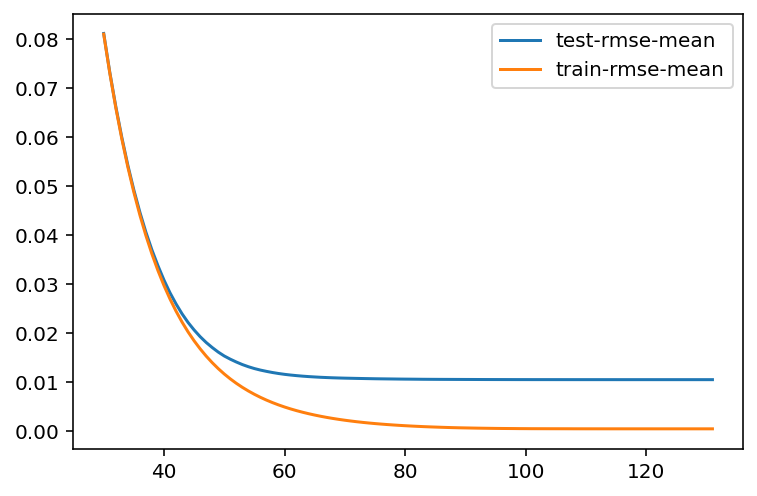

In [20]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":200, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=200, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

In [21]:
y_pred = model_xgb.predict(X_test)

In [30]:
y_pred

array([2.5427227, 2.5623553, 2.5748901, ..., 2.5572689, 2.5393987,
       2.5927422], dtype=float32)

In [24]:
y_pred_orig = np.expm1(y_pred)

array([11.714241, 11.966321, 12.129874, ..., 11.900536, 11.672049,
       12.366375], dtype=float32)

In [26]:
train['SalePrice']

0       2.583824
1       2.573300
2       2.589054
3       2.553297
4       2.597433
          ...   
1455    2.570514
1456    2.584365
1457    2.602181
1458    2.554469
1459    2.557351
Name: SalePrice, Length: 1460, dtype: float64